# 1. Тема проекта: «Автоматизация извлечения сущностей из договоров с применением NER-моделей и веб-интерфейса для визуализации».


Комментарий:

Предпосылки: Прямая необходимость автоматизации рутинного анализа договоров в юридическом отделе для сокращения временных затрат и минимизации человеческих ошибок.

Описание задачи: Разработать систему, которая решает задачу NER (Named-Entity Recognition) в предметной области юридических документов, а именно — выделяет заранее заданный набор ключевых сущностей.

Решение: Проект разбивается на последовательные этапы:

Data-Centric Stage: Сбор и разметка датасета. Разметка будет производиться в формате, пригодном для обучения NER-моделей.

ML-Stage: Сравнительное тестирование нескольких предобученных языковых моделей на задаче извлечения сущностей. Fine-tuning выбранных моделей на размеченном корпусе.

ML-Ops Stage: Интеграция лучшей модели в микросервисную архитектуру бэкенда и разработка клиентского веб-интерфейса с функцией загрузки файлов и цветовой подсветки сущностей в реальном времени.

База данных: Планируется создание собственного размеченного корпуса текстов договоров из открытых источников.


# 2. База


2.1 Подключение библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import re
import shutil
import re
# Теперь импортируем библиотеки
!pip install faker
!pip install pymorphy3
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Lambda, Conv1DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt

import os
import pandas as pd

import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 87.1 MB/s eta 0:00:00


2.2 Создание класса для аугментации основных критериев

In [ ]:
import json
import random
import re
from datetime import datetime, timedelta

# -------------------------
# Константы и базы данных
# -------------------------
CONTRACTS_TO_GENERATE = 15

CITIES = [
    "Москва", "Санкт-Петербург", "Новосибирск", "Екатеринбург", "Казань",
    "Нижний Новгород", "Челябинск", "Самара", "Омск", "Ростов-на-Дону",
    "Уфа", "Красноярск", "Пермь", "Волгоград", "Воронеж",
    "Саратов", "Краснодар", "Тольятти", "Ижевск", "Барнаул",
    "Ульяновск", "Иркутск", "Хабаровск", "Ярославль", "Владивосток",
    "Махачкала", "Томск", "Оренбург", "Кемерово", "Новокузнецк",
    "Рязань", "Астрахань", "Пенза", "Липецк", "Тула",
    "Киров", "Чебоксары", "Калининград", "Брянск", "Курск",
    "Иваново", "Магнитогорск", "Тверь", "Ставрополь", "Белгород",
    "Сочи", "Нижний Тагил", "Архангельск", "Владимир", "Сургут"
]

STREETS = [
    "Победная", "Ленина", "Центральная", "Советская", "Мира", "Гагарина",
    "Космонавтов", "Строителей", "Новая", "Садовая", "Набережная",
    "Тверская", "Арбат", "Лермонтова", "Пушкина", "Октябрьская", "Кирова",
    "Баумана", "Кутузова", "Невский", "Тульская", "Зеленая", "Первомайская"
]

COMPANIES = [
    "ООО ПСК", "АО СтройИнвест", "ЗАО Группа Компаний ПИК", "ПАО ЛСР",
    "ООО Эталон-ЛенСпецСМУ", "АО Донстрой", "ООО СМУ-77", "ПАО МИЦ",
    "ООО СтройГарант", "ООО РегионСтрой", "ООО МосИнвест", "ООО Гарант",
    "АО СибСтрой", "ООО ЕвроДом", "ПАО Ресурс", "ООО ЦентрСтрой",
    "ООО КапиталСтрой", "ООО ЮгСтрой", "ЗАО СитиСтрой", "ООО Союз",
    "ООО СеверСтрой", "АО ДорИнвест", "ООО ГородСтрой", "ООО ИнвестСтрой",
    "ООО ТрастСтрой", "ПАО Надежда", "ООО Альянс", "ООО СтройКонтинент",
    "ООО ЛидерСтрой", "ООО Новый Город"
]

FIRST_NAMES = [
    "Алексей", "Дмитрий", "Сергей", "Андрей", "Михаил", "Иван", "Кирилл",
    "Максим", "Артем", "Глеб", "Николай", "Роман", "Евгений", "Александр",
    "Константин", "Георгий", "Павел", "Юрий"
]

SURNAMES = [
    "Ивановцев", "Петров", "Сидоров", "Кузнецов", "Смирнов", "Попов", "Васильев",
    "Павлов", "Семенов", "Голубев", "Новиков", "Федоров", "Морозов", "Орлов",
    "Лебедев", "Козлов", "Зайцев", "Сорокин", "Крылов", "Белоусов"
]

PATRONYMICS = [
    "Иванович", "Петрович", "Сергеевич", "Алексеевич", "Викторович",
    "Дмитриевич", "Андреевич", "Михайлович", "Глебович", "Павлович",
    "Николаевич", "Юрьевич"
]

# -------------------------
# Вспомогательные функции
# -------------------------
def format_number(val: int, style: str = "spaces") -> str:
    """Форматирование числа (внешняя функция, нужна для совместимости)."""
    if style == "spaces":
        return f"{val:,}".replace(",", " ")
    elif style == "comma":
        return f"{val:,}"
    elif style == "plain":
        return str(val)
    else:
        raise ValueError(f"Неизвестный стиль форматирования: {style}")

def filter_longest(entities):
    """Оставляем только наибольшие непересекающиеся сущности."""
    entities = sorted(entities, key=lambda e: (e["start"], -(e["end"] - e["start"])))
    result = []
    last_end = -1
    for e in entities:
        if e["start"] >= last_end:
            result.append(e)
            last_end = e["end"]
    return result

# -------------------------
# Базовый генератор
# -------------------------
class ContractGeneratorBase:
    def __init__(self, contracts_to_generate=10):
        self.contracts_to_generate = contracts_to_generate
        self.cities = CITIES
        self.streets = STREETS
        self.company_names = COMPANIES
        self.first_names = FIRST_NAMES
        self.surnames = SURNAMES
        self.patronymics = PATRONYMICS
        self.company_types = ["ООО", "ЗАО", "АО", "ПАО"]
        self.flags = re.IGNORECASE | re.UNICODE

        self.MONTHS_RU = [
            "января", "февраля", "марта", "апреля", "мая", "июня",
            "июля", "августа", "сентября", "октября", "ноября", "декабря"
        ]

    # ---- генераторы сущностей ----
    def generate_city(self):
        return random.choice(self.cities)

    def generate_street(self):
        return random.choice(self.streets)

    def generate_company(self):
        return random.choice(self.company_names)

    def generate_fio_nominative(self):
        first_name = random.choice(self.first_names)
        surname = random.choice(self.surnames)
        patronymic = random.choice(self.patronymics)
        return f"{surname} {first_name} {patronymic}"

    def inflect_fio_genitive(self, full_name: str) -> str:
        """Сложная версия склонения ФИО в родительный падеж."""
        parts = full_name.split()
        if len(parts) == 3:
            surname, name, patronymic = parts
            if surname.endswith(('ов', 'ев', 'ин', 'ын')):
                surname += 'а'
            elif surname.endswith('ский'):
                surname = surname[:-2] + 'ого'
            elif surname.endswith('ой'):
                surname = surname[:-2] + 'ого'
            if name.endswith(('ей', 'ий', 'ай')):
                name = name[:-2] + 'я'
            elif name.endswith(('р', 'л', 'м')):
                name += 'а'
            if patronymic.endswith(('ович', 'евич', 'ич')):
                patronymic += 'а'
            return f"{surname} {name} {patronymic}"
        return full_name

    def generate_amount(self, min_val=50_000, max_val=10_000_000, with_spaces=True, style="spaces"):
        val = random.randint(min_val, max_val)
        if style == "spaces":
            formatted = f"{val:,}".replace(",", " ")
        elif style == "comma":
            formatted = f"{val:,}"
        else:
            formatted = str(val)
        return f"{formatted} рублей"
    # ---- генератор общей суммы ----
    def generate_total_amount(self, min_val=50_000, max_val=10_000_000):
        """Общая сумма договора"""
        return random.randint(min_val, max_val)

    # ---- генератор схемы оплаты ----
    def generate_payment_scheme(self, total_val: int):
        """
        Возвращает словарь с данными о платежах (проценты + суммы).
        Используется в тексте договора через шаблон.
        """
        p1 = round(random.uniform(0.05, 0.25), 2)
        p2 = round(random.uniform(0.10, 0.35), 2)

        # защита от переполнения
        if p1 + p2 >= 0.9:
            p2 = round(0.9 - p1, 2)

        p3 = round(1 - p1 - p2, 2)

        s1 = int(total_val * p1)
        s2 = int(total_val * p2)
        s3 = total_val - s1 - s2

        return {
            "total": total_val,
            "p1": int(p1 * 100), "s1": s1,
            "p2": int(p2 * 100), "s2": s2,
            "p3": int(p3 * 100), "s3": s3,
        }

    def generate_date_obj(self, days_back_min=1, days_back_max=365):
        return datetime.now() - timedelta(days=random.randint(days_back_min, days_back_max))

    # ---- паттерны для s1 ----
    def get_s1_patterns(self):
      return [
        # 1. "обязуется/вправе" + ТОЛЬКО СЛЕДУЮЩЕЕ СЛОВО
        r'\bобязуется\s+[А-Яа-яё]+(?=\s|$)',
        r'\bвправе\s+[А-Яа-яё]+(?=\s|$)',
        r'\bимеет\s+право\s+[А-Яа-яё]+(?=\s|$)',

        # 2. Отдельные слова "обязанность/обязанности", "право/права"
        r'\bобязанность\b',
        r'\bобязанности\b',
        r'\bобязанностей\b',
        r'\bправо\b',
        r'\bправа\b',

        # 3. "Предмет/ом договора"
        r'Предмет(?:ом)?\s+договора\b',
        r'Предмет(?:ом)?\s+настоящего\s+договора\b',
        r'Предмет(?:ом)?\s+трудового\s+договора\b',

        # 4. Сохранение существующих паттернов для обратной совместимости
        r'(?:обязан(?:а|ы|о)?|обязуется)\s*[:\-]?\s+[А-Яа-яё]+(?=\s|$)',
        r'должен\s*[:\-]?\s+[А-Яа-яё]+(?=\s|$)',
        r'(?:вправе|имеет\s+право)\s*[:\-]?\s+[А-Яа-яё]+(?=\s|$)',
        r'\b(?:вправе|имеет\s+право)\s*[:\-]?\b',
        r'Предмет(?:ом)?\s*[\n\r]*\s*договора'
    ]

    # ---- генерация сущностей ----
    def generate_entities(self, text: str, metadata: dict = None):
        if metadata is None:
            metadata = {}

        flags = re.IGNORECASE | re.UNICODE
        all_candidates = []

              # s1 - улучшенная генерация
        s1_candidates = []
        for pat in self.get_s1_patterns():
            for m in re.finditer(pat, text, flags):
                start, end = m.start(), m.end()
                entity_text = m.group()

                # ОСОБЫЙ СЛУЧАЙ: "Права и обязанности" - разделяем
                if re.search(r'Права\s+и\s+Обязанности', entity_text, flags):
                    # Ищем отдельно "Права" и "Обязанности"
                    rights_match = re.search(r'\bПрава\b', text[m.start():m.end()], flags)
                    duties_match = re.search(r'\bОбязанности\b', text[m.start():m.end()], flags)

                    if rights_match:
                        s1_candidates.append({
                            "start": start + rights_match.start(),
                            "end": start + rights_match.end(),
                            "text": "Права",
                            "label": "s1",
                            "priority": 10
                        })

                    if duties_match:
                        s1_candidates.append({
                            "start": start + duties_match.start(),
                            "end": start + duties_match.end(),
                            "text": "Обязанности",
                            "label": "s1",
                            "priority": 10
                        })
                else:
                    # Обычные сущности
                    s1_candidates.append({
                        "start": start,
                        "end": end,
                        "text": entity_text,
                        "label": "s1",
                        "priority": end - start
                    })

        all_candidates.extend(s1_candidates)

        # s2 деньги
        # Список ключевых слов, которые указывают на денежную сумму
        # Список ключевых слов, относящихся к денежным суммам
        money_keywords = ['р.', 'руб.', 'рублей', '₽']

        # Паттерн для чисел в разных форматах: слитно, с пробелами, с запятыми
        number_pattern = r'\d{1,3}(?:[ \u00A0.,]\d{3})*(?:[.,]\d+)?|\d+'

        # Сначала ищем все числа
        for m in re.finditer(number_pattern, text):
            start = m.start()
            end = m.end()

            # Проверяем символы после числа (до 3 символов допустимых: пробел, перенос строки, знаки)
            i = end
            skipped = 0
            while i < len(text) and skipped < 3 and text[i] in ' \n\r\t,.;:':
                i += 1
                skipped += 1

            # Проверяем, есть ли ключевое слово после числа
            matched = False
            for kw in money_keywords:
                if text[i:i+len(kw)].lower() == kw.lower():
                    end = i + len(kw)
                    matched = True
                    break

            # Если ключевое слово найдено, добавляем сущность
            if matched:
                all_candidates.append({
                    "start": start,
                    "end": end,
                    "text": text[start:end],
                    "label": "s2",
                    "priority": end - start
                })
                continue

        # Далее ищем ключевые слова отдельно, чтобы расширять их к числу назад
        for kw in money_keywords:
            for m in re.finditer(re.escape(kw), text, flags=re.IGNORECASE):
                kw_start = m.start()
                kw_end = m.end()

                # Проверяем до 3 символов перед словом, чтобы найти число
                j = kw_start - 1
                skipped = 0
                while j >= 0 and skipped < 3 and text[j] in ' \n\r\t,.;:':
                    j -= 1
                    skipped += 1

                # Если перед ключевым словом есть число, расширяем start
                number_match = re.search(r'\d{1,3}(?:[ \u00A0.,]\d{3})*(?:[.,]\d+)?|\d+', text[max(0,j-15):j+1])
                if number_match:
                    num_start = max(0, j-15) + number_match.start()
                    num_end = max(0, j-15) + number_match.end()
                    all_candidates.append({
                        "start": num_start,
                        "end": kw_end,
                        "text": text[num_start:kw_end],
                        "label": "s2",
                        "priority": kw_end - num_start
                    })




        # проценты отдельно
                # s2 - проценты (улучшенная версия)
        percent_candidates = []
        percent_patterns = [
            # Только число с % без скобок
            r'\b\d+(?:[.,]\d+)?\s*%',
            r'\b\d+(?:[.,]\d+)?\s*процентов\b',
            r'\b\d+(?:[.,]\d+)?\s*percent\b'
        ]

        for pat in percent_patterns:
            for m in re.finditer(pat, text, re.IGNORECASE | re.UNICODE):
                percent_text = m.group()

                # Убираем возможные пробелы вокруг %
                clean_text = re.sub(r'\s+', '', percent_text)

                percent_candidates.append({
                    "start": m.start(),
                    "end": m.end(),
                    "text": clean_text,
                    "label": "s2",
                    "priority": m.end() - m.start()
                })

        all_candidates.extend(percent_candidates)


        # s3: даты ----


        flags = re.UNICODE | re.IGNORECASE
        date_candidates = []
        period_patterns = [
            # В течение N (словом) дней/месяцев/лет
            r'\bв\s+течение\s+\d+(?:\s*\([^)]+\))?\s*(?:рабочих|банковских|календарных)?\s*'
            r'(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)(?=[\s,;.:]|$)',

            # Не позднее чем через N дней/месяцев/лет
            r'\bне\s+позднее\s+чем\s+через\s+\d+(?:\s*\([^)]+\))?\s*'
            r'(?:рабочих|банковских|календарных)?\s*'
            r'(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)(?=[\s,;.:]|$)',
            r'\bне\s+позднее\s+чем(?:\s+за)?\s+\d+(?:\s*\([^)]+\))?\s*'
            r'(?:рабочих|банковских|календарных)?\s*'
            r'(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)(?=[\s,;.:]|$)'
            r'\b(?:в\s+течение|не\s+позднее\s+чем(?:\s+за)?|через|на)?\s*'
            r'\d+(?:\s*\([^)]+\))?\s*'
            r'(?:рабочих|банковских|календарных)?\s*'
            r'(день|дня|дней|месяц|месяца|месяцев|год|года|лет)(?=[\s,;.:]|$)',

            # Через N дней/месяцев/лет
            r'\bчерез\s+\d+(?:\s*\([^)]+\))?\s*'
            r'(?:рабочих|банковских|календарных)?\s*'
            r'(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)(?=[\s,;.:]|$)',

            # На N дней/месяцев/лет
            r'\bна\s+\d+(?:\s*\([^)]+\))?\s*'
            r'(?:рабочих|банковских|календарных)?\s*'
            r'(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)(?=[\s,;.:]|$)',

            # Просто N дней/месяцев/лет
            r'\b\d+(?:\s*\([^)]+\))?\s*'
            r'(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)(?=[\s,;.:]|$)',

            # Составные устойчивые конструкции
            r'\bс\s+момента\b',
            r'\bдействует\s+до\s+полного\b',
            r'\bсоставляет\s+\d+(?:\s*\([^)]+\))?\s*'
            r'(?:год|года|лет)\s+с\s+момента\b',

            # Ежемесячно, ежегодно и т.д.
            r'\b(ежемесячно|ежегодно|еженедельно|ежедневно|ежеквартально)\b',
            r'\b\d+\s+раз(?:а|ов)?\s+в\s+(?:месяц|год|неделю)\b',
        ]

        for pat in period_patterns:
            for m in re.finditer(pat, text, flags):
                date_candidates.append({
                    "start": m.start(),
                    "end": m.end(),
                    "text": m.group(),
                    "label": "s3",           # метка s3 для периода
                    "priority": m.end() - m.start()
                })

        # УЛУЧШЕННЫЕ ПАТТЕРНЫ ДЛЯ КОНКРЕТНЫХ ДАТ
        # Основной паттерн для дат в формате DD.MM.YYYY
        exact_date_pattern = r'\b\d{1,2}\.\d{1,2}\.\d{4}\b'

        for m in re.finditer(exact_date_pattern, text):
            start, end = m.start(), m.end()

            # Проверяем, не является ли это частью диапазона дат
            context_before = max(0, start - 15)
            context_after = min(len(text), end + 15)
            full_context = text[context_before:context_after]

            # Если дата стоит отдельно или в контексте "с DD.MM.YYYY", "по DD.MM.YYYY" и т.д.
            if not re.search(r'\d{1,2}\.\d{1,2}\.\d{4}\s*[-–—]\s*\d{1,2}\.\d{1,2}\.\d{4}', full_context):
                date_candidates.append({
                    "start": start,
                    "end": end,
                    "text": m.group(),
                    "label": "s3",
                    "priority": 15  # Высокий приоритет для точных дат
                })

        # Паттерн для периодов в днях/месяцах/годах (исправленный)
        period_duration_patterns = [
            r'\b\d+\s+(?:календарных|рабочих)\s+(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)\b',
            r'\b\d+\s+(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)\s+(?:календарных|рабочих)\b',
            r'\b(?:не\s+менее|не\s+более|не\s+позднее)\s+\d+\s+(?:день|дня|дней|месяц|месяца|месяцев|год|года|лет)\b'
        ]

        for pat in period_duration_patterns:
            for m in re.finditer(pat, text, flags):
                date_candidates.append({
                    "start": m.start(),
                    "end": m.end(),
                    "text": m.group(),
                    "label": "s3",
                    "priority": 12
                })

        # День в кавычках или без
        day_pattern = r'(?:["«]?\d{1,2}["»]?)'
        month_pattern = r'(?:января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)'
        year_pattern = r'\d{4}'
        g_pattern = r'(?:\s*г\.?)?(?=[\s,;.:]|$)'
        sep = r'[\s\n\r]*'
        single_date_pattern = rf'{day_pattern}{sep}{month_pattern}{sep}{year_pattern}{g_pattern}'
        dates_sequence_pattern = rf'{single_date_pattern}(?:{sep}[,;:\n]+{sep}{single_date_pattern})*'

        for m in re.finditer(dates_sequence_pattern, text, flags):
            start_pos = m.start()
            end_pos = m.end()
            while end_pos > start_pos and text[end_pos-1] in ',;:.':
                end_pos -= 1
            date_candidates.append({
                "start": start_pos,
                "end": end_pos,
                "text": text[start_pos:end_pos].strip(),
                "label": "s3",
                "priority": end_pos - start_pos
            })

        # УЛУЧШЕННАЯ ОБРАБОТКА ДЛЯ ЗАХВАТА ПОЛНЫХ ВЫРАЖЕНИЙ
        for candidate in date_candidates[:]:  # Используем копию для безопасной итерации
            if candidate["label"] == "s3":
                start, end = candidate["start"], candidate["end"]

                # Расширяем захват для включения предлогов и контекста
                pre_context_start = max(0, start - 5)
                pre_text = text[pre_context_start:start]
                if re.search(r'\b(?:с|по|на|до|от|в|во)\s*$', pre_text):
                    candidate["start"] = pre_context_start + pre_text.rfind(' ')
                    candidate["text"] = text[candidate["start"]:end]

                # Проверяем символы после даты (дополнительные указания)
                post_context_end = min(len(text), end + 15)
                post_text = text[end:post_context_end]

                # Если после даты есть "года", "г.", или другие временные указания
                post_match = re.search(r'^\s*(?:года?|г\.?|год|лет|месяцев?)', post_text, flags)
                if post_match:
                    candidate["end"] = end + post_match.end()
                    candidate["text"] = text[candidate["start"]:candidate["end"]]

        # Постобработка для s3
        for c in date_candidates:
            if c["label"] == "s3":
                end_pos = c["end"]
                # расширяем набор допустимых символов между датой и ключевым словом
                allowed = ' \u00A0\n\r\t,;:.«»"\'-'
                keywords = ['г.', 'года', 'лет', 'месяц', 'месяца', 'месяцев']
                lookahead_len = 20
                la_end = min(end_pos + lookahead_len, len(text))
                i = end_pos
                while i < la_end:
                    if text[i] in allowed:
                        i += 1
                        continue
                    matched = False
                    for kw in keywords:
                        if text.startswith(kw, i):
                            i += len(kw)
                            matched = True
                            break
                    if not matched:
                        break
                if i != c["end"]:
                    c["end"] = i
                    c["text"] = text[c["start"]:i]

        all_candidates.extend(date_candidates)



        all_candidates.extend(date_candidates)

        # s4 адреса
        # Построчный поиск адресов
        # -------------------------

        addr_candidates = []
        lines = text.splitlines()
        # Дом с возможной точкой или запятой после номера
        house_pattern = r'д\.?\s*\d+[\.,;:-]?'

        # --- 1. полный адрес (паттерн уже проверенный) ---
        full_pattern = rf'\b(?:г\.?|город[ауе]?)\s*({"|".join(map(re.escape, self.cities))})' \
                      r'(?:,\s*ул\.?\s*[\w\s\-]+)?' \
                      rf'(?:,\s*{house_pattern})?' \
                      r'(?:,\s*кв\.?\s*\d+)?\b'

        for i, line in enumerate(lines):
            line_start = text.find(line)
            for m in re.finditer(full_pattern, line, flags=re.UNICODE | re.IGNORECASE):
                city_match = m.group(1)
                if not city_match:
                    continue
                # фильтр контекста перед городом
                context_before = line[max(0, m.start() - 20):m.start()].lower()
                if any(kw in context_before for kw in ["работодатель", "участник", "фамилия", "имя", "отчество", "/"]):
                    continue
                start_pos = line_start + m.start()
                end_pos = line_start + m.end()
                addr_candidates.append({
                    "start": start_pos,
                    "end": end_pos,
                    "text": text[start_pos:end_pos],
                    "label": "s4",
                    "priority": end_pos - start_pos
                })

        # --- 2. отдельные города из списка ---
        # слово города + завершающие знаки препинания (не включаем в группу)
        city_pattern = r'\b(?:г\.?|город[ауе]?)\s*([А-ЯЁ][а-яё]+(?:[-\s][А-ЯЁ][а-яё]+)*)'

        for i, line in enumerate(lines):
            line_start = text.find(line)
            for match in re.finditer(city_pattern, line):
                city_name = match.group(1)
                if city_name.lower() not in [c.lower() for c in self.cities]:
                    continue

                # фильтр контекста
                context_before = line[max(0, match.start()-20):match.start()].lower()
                if any(kw in context_before for kw in ["работодатель", "участник", "фамилия", "имя", "отчество", "/"]):
                    continue

                start_pos = line_start + match.start()
                end_pos_line = match.end()

                # добавляем знак препинания сразу после города
                while end_pos_line < len(line) and line[end_pos_line] in ".,;:-":
                    end_pos_line += 1
                end_pos = line_start + end_pos_line

                addr_candidates.append({
                    "start": start_pos,
                    "end": end_pos,
                    "text": text[start_pos:end_pos],
                    "label": "s4",
                    "priority": end_pos - start_pos
                })
                for candidate in addr_candidates:
                    lookahead = text[candidate['end']:candidate['end'] + 10]  # ограничение 10 символов
                    la = lookahead.lstrip(' ,;:.')
                    # если есть номер дома или квартиры, расширяем
                    m = re.match(r'(д\.?\s*\d{1,4}(?:[\/кс]\d{1,3})?|кв\.?\s*\d{1,4})', la, flags=re.IGNORECASE)
                    if m:
                        candidate['end'] += len(lookahead) - len(la) + m.end()
                        candidate['text'] = text[candidate['start']:candidate['end']]

                # --- 3. фильтр пересечений ---
        addr_candidates = filter_longest(addr_candidates)



        all_candidates.extend(addr_candidates)

        # дедупликация
        all_candidates = sorted(all_candidates, key=lambda e: (-e["priority"], e["start"]))
        selected = []
        occupied = [False] * (len(text) + 1)
        for cand in all_candidates:
            overlap = False
            for pos in range(cand["start"], cand["end"]):
                if occupied[pos]:
                    overlap = True
                    break
            if not overlap:
                selected.append({
                    "start": cand["start"], "end": cand["end"],
                    "label": cand["label"], "text": cand["text"]
                })
                for pos in range(cand["start"], cand["end"]):
                    occupied[pos] = True

        selected.sort(key=lambda e: e["start"])
        return selected


2.3 Договоры долевого строительства

In [ ]:
from collections import Counter

# -------------------------
# Конкретный генератор: договор долевого строительства
# -------------------------
class EquityContractGenerator(ContractGeneratorBase):
    """
    Генератор договоров участия в долевом строительстве (на основе твоего шаблона).
    Переопределяет get_s1_patterns(), использует общую generate_entities() из базового класса.
    """
    def __init__(self, contracts_to_generate=CONTRACTS_TO_GENERATE, **kwargs):
        super().__init__(contracts_to_generate=contracts_to_generate, **kwargs)


    def generate_single_contract(self, index: int):
        """Создаёт один договор и возвращает dict {text, entities, metadata}"""
        city = self.generate_city()
        street = self.generate_street()

        company = self.generate_company()
        director_nom = self.generate_fio_nominative()
        director_gen = self.inflect_fio_genitive(director_nom)  # для "в лице"
        participant_nom = self.generate_fio_nominative()
        participant_gen = self.inflect_fio_genitive(participant_nom)
        MONTHS_RU=self.MONTHS_RU
        apartment = {
            "rooms": random.randint(1, 4),
            "section": random.randint(1, 10),
            "floor": random.randint(1, 25),
            "number": random.randint(1, 1000),
            "area": random.randint(25, 120),
            "price_per_sqm": random.randint(80_000, 250_000)
        }
        apartment["total_price"] = apartment["area"] * apartment["price_per_sqm"]

        dates = {
            "start_date": (datetime.now() - timedelta(days=random.randint(180, 720))).strftime('%Y-%m-%d'),
            "completion_date": (datetime.now() + timedelta(days=random.randint(30, 720))).strftime('%Y-%m-%d'),
            "completion_date_obj": datetime.now() + timedelta(days=random.randint(30, 720)),
            "warranty_years": random.randint(2, 4)
        }

        penalty_percent = random.choice([0.1, 0.2, 0.5, 1.0, 1.5, 2.0])
        initial_payment_percent = random.randint(10, 30)

        total_price_formatted = f"{apartment['total_price']:,}".replace(",", " ")
        initial_payment_amount = initial_payment_percent * apartment['total_price'] // 100
        initial_payment_formatted = f"{initial_payment_amount:,}".replace(",", " ")

        completion_date = datetime.strptime(dates["completion_date"], '%Y-%m-%d')
        start_date = datetime.strptime(dates["start_date"], '%Y-%m-%d')

        # адреса для раздела 8 (добавим небольшие отличия)
        city1 = random.choice(self.cities)
        city2 = random.choice(self.cities)
        street1 = random.choice(self.streets)
        street2 = random.choice(self.streets)

        # ТЕКСТ ДОГОВОРА (базовый шаблон, можно расширять)
        contract_text = f"""ДОГОВОР N {random.randint(1000, 9999)} участия в долевом строительстве многоквартирного дома
(с условием об отделке квартиры)

г. {city} "{start_date.strftime('%d')}" {self.MONTHS_RU[start_date.month - 1]} {start_date.strftime('%Y')} г.

{company}, именуемое в дальнейшем "Застройщик"; в лице директора {director_gen}, действующего на основании устава, с одной стороны, и {participant_gen}, именуемый в дальнейшем "Участник долевого строительства", с другой стороны, вместе именуемые "Стороны", заключили настоящий Договор о нижеследующем:

1. ТЕРМИНЫ И ОПРЕДЕЛЕНИЯ. ОСНОВАНИЯ ЗАКЛЮЧЕНИЯ ДОГОВОРА И ГАРАНТИИ ЗАСТРОЙЩИКА

1.1. Если в тексте настоящего Договора не указано иное, то термины и определения имеют следующее значение:

многоквартирный дом (далее - "Дом") - дом, строящийся с привлечением денежных средств Участника долевого строительства по адресу: г. {city}, ул. {street}, д.{random.randint(1,100)}.
Квартира - объект долевого строительства, то есть жилое помещение, подлежащее передаче Участнику долевого строительства после получения разрешения на ввод в эксплуатацию Дома и входящее в состав Дома. Квартира состоит из {apartment['rooms']} комнат, будет находиться в Доме в {apartment['section']} секции на {apartment['floor']} этаже (номер на площадке {random.randint(1, 10)}, строительный номер {apartment['number']}), общей площадью {apartment['area']} кв. м. в соответствии с проектной документацией.

1.2. Все необходимые для заключения и исполнения настоящего Договора лицензии, разрешения и/или иные документы и/или договоры от соответствующих и уполномоченных на их представление государственных органов/лиц Застройщиком получены/заключены, являются юридически действительными и вступившими в силу.

1.3. Застройщик располагает всеми необходимыми юридически действительными правами и полномочиями, разрешениями и документами, а именно:
- разрешением на строительство N {random.randint(1000, 9999)}, выданным "{random.randint(1,28)}"{MONTHS_RU[random.randint(0,11)]} {random.randint(2022,2023)}г,  г. {city};
- оформленным в соответствии с действующим законодательством Российской Федерации правом собственности Застройщика на земельный участок, предоставленный для строительства Дома;

2. ПРЕДМЕТ ДОГОВОРА

2.1. Предметом настоящего договора является участие Участника долевого строительства в строительстве многоквартирного дома и передача ему Квартиры.
2.2. Право собственности на Квартиру возникает у Участника долевого строительства с момента государственной регистрации указанного права в установленном действующим законодательством Российской Федерации порядке.
2.3. Застройщик обязуется передать Квартиру, а Участник долевого строительства обязуется принять Квартиру и оплатить ее стоимость в размере {total_price_formatted} рублей.
2.4. Риск случайной гибели или случайного повреждения Квартиры до ее передачи Участнику долевого строительства несет Застройщик.

3. ПРАВА И ОБЯЗАННОСТИ СТОРОН

3.1. По настоящему Договору:
а) Застройщик обязуется сообщать Участнику долевого строительства по его требованию информацию о ходе выполнения работ по строительству Дома г. {city} и Квартиры в нем;
б) Застройщик обязуется передать Участнику долевого строительства Квартиру с отделкой, которая включает в себя цементную стяжку полов, штукатурку стен, выравнивание потолков, гидроизоляцию полов в санузле, разводку под сантехнику и водоснабжение, установку входной двери, электрической фурнитуры, радиаторов, остекление лоджий, по передаточному акту не позднее "{completion_date.strftime('%d')}"{MONTHS_RU[completion_date.month - 1]} {completion_date.strftime('%Y')} г.;
в) Застройщик обязуется сообщить Участнику долевого строительства письменно о завершении строительства Дома и готовности Квартиры к передаче за 10 дней;
г) Застройщик обязуется совершить все действия, необходимые для регистрации права собственности Участника долевого строительства на Квартиру;
д) Застройщик обязуется вести общие дела по предмету настоящего Договора и все необходимые для осуществления строительства сделки с третьими лицами;
е) Застройщик обязуется заключить договор с эксплуатационной службой для обеспечения в Квартире коммунальных услуг, противопожарной сигнализации и других необходимых систем после сдачи Дома в эксплуатацию .

3.2.
а) Участник долевого строительства обязуется принять Квартиру и подписать передаточный акт при получении уведомления Застройщика о завершении строительства Дома г. {city} и готовности Квартиры к передаче при отсутствии претензий к Квартире;
б) Участник долевого строительства обязуется предоставить все необходимые от Участника долевого строительства для регистрации права собственности на Квартиру документы;
в) Участник долевого строительства обязуется оплатить стоимость Квартиры в размере {total_price_formatted} рублей в порядке и сроки, предусмотренные настоящим Договором.

3.3. Участник долевого строительства вправе контролировать ход выполнения работ по строительству Дома;
а) Участник долевого строительства вправе контролировать срок выполнения работ по строительству Дома;
б) Участник долевого строительства вправе требовать от Застройщика устранения выявленных недостатков;
в) Участник долевого строительства вправе расторгнуть настоящий Договор в случае существенного нарушения Застройщиком его условий.

3.4. Застройщик вправе приостановить строительство в случае задержки оплаты более чем на 3 месяца.

3.5. Вступая в число Участников долевого строительства по строительству Дома, Участник долевого строительства приобретает право владеть на часть незавершенного строительством Дома, являющегося общей долевой собственностью.

3.6. Обязательства Застройщика считаются исполненными с момента подписания Сторонами передаточного акта о передаче Квартиры в филиале г. {city} Застройщика .
4. ЦЕНА ДОГОВОРА И ПОРЯДОК РАСЧЕТОВ

4.1. Стоимость Квартиры по настоящему Договору составляет {total_price_formatted} рублей, исходя из стоимости одного квадратного метра {apartment['price_per_sqm']:,} рублей и общей площади Квартиры, равной {apartment['area']} кв. м.

4.2. Участник долевого строительства оплачивает стоимость Квартиры в следующем порядке:
- {initial_payment_percent}% от стоимости Квартиры ({initial_payment_formatted} рублей) в течение 5 банковских дней с момента подписания настоящего Договора;
- оставшуюся часть стоимости Квартиры - равными частями ежемесячно до момента передачи Квартиры.
4.3 При просрочке платежа Арендатор уплачивает пеню в размере {penalty_percent}% от суммы задолженности за каждый день просрочки.
5. КАЧЕСТВО ПРЕДМЕТА. ГАРАНТИЯ КАЧЕСТВА

5.1. Гарантийный срок на Квартиру по адресу: г. {city}, ул. {street}, д.{random.randint(1,100)} составляет {dates['warranty_years']} года с момента подписания передаточного акта.
5.2. Гарантийный срок на Квартиру по адресу: г. {city}, ул. {street}, д.{random.randint(1,100)}, за исключением технологического и инженерного оборудования, входящего в ее состав, составляет {dates['warranty_years']} года с момента подписания передаточного акта.

5.3. Гарантийный срок на технологическое и инженерное оборудование, входящее в состав Квартиры по адресу: г. {city}, ул. {street}, д.{random.randint(1,100)}, составляет {dates['warranty_years']} года и исчисляется со дня подписания передаточного акта.

5.4. Все обнаруженные в течение гарантийного срока недостатки, которые не могли быть выявлены при осмотре Квартиры и подписании передаточного акта, должны быть устранены Застройщиком самостоятельно или с привлечением иных лиц в 30-дневный срок с момента уведомления его Участником долевого строительства об этих недостатках.

5.5. Застройщик не несет ответственности за недостатки (дефекты) Квартиры, обнаруженные в пределах гарантийного срока, если докажет, что они произошли вследствие нормального износа Квартиры или ее частей, нарушения требований к процессу ее эксплуатации либо вследствие ненадлежащего ремонта, проведенного самим Участником долевого строительства или привлеченными им третьими лицами.
В противном случае Застройщик несёт ответственность и обязан устранить недостатки (дефекты) Квартиры.

6. СРОК ДЕЙСТВИЯ ДОГОВОРА. ДОСРОЧНОЕ РАСТОРЖЕНИЕ

6.1. Настоящий Договор вступает в силу с момента его подписания Сторонами и действует до полного исполнения Сторонами своих обязательств.

6.2. Действие настоящего Договора прекращается с момента выполнения Сторонами своих обязательств, предусмотренных настоящим Договором, ввода Дома в эксплуатацию, государственной регистрации права собственности Участника долевого строительства на Квартиру в отделениях г. {city} и полного расчета между Сторонами.

6.3. Участник долевого строительства вправе расторгнуть настоящий Договор в одностороннем порядке в случаях:
- неисполнения Застройщиком обязательства по передаче Квартиры в срок, превышающий установленный на 2 месяца;
- неисполнения Застройщиком обязанностей, предусмотренных законом, в случае, если Дом и (или) Квартира построены Застройщиком с отступлениями от условий Договора, приведшими к ухудшению качества;
- существенного нарушения требований к качеству Квартиры.

6.4. Застройщик вправе расторгнуть настоящий Договор в одностороннем порядке расторгнуть в случаях:
- систематического нарушения Участником долевого строительства сроков внесения платежей более чем 3 раза в течение 12 месяцев;
- неуплаты Участником долевого строительства стоимости Квартиры в течение 3 месяцев подряд.

6.5. В случае расторжения Договора Застройщик обязан возвратить денежные средства, уплаченные Участником долевого строительства в счет цены Договора, а также уплатить проценты в размере одной трехсотой ставки рефинансирования Центрального банка Российской Федерации за каждый день пользования денежными средствами.

7. ЗАКЛЮЧИТЕЛЬНЫЕ ПОЛОЖЕНИЯ

7.1. Во всем остальном, что не предусмотрено настоящим Договором, Стороны руководствуются действующим законодательством Российской Федерации, в случае, если стороны не договорились, споры разрешаются в суде г. {city}.

7.2. Все изменения и дополнения к настоящему Договору действительны лишь в случае, если они совершены в письменной форме и подписаны обеими Сторонами.

7.3. Настоящий Договор составлен в двух экземплярах, имеющих одинаковую юридическую силу, по одному экземпляру для каждой из Сторон.
8. АДРЕСА И РЕКВИЗИТЫ СТОРОН

Застройщик:
{company}
Адрес: г. {city1}, ул. {street1}, д. {random.randint(1, 100)}

Участник долевого строительства:
{participant_nom}
Адрес: г. {city2}, ул. {street2}, д. {random.randint(1, 100)}, кв. {random.randint(1, 200)}

ПОДПИСИ СТОРОН:

Застройщик: _____________ / {director_nom} /
Участник долевого строительства: _____________ / {participant_nom} /
"""

        # собираем metadata для генерации entities (и для потенциальных последующих шагов)
        metadata = {
            'city': city,
            'street': street,
            'house_number': None,
            'section': apartment['section'],
            'floor': apartment['floor'],
            'total_price': apartment['total_price'],
            'price_per_sqm': apartment['price_per_sqm'],
            'area': apartment['area'],
            'completion_date': dates['completion_date'],
            'warranty_years': dates['warranty_years'],
            'penalty_percent': penalty_percent,
            'initial_payment_percent': initial_payment_percent
        }

        entities = self.generate_entities(contract_text, metadata=metadata)
        return {
            "text": contract_text,
            "entities": entities,
            "metadata": {
                "contract_type": "долевое строительство",
                **metadata,
                "company": company,
                "director_fio": director_nom,
                "participant_fio": participant_nom
            }
        }

    def generate_contracts(self):
        """Генерация нескольких контрактов (self.contracts_to_generate)"""
        contracts = []
        for i in range(self.contracts_to_generate):
            contracts.append(self.generate_single_contract(i))
        return contracts

# -------------------------
# Пример использования
# -------------------------
if __name__ == "__main__":
    gen = EquityContractGenerator(contracts_to_generate=3)
    contracts = gen.generate_contracts()

    # сохранение
    out_path = "equity_contracts_from_class.jsonl"
    with open(out_path, "w", encoding="utf-8") as f:
        for c in contracts:
            f.write(json.dumps(c, ensure_ascii=False) + "\n")

    # статистика по тегам
    tag_stats = Counter()
    for c in contracts:
        for e in c["entities"]:
            tag_stats[e["label"]] += 1

    print(f"✅ Создано {len(contracts)} договоров. Файл: {out_path}")
    print("📊 Статистика по тегам:", dict(tag_stats))
    print("\n📋 Пример — первый договор (текст):\n")
    print(contracts[0]["text"][:10000])  # длинный текст, выводим кусок
    print("\n🏷️ Разметка entities первого договора:")
    for e in contracts[0]["entities"]:
        print(f"  {e['label']}: '{e['text']}' (позиции {e['start']}-{e['end']})")


✅ Создано 3 договоров. Файл: equity_contracts_from_class.jsonl
📊 Статистика по тегам: {'s4': 36, 's3': 60, 's1': 93, 's2': 21}

📋 Пример — первый договор (текст):

ДОГОВОР N 9267 участия в долевом строительстве многоквартирного дома
(с условием об отделке квартиры)

г. Ульяновск "20" июня 2025 г.

ООО СеверСтрой, именуемое в дальнейшем "Застройщик"; в лице директора Попова Кирилла Глебовича, действующего на основании устава, с одной стороны, и Зайцева Николя Петровича, именуемый в дальнейшем "Участник долевого строительства", с другой стороны, вместе именуемые "Стороны", заключили настоящий Договор о нижеследующем:

1. ТЕРМИНЫ И ОПРЕДЕЛЕНИЯ. ОСНОВАНИЯ ЗАКЛЮЧЕНИЯ ДОГОВОРА И ГАРАНТИИ ЗАСТРОЙЩИКА

1.1. Если в тексте настоящего Договора не указано иное, то термины и определения имеют следующее значение:

многоквартирный дом (далее - "Дом") - дом, строящийся с привлечением денежных средств Участника долевого строительства по адресу: г. Ульяновск, ул. Набережная, д.38.
Квартира - объект доле

2.4 Договоры аренды

In [ ]:
import json
import random
from datetime import datetime, timedelta

class RentContractGenerator(ContractGeneratorBase):
    def __init__(self, contracts_to_generate=50):
        super().__init__(contracts_to_generate=contracts_to_generate)

        self.building_types = [
            "складского назначения", "офисного назначения", "торгового назначения",
            "производственного назначения", "административного назначения"
        ]
        self.purposes = [
            "хранения товарно-материальных ценностей и ведения складской деятельности",
            "ведения офисной деятельности и размещения сотрудников",
            "организации торговой деятельности и розничной продажи",
            "размещения производственного оборудования и ведения производственной деятельности"
        ]

    def generate_contract(self, index):
        """Генерация одного договора аренды"""
        city = self.generate_city()
        street = self.generate_street()
        building_type = random.choice(self.building_types)
        purpose = random.choice(self.purposes)
        MONTHS_RU=self.MONTHS_RU

        # Случайные значения
        area = random.randint(100, 2000)
        rent_price = self.generate_amount(min_val=50_000, max_val=500_000)
        duration = random.randint(1, 5)
        penalty_percent = random.choice([0.1, 0.2, 0.5, 1.0])

        # Даты
        sign_date = datetime.now() - timedelta(days=random.randint(1, 365))

        # Стороны
        company1 = self.generate_company()
        company2 = self.generate_company()

        # --- генерация общей суммы и схемы платежей ---
        total_amount = self.generate_total_amount()
        payment_scheme = self.generate_payment_scheme(total_amount)
        # ФИО
        fio1_nom = self.generate_fio_nominative()
        fio2_nom = self.generate_fio_nominative()
        fio1_gen = self.inflect_fio_genitive(fio1_nom)
        fio2_gen = self.inflect_fio_genitive(fio2_nom)

        position1 = random.choice(["Генерального директора", "Директора"])
        position2 = random.choice(["Генерального директора", "Директора"])

        contract_text = f"""ДОГОВОР АРЕНДЫ ЗДАНИЯ № {random.randint(100,999)}-АР
г. {city} «{sign_date.strftime('%d')}» {self.MONTHS_RU[sign_date.month - 1]} {sign_date.strftime('%Y')} г.

{company1} в лице {position1} {fio1_gen}, действующего на основании Устава, именуемый в дальнейшем «Арендодатель», с одной стороны, и {company2} в лице {position2} {fio2_gen}, действующего на основании Устава, именуемый в дальнейшем «Арендатор», с другой стороны, заключили настоящий договор о нижеследующем:

1. ПРЕДМЕТ ДОГОВОРА

1.1. Арендодатель передает, а Арендатор принимает в аренду нежилое здание {building_type} общей площадью {area} кв.м, расположенное по адресу: г. {city}, ул. {street}, д. {random.randint(1, 100)}.

1.2. Помещение используется для {purpose}.

1.3. Срок аренды составляет {duration} {'год' if duration == 1 else 'года' if duration in [2,3,4] else 'лет'}.

2. АРЕНДНАЯ ПЛАТА И РАСЧЕТЫ

2.1. Арендная плата составляет {rent_price} в месяц.

2.2 Порядок оплаты:
 Заказчик уплачивает Исполнителю аванс в размере {payment_scheme['s1']} рублей ({payment_scheme['p1']}% от общей стоимости Договора) при его подписании.
 Оплата в размере {payment_scheme['s2']} рублей ({payment_scheme['p2']}% от общей стоимости Договора) производится Заказчиком в течение 5 (пяти) банковских дней с момента выставления Исполнителем счёта за основной этап работ.
 Оставшаяся часть общей стоимости Договора в размере {payment_scheme['s3']} рублей ({payment_scheme['p3']}% от общей стоимости Договора) уплачивается Заказчиком в течение 5 (пяти) банковских дней после подписания Сторонами всех закрывающих документов.
 Общая стоимость Договора: {payment_scheme['total']} рублей.

2.3. При просрочке платежа Арендатор уплачивает пеню в размере {penalty_percent}% от суммы задолженности за каждый день просрочки.

3. ОБЯЗАННОСТИ СТОРОН

3.1. Арендодатель обязан передать здание в состоянии, пригодном для использования по назначению.

3.2. Арендатор обязан своевременно вносить арендные платежи и поддерживать помещение в надлежащем состоянии.

3.3. Арендатор вправе передавать арендуемое помещение в субаренду с письменного согласия Арендодателя.

4. ОТВЕТСТВЕННОСТЬ СТОРОН

4.1. За неисполнение обязательств по договору Стороны несут ответственность в соответствии с законодательством РФ и постановлениями в сфере недвижимости г. {city}.

5. РАСТОРЖЕНИЕ ДОГОВОРА

5.1. Договор может быть расторгнут по соглашению сторон или в судебном порядке в Арбитражном суде  г. {city}.

6. АДРЕСА И РЕКВИЗИТЫ СТОРОН

Арендодатель: {company1}, г. {city}, ул. {street}, д. {random.randint(1, 100)}
Арендатор: {company2}, г. {city}, ул. {street}, д. {random.randint(1, 100)}

ПОДПИСИ СТОРОН:

Арендодатель: _________________ / {fio1_nom} /
Арендатор: _________________ / {fio2_nom} /"""

        return {
            "text": contract_text,
            "entities": self.generate_entities(contract_text),
            "metadata": {
                "rent_price": rent_price,
                "duration": duration,
                "penalty_percent": penalty_percent
            }
        }

# Пример использования
if __name__ == "__main__":
    generator = RentContractGenerator(contracts_to_generate=5)
    contracts = [generator.generate_contract(i) for i in range(generator.contracts_to_generate)]

    with open("contracts_rent.jsonl", "w", encoding="utf-8") as f:
        for contract in contracts:
            f.write(json.dumps(contract, ensure_ascii=False) + "\n")

    print(f"✅ Создано {generator.contracts_to_generate} договоров аренды")
    print("📋 Пример первого договора:")
    print("="*80)
    print(contracts[0]["text"])
    print("="*80)
    print("🏷️ Разметка entities:")
    for entity in contracts[0]["entities"]:
        print(f"  {entity['label']}: '{entity['text']}' (позиции {entity['start']}-{entity['end']})")


✅ Создано 5 договоров аренды
📋 Пример первого договора:
ДОГОВОР АРЕНДЫ ЗДАНИЯ № 899-АР
г. Ижевск «15» февраля 2025 г.

ООО СтройКонтинент в лице Директора Васильева Сергя Алексеевича, действующего на основании Устава, именуемый в дальнейшем «Арендодатель», с одной стороны, и ООО ЮгСтрой в лице Директора Федорова Роман Петровича, действующего на основании Устава, именуемый в дальнейшем «Арендатор», с другой стороны, заключили настоящий договор о нижеследующем:

1. ПРЕДМЕТ ДОГОВОРА

1.1. Арендодатель передает, а Арендатор принимает в аренду нежилое здание офисного назначения общей площадью 1093 кв.м, расположенное по адресу: г. Ижевск, ул. Гагарина, д. 66.

1.2. Помещение используется для хранения товарно-материальных ценностей и ведения складской деятельности.

1.3. Срок аренды составляет 1 год.

2. АРЕНДНАЯ ПЛАТА И РАСЧЕТЫ

2.1. Арендная плата составляет 94 609 рублей в месяц.

2.2 Порядок оплаты:
 Заказчик уплачивает Исполнителю аванс в размере 65429 рублей (9% от общей стоимости Дого

2.4 Договоры залога

In [ ]:
import json
import random
from datetime import datetime, timedelta
from collections import Counter

class MortgageContractGenerator(ContractGeneratorBase):
    """
    Генератор договоров залога / ипотеки (наследует все общие методы из ContractGeneratorBase).
    Изменено только:
      - s1-паттерны (get_s1_patterns)
      - список RIGHTS_BASES (специфика предмета залога)
    Все остальное — используется из базового класса.
    """
    RIGHTS_BASES = [
        "свидетельства о государственной регистрации права",
        "договора купли-продажи",
        "договора дарения",
        "свидетельства о праве на наследство",
        "решения суда"
    ]


    def __init__(self, contracts_to_generate=10, **kwargs):
        super().__init__(contracts_to_generate=contracts_to_generate, **kwargs)



    def generate_single_contract(self, index: int):
        """
        Создаёт один договор залога (ипотеки) и возвращает dict {text, entities, metadata}.
        Использует методы базового класса для всех случайных элементов.
        """
        # Основные случайные элементы — через базовый класс
        city = self.generate_city()
        street = self.generate_street()
        company1 = self.generate_company()
        company2 = self.generate_company()
        MONTHS_RU=self.MONTHS_RU

        # --- генерация общей суммы и схемы платежей ---
        total_amount = self.generate_total_amount()
        payment_scheme = self.generate_payment_scheme(total_amount)

        # Сумма (число и отформатированный текст)
        amount_value = random.randint(1_000_000, 10_000_000)
        amount_text = format_number(amount_value, style="spaces") + " рублей"


        # Продолжительность и проценты
        duration = random.randint(1, 10)
        penalty_percent = random.choice([0.1, 0.2, 0.5, 1.0])

        # Кадастровый номер (пример)
        cadastral_number = f"{random.randint(10,99)}-{random.randint(10,99)}-{random.randint(1_000_000,9_999_999)}-{random.randint(100,999)}"

        # Правовая основа права (из списка)
        right_base = random.choice(self.RIGHTS_BASES)

        # Дата подписания — объект и строка в нужном для шаблона виде
        sign_date = datetime.now() - timedelta(days=random.randint(1, 365))
        # форматируем так: «DD» месяц YYYY г. — совпадает с паттернами базового генератора
        sign_date_str = f'«{sign_date.strftime("%d")}» {self.MONTHS_RU[sign_date.month - 1]} {sign_date.strftime("%Y")} г.'

        # ФИО: используем методы базового класса
        fio1_nom = self.generate_fio_nominative()
        fio2_nom = self.generate_fio_nominative()
        fio1_gen = self.inflect_fio_genitive(fio1_nom)
        fio2_gen = self.inflect_fio_genitive(fio2_nom)

        position1 = random.choice(["Генерального директора", "Директора", "Управляющего"])
        position2 = random.choice(["Генерального директора", "Директора", "Управляющего"])

        # Формируем адрес одной строкой (чтобы s4 в базовом ловил его целиком)
        address_for_text = f"г. {city}, ул. {street}, д. {random.randint(1, 100)}"

        # Полный текст договора (с сохранением исходной полноты — не сокращаем)
        contract_text = f"""Договор залога земельного участка (ипотеки)

г. {city} {sign_date_str}

{company1} в лице {position1} {fio1_gen}, действующего на основании Устава, именуемый в дальнейшем «Залогодержатель», с одной стороны, и
{company2} в лице {position2} {fio2_gen}, действующего на основании Устава, именуемый в дальнейшем «Залогодатель»,
с другой стороны, именуемые в дальнейшем – «Стороны» (по отдельности – «Сторона»)
заключили настоящий договор, в дальнейшем «Договор», о нижеследующем:

1. Предмет залога

1.1. Предмет залога – земельный участок, расположенный по адресу: {address_for_text}, с кадастровым № {cadastral_number}, принадлежит Залогодателю по праву собственности на основании {right_base} выданному в отделении г. {city}.

1.2. Предмет залога остается во владении и пользовании Залогодателя.

1.3. Ипотека обеспечивает уплату Залогодержателю основной суммы долга в размере {payment_scheme['total']} рублей по кредитному договору полностью.
1.3.1 Порядок оплаты:
 Заказчик уплачивает Исполнителю аванс в размере {payment_scheme['s1']} рублей ({payment_scheme['p1']}% от общей стоимости Договора) при его подписании.
 Оплата в размере {payment_scheme['s2']} рублей ({payment_scheme['p2']}% от общей стоимости Договора) производится Заказчиком в течение 5 (пяти) банковских дней с момента выставления Исполнителем счёта за основной этап работ.
 Оставшаяся часть общей стоимости Договора в размере {payment_scheme['s3']} рублей ({payment_scheme['p3']}% от общей стоимости Договора) уплачивается Заказчиком в течение 5 (пяти) банковских дней после подписания Сторонами всех закрывающих документов.
 Общая стоимость Договора: {payment_scheme['total']} рублей.
1.4. Предмет залога считается заложенным вместе с принадлежностями как единое целое.

1.5. Залог распространяется на все неотделимые улучшения предмета ипотеки.

1.6. Последующий залог Предмета залога не допускается.

1.7. Залогодатель несет риск случайной гибели и случайного повреждения Предмета залога.

2. Гарантии

2.1. Залогодатель обязан дать гарантию, что предмет залога свободен от любых прав третьих лиц.

2.2. Залогодатель обязан дать гарантию на достоверность предоставленных документов.

3. Права и обязанности сторон

3.1. Залогодатель обязуется:
3.1.1. Залогодатель обязуется не совершать действий, влекущих прекращение права залога или уменьшение стоимости Предмета залога.
3.1.2. Залогодатель обязуется принимать меры, необходимые для защиты Предмета залога от посягательств третьих лиц.
3.1.3. Залогодатель обязуется создавать Залогодержателю в осмотре Предмета залога в период действия договора залога.
3.1.4. Залогодатель обязуется гарантировать Залогодержателю, что переданный Предмет залога не будет перезаложен до момента исполнения обеспеченного залогом обязательства в полном объеме.
3.1.5. Залогодатель обязуется сделать всё необходимое, чтобы не отчуждать, не переуступать Предмет залога третьим лицам без письменного согласия Залогодержателя.
3.2.1. Залогодатель вправе владеть и пользоваться Предметом залога в соответствии с его прямым назначением и получать доходы от использования Предмета залога, обеспечивая его сохранность.
3.2.2. Залогодатель вправе прекратить обращение взыскания на Предмет залога в случае досрочного погашения обеспеченного залогом обязательства.
3.3.1. Залогодержатель вправе проверять по документам и фактически наличие, состояние и условия использования Предмета залога.
3.3.2. Залогодержатель вправе требовать от Залогодателя принятия мер, предусмотренных действующим законодательством РФ, необходимых для сохранения Предмета залога.
3.3.3. Залогодержатель вправе выступать в качестве третьего лица в деле, в котором рассматривают иск о Предмете залога.

4. Ответственность сторон, форс-мажор

4.1. За неисполнение или ненадлежащее исполнение обязательств по договору залога Стороны несут ответственность в соответствии с действующим законодательством РФ и постановлениями г. {city}.

4.2. При просрочке исполнения обязательств виновная сторона уплачивает пеню в размере {penalty_percent}% от суммы задолженности за каждый день просрочки.

4.3. Ни одна из Сторон не несет ответственности перед другой Стороной за невыполнение обязательств, обусловленных обстоятельствами непреодолимой силы.

5. Заключительные положения

5.1. Срок действия договора составляет {duration} {'год' if duration == 1 else 'года' if duration in [2,3,4] else 'лет'}.

5.2. Все споры и разногласия, которые могут возникнуть между Сторонами и вытекающие из настоящего договора залога или в связи с ним, будут разрешаться путем переговоров.
Однако, если стороны не смогут придти к согласию, то споры подлежат разрешению в Арбитражном суде г. {city}.

5.3. Договор вступает в силу с момента государственной регистрации ипотеки.

АДРЕСА И БАНКОВСКИЕ РЕКВИЗИТЫ СТОРОН
Залогодержатель: {company1}, {address_for_text}
Р/с: 40702810{random.randint(1000000000,9999999999)} в {random.choice(['Сбербанк','ВТБ','Альфа-Банк','Газпромбанк'])}
БИК: 044525{random.randint(100,999)}

Залогодатель: {company2}, {address_for_text}
Р/с: 40702810{random.randint(1000000000,9999999999)} в {random.choice(['Сбербанк','ВТБ','Альфа-Банк','Газпромбанк'])}
БИК: 044525{random.randint(100,999)}

ПОДПИСИ СТОРОН
Залогодержатель: _____________ / {fio1_nom} /
Залогодатель: _____________ / {fio2_nom} /
"""

        # собираем metadata
        metadata = {
            "contract_type": "залог (ипотека)",
            "amount_value": amount_value,
            "amount_text": amount_text,
            "duration": duration,
            "penalty_percent": penalty_percent,
            "cadastral_number": cadastral_number,
            "right_base": right_base,
            "sign_date_iso": sign_date.strftime("%Y-%m-%d"),
            "sign_date_str": sign_date_str,
            "address": address_for_text,
            "city": city,
            "street": street,

        }

        # 🔹 ВАЖНО: фиксируем адрес из metadata в entities
        if metadata["address"]:
            addr_text = metadata["address"]
            start = contract_text.find(addr_text)
            if start != -1:
                # удаляем все старые s4 кандидаты
                all_candidates = []  # если используем локальную переменную
                # добавляем один адрес
                all_candidates.append({
                    "start": start,
                    "end": start + len(addr_text),
                    "text": addr_text,
                    "label": "s4",
                    "priority": len(addr_text)
                })


        # ВОТ КЛЮЧЕВОЕ: используем базовый генератор сущностей — НИЧЕГО НЕ МЕНЯЕМ В НЁМ
        entities = self.generate_entities(contract_text, metadata=metadata)


        return {
            "text": contract_text,
            "entities": entities,
            "metadata": metadata
        }

    def generate_contracts(self):
        """Генерация self.contracts_to_generate договоров залога"""
        contracts = []
        for i in range(self.contracts_to_generate):
            contracts.append(self.generate_single_contract(i))
        return contracts



# -------------------------
if __name__ == "__main__":
    # Создаём генератор (1 договор для быстрой проверки)
    gen = MortgageContractGenerator(contracts_to_generate=1)

    # Генерируем
    contracts = gen.generate_contracts()

    # Сохраняем в файл, имя по предмету договора (contracts_pledge.jsonl)
    out_path = "contracts_pledge.jsonl"
    with open(out_path, "w", encoding="utf-8") as f:
        for c in contracts:
            f.write(json.dumps(c, ensure_ascii=False) + "\n")

    # Статистика по меткам (для первого договора)
    tag_stats = Counter()
    for e in contracts[0]["entities"]:
        tag_stats[e["label"]] += 1

    print(f"✅ Создано {len(contracts)} договор(ов) залога. Файл: {out_path}")
    print("📊 Статистика по тегам (первый договор):", dict(tag_stats))
    print("\n📋 Пример — первый договор (начало):\n")
    print(contracts[0]["text"][:10000])
    print("\n🏷️ Разметка entities первого договора:")
    for e in contracts[0]["entities"]:
        print(f"  {e['label']}: '{e['text']}' (позиции {e['start']}-{e['end']})")


✅ Создано 1 договор(ов) залога. Файл: contracts_pledge.jsonl
📊 Статистика по тегам (первый договор): {'s4': 7, 's3': 6, 's2': 9, 's1': 15}

📋 Пример — первый договор (начало):

Договор залога земельного участка (ипотеки)

г. Барнаул «17» октября 2025 г.

ООО ИнвестСтрой в лице Генерального директора Семенова Кирилла Алексеевича, действующего на основании Устава, именуемый в дальнейшем «Залогодержатель», с одной стороны, и
АО СибСтрой в лице Директора Попова Глеб Глебовича, действующего на основании Устава, именуемый в дальнейшем «Залогодатель»,
с другой стороны, именуемые в дальнейшем – «Стороны» (по отдельности – «Сторона»)
заключили настоящий договор, в дальнейшем «Договор», о нижеследующем:

1. Предмет залога

1.1. Предмет залога – земельный участок, расположенный по адресу: г. Барнаул, ул. Гагарина, д. 23, с кадастровым № 39-34-1226092-489, принадлежит Залогодателю по праву собственности на основании договора купли-продажи выданному в отделении г. Барнаул.

1.2. Предмет залога оста

2.5 Трудовые договоры

In [ ]:
import os
import random
from datetime import datetime, timedelta
import json

# --- Подключаем базовый генератор ---



class EmploymentContractGenerator(ContractGeneratorBase):
    """
    Генератор трудового договора (например, с бухгалтером).
    Наследуется от базового генератора, использует его методы для сумм, дат, адресов.
    """
    RIGHTS_BASE = [
        r'(?:обязан(?:а|ы|о)?|обязуется)(?:\s+[А-Яа-яё]+)?|(?:имеет\s+право|вправе)(?:\s+[А-Яа-яё]+)?',
        r'Предмет трудового договора'

    ]


    def __init__(self, contracts_to_generate=10):
        super().__init__(contracts_to_generate)

    def get_s1_patterns(self):
        """Специфические паттерны s1 для трудового договора"""
        return self.RIGHTS_BASE

    def generate_single_contract(self, index):
        # --- Дата подписания ---
        MONTHS_RU=self.MONTHS_RU
        sign_date = self.generate_date_obj(1, 365)
        sign_date_str = f'«{sign_date.day}» {self.MONTHS_RU[sign_date.month - 1]} {sign_date.year} года'

        # --- Стороны договора ---
        employer_fio = self.generate_fio_nominative()
        employee_fio = self.generate_fio_nominative()
        employer_genitive = self.inflect_fio_genitive(employer_fio)

        company = f"{random.choice(self.company_names)} «{random.choice(self.company_types)}»"
        position = random.choice(["Генерального директора", "Директора", "Управляющего"])
        job_title = random.choice([
            "Главного бухгалтера", "Бухгалтера по расчету заработной платы",
            "Бухгалтера-экономиста", "Старшего бухгалтера", "Бухгалтера по учету МПЗ"
        ])
        supervisor = random.choice([
            "Генеральному директору", "Финансовому директору",
            "Заместителю генерального директора", "Руководителю финансового отдела"
        ])
        vacation_days = random.choice([28, 30, 35, 42])
        salary = self.generate_amount(min_val=50000, max_val=150000, with_spaces=True)

        # --- Адрес ---
        city = self.generate_city()
        street = self.generate_street()
        house = random.randint(1, 100)
        address_for_text = f"г. {city}, ул. {street}, д. {house}"

        # --- Формирование полного текста договора ---
        contract_text = f"""Трудовой договор с бухгалтером

г.{city} «{sign_date.day}» {self.MONTHS_RU[sign_date.month - 1]} {sign_date.year} года.

{company}, именуемое в дальнейшем «Работодатель», в лице {position} {employer_genitive}, действующего на основании Устава, с одной стороны, и гражданин(ка) {employee_fio}, именуемый(ая) в дальнейшем «Работник», с другой стороны, заключили настоящий Договор о нижеследующем:

1. Предмет трудового договора
1.1. Работник принимается на должность {job_title}.
1.2. Срок действия договора:
1.2.1. Начало - «{sign_date.day}» {self.MONTHS_RU[sign_date.month - 1]} {sign_date.year} года.
1.2.2. Окончание - бессрочно.
1.3. Работа по данному договору является основным местом работы Работника.

2. Права и обязанности сторон
2.1. Работник имеет право:
2.1.1.на заключение, изменение и расторжение трудового договора в порядке, предусмотренном законодательством РФ;
2.1.2. на своевременную выплату заработной платы в размере {salary};
2.1.3. на ежегодный оплачиваемый отпуск продолжительностью {vacation_days} календарных дней.
2.1.4 Работник обязан выполнять рабочий распорядок дня.
2.1.5 Работник обязан знать законодательные акты, порядок и правила в данной сфере.
2.2. Работодатель имеет право:
2.2.1. Заключать, изменять и расторгать трудовой договор в порядке, установленном законодательством РФ;
2.2.2. Поощрять Работника за добросовестный труд.
2.2.3 Работодатель обязан производить выплату заработной платы в соответствии с законодательством РФ.
3. Обязательства Работника и Работодателя
3.1. Работник приступает к исполнению обязанностей с {sign_date.strftime('%d.%m.%Y')}.
3.2. Работодатель обязан обеспечивать своевременную выплату зарплаты и социальные гарантии.
3.2. Выплата заработной платы производится два раза в месяц.

3.3. На Работника полностью распространяются льготы и гарантии, установленные законодательством РФ.

4. Условия труда и отдыха

4.1. Режим рабочего времени: 40-часовая рабочая неделя.

4.2. Время начала и окончания работы: с 9:00 до 18:00.

4.3. Обеденный перерыв: с 13:00 до 14:00.

4.4. Работодатель обязан предоставить ежегодный основной оплачиваемый отпуск продолжительностью {vacation_days} календарных дней.

5. Изменение и расторжение трудового договора

5.1. Условия настоящего трудового договора могут быть изменены по соглашению сторон, но место работы должно оставаться г. {city}.

5.2. Трудовой договор может быть расторгнут по основаниям, предусмотренным законодательством РФ.

6. Иные условия трудового договора

6.1. Трудовая книжка работника ведется и хранится в отделе кадров Работодателя и Работодатель обязан отправить её Работнику после окончания настоящего договора в почтовое отделение  г. {city}.

6.2. Трудовой договор заключен в двух экземплярах, имеющих одинаковую юридическую силу, все споры решаются в досудебном порядке или в суде  г. {city}.

ПОДПИСИ СТОРОН:

Работодатель: _____________ / {employer_fio} /
Работник: _____________ / {employee_fio} /"""

        # --- Metadata для базового генератора ---
        metadata = {
            "contract_type": "трудовой договор",
            "salary": salary,
            "vacation_days": vacation_days,
            "sign_date_iso": sign_date.strftime("%Y-%m-%d"),
            "sign_date_str": sign_date_str,
            "city": city,
            "street": street,
            "house_number": house,
            "address": address_for_text,
            "employer_fio": employer_fio,
            "employee_fio": employee_fio,
            "supervisor": supervisor,
            "company": company,
            "job_title": job_title
        }

        # --- Генерация entities через базовый генератор ---
        entities = self.generate_entities(contract_text, metadata=metadata)

        return {
            "text": contract_text,
            "entities": entities,
            "metadata": metadata
        }


# --- Генерация и сохранение договоров ---
contracts_folder = "employment_contracts"
os.makedirs(contracts_folder, exist_ok=True)

generator = EmploymentContractGenerator(contracts_to_generate=5)
all_contracts = []

for i in range(generator.contracts_to_generate):
    contract = generator.generate_single_contract(i)
    all_contracts.append(contract)

    # Сохраняем каждый договор в отдельный файл
    filename = os.path.join(contracts_folder, f"employment_contract_{i+1}.txt")
    with open(filename, "w", encoding="utf-8") as f:
        f.write(contract["text"])

# --- Статистика и вывод первого договора ---
print(f"✅ Создано {len(all_contracts)} трудовых договоров")
print("="*80)
print("📋 Пример первого договора:")
print(all_contracts[0]["text"])
print("="*80)
print("🏷️ Разметка entities:")
for ent in all_contracts[0]["entities"]:
    print(f"  {ent['label']}: '{ent['text']}' (позиции {ent['start']}-{ent['end']})")
print("="*80)
print(f"💾 Все договоры сохранены в папку: {contracts_folder}")


✅ Создано 5 трудовых договоров
📋 Пример первого договора:
Трудовой договор с бухгалтером

г.Архангельск «4» апреля 2025 года.

ООО Союз «АО», именуемое в дальнейшем «Работодатель», в лице Генерального директора Смирнова Сергя Николаевича, действующего на основании Устава, с одной стороны, и гражданин(ка) Петров Алексей Глебович, именуемый(ая) в дальнейшем «Работник», с другой стороны, заключили настоящий Договор о нижеследующем:

1. Предмет трудового договора
1.1. Работник принимается на должность Бухгалтера по учету МПЗ.
1.2. Срок действия договора:
1.2.1. Начало - «4» апреля 2025 года.
1.2.2. Окончание - бессрочно.
1.3. Работа по данному договору является основным местом работы Работника.

2. Права и обязанности сторон
2.1. Работник имеет право:
2.1.1.на заключение, изменение и расторжение трудового договора в порядке, предусмотренном законодательством РФ;
2.1.2. на своевременную выплату заработной платы в размере 53 321 рублей;
2.1.3. на ежегодный оплачиваемый отпуск продолжительнос

2.6 Договоры на размещение рекламных материалов

In [ ]:
import os
import json
import random
from datetime import timedelta
from collections import Counter



class AdvertisingContractGenerator(ContractGeneratorBase):
    """
    Генератор рамочных договоров на размещение рекламных материалов.
    Использует общие данные и методы из ContractGeneratorBase и добавляет только
    справочники/шаблон, специфичные для рекламных договоров.
    """

    ADVERTISING_TYPES = [
        "МедиаГрупп", "РекламаПро", "АльфаМедиа", "ГородскаяРеклама",
        "НаружнаяРеклама", "БилбордСервис", "РекламныйЦентр", "МедиаХолдинг"
    ]

    POSITIONS = [
        "Генерального директора", "Директора",
        "Исполнительного директора", "Управляющего"
    ]

    BASES = ["Устава", "Положения", "Доверенности"]

    ADVERTISING_PLACES = [
        "стенды в лифтовых кабинах", "билборды на автомагистралях",
        "рекламные щиты в торговых центрах", "ситилайты на остановках",
        "реклама в подъездах многоквартирных домов", "баннеры на фасадах зданий"
    ]



    def __init__(self, contracts_to_generate=20):
        # НЕ меняем базовый класс — просто вызываем его конструктор
        super().__init__(contracts_to_generate=contracts_to_generate)

    def generate_single_contract(self, index: int):
        """Создаёт один полный договор (текст, entities, metadata)."""
        # --- базовые случайные данные (через методы/атрибуты базового класса) ---
        city = self.generate_city()                 # ожидается: возвращает город
        start_date = self.generate_date_obj(1, 365) # ожидается: datetime
        duration_months = random.randint(6, 24)
        end_date = start_date + timedelta(days=duration_months * 30)
        MONTHS_RU=self.MONTHS_RU

        max_amount_val = random.randint(500_000, 5_000_000)
        # формат суммы через базовый метод (если он есть) — передаём min==max, style='spaces'
        try:
            max_amount_text = self.generate_amount(min_val=max_amount_val,
                                                   max_val=max_amount_val,
                                                   style="spaces")
        except TypeError:
            # на всякий случай, если базовый метод имеет другой сигнатурный набор параметров
            max_amount_text = f"{max_amount_val:,}".replace(",", " ") + " рублей"


        penalty_percent = random.choice([0.1, 0.2, 0.5, 1.0])

        # --- генерация общей суммы и схемы платежей ---
        total_amount = self.generate_total_amount()
        payment_scheme = self.generate_payment_scheme(total_amount)

        customer_company = "ПАО «Ростелеком»"
        executor_company = f"{random.choice(self.company_names)} «{random.choice(self.ADVERTISING_TYPES)}»"

        # ФИО через базовые функции
        executor_fio = self.generate_fio_nominative()
        executor_genitive = self.inflect_fio_genitive(executor_fio)
        customer_fio = "Р. А. Завязкин"

        position = random.choice(self.POSITIONS)
        base = random.choice(self.BASES)
        advertising_place = random.choice(self.ADVERTISING_PLACES)


        # --- полный текст договора
        contract_text = f"""ДОГОВОР № {random.randint(100,999)} (рамочный)
на размещение рекламных материалов
г. {city} «{start_date.strftime('%d')}» {self.MONTHS_RU[start_date.month - 1]} {start_date.strftime('%Y')} г.

Публичное акционерное общество междугородной и международной электрической связи
«Ростелеком» (ПАО «Ростелеком»), именуемое в дальнейшем «Заказчик», в лице
директора филиала - Завязкина Романа Алексеевича, действующего на основании Устава,
Положения о филиале и доверенности от 11.08.2014 № 01/29/749-14 с одной стороны, и
{executor_company}, именуемое в дальнейшем «Исполнитель», в лице
{position} {executor_genitive}, действующего на основании
{base}, с другой стороны, совместно именуемые «Стороны»,
заключили настоящий Договор № {random.randint(100,999)} от «{start_date.strftime('%d')}» {self.MONTHS_RU[start_date.month - 1]} {start_date.strftime('%Y')} г. (далее – «Договор») о нижеследующем.

1. Определения

В рамках настоящего Договора термины, указанные ниже, имеют следующее значение:
Реклама - распространяемая в любой форме, с помощью любых средств
информация о Заказчике, о предоставляемых им услугах, товарах, принадлежащих
Заказчику, которая предназначена для неопределенного круга лиц и направлена на
привлечение внимания к объекту рекламирования и соответствует ГОСТУ в г. {city}.

2. Предмет Договора

2.1. Исполнитель обязуется оказать услуги по заданию Заказчика  по размещению
рекламно-информационного материала на {advertising_place} для нужд филиала ПАО
«Ростелеком» на территории в г. {city} и его техническому обслуживанию.

2.2. Заказчик обязуется принимать и оплачивать услуги/работы
Исполнителя в размере и в сроки, предусмотренные настоящим Договором.

3. Права и обязанности Исполнителя

3.1. Исполнитель обязуется:
3.1.1. Качественно, в полном объеме и в срок выполнить работы, оказать услуги,
предусмотренные настоящим Договоромна территории в г. {city}.
3.1.2. Выставить Заказчику счет за выполненные работы, оказанные услуги.

3.2. Исполнитель по Договору вправе:
3.2.1. Требовать от Заказчика оплаты выполненных работ, оказанных услуг в соответствии
с условиями настоящего Договора.

4. Права и обязанности Заказчика

4.1. Заказчик обязуется:
4.1.1. Своевременно оплатить работы и услуги в размере и в порядке, предусмотренными
настоящим Договором.
4.1.2 Своевременно привезти рекламные материалы на склад Исполнителя г. {city}.
4.2. Заказчик по Договору имеет право:
4.2.1. Контроль за выполнением работ, оказанием услуг Исполнителем в
рамках настоящего Договора.
4.2.3 Склад Исполнителя в филиале г. {city} имеет адрес: г. {city}, ул. {random.choice(self.streets)}, д. {random.randint(1, 100)}

5. Стоимость работ (услуг) и порядок расчетов

5.1. Стоимость работ (услуг) по Договору не может превысить {payment_scheme['total']} рублей. Стоимость конкретных работ (услуг)
определяется Сторонами в Заявках к Договору.
5.1.1 Порядок оплаты:
 Заказчик уплачивает Исполнителю аванс в размере {payment_scheme['s1']} рублей ({payment_scheme['p1']}% от общей стоимости Договора) при его подписании.
 Оплата в размере {payment_scheme['s2']} рублей ({payment_scheme['p2']}% от общей стоимости Договора) производится Заказчиком в течение 5 (пяти) банковских дней с момента выставления Исполнителем счёта за основной этап работ.
 Оставшаяся часть общей стоимости Договора в размере {payment_scheme['s3']} рублей ({payment_scheme['p3']}% от общей стоимости Договора) уплачивается Заказчиком в течение 5 (пяти) банковских дней после подписания Сторонами всех закрывающих документов.
 Общая стоимость Договора: {payment_scheme['total']} рублей.
5.2. Обязательства Заказчика по оплате работ (услуг) считаются исполненными с
момента списания денежных средств с расчетного счета Заказчика.

6. Ответственность Сторон

6.1. В случае неисполнения или ненадлежащего исполнения обязательств по настоящему
Договору Стороны несут ответственность в соответствии с настоящим Договором, действующим законодательством, а также постановлениями г. {city} в области рекламы.

6.2. В случае нарушения Заказчиком или Исполнителем обязательств по настоящему
Договору виновной Стороной по требованию другой Стороны уплачивается
неустойка в размере {penalty_percent}% от стоимости работ (услуг) за каждый день
просрочки.

7. Обстоятельства непреодолимой силы (форс-мажор)

7.1. Стороны освобождаются от ответственности за частичное или полное неисполнение
обязательств по настоящему Договору, если это неисполнение явилось следствием
обстоятельств непреодолимой силы.

8. Срок действия Договора

8.1. Настоящий Договор вступает в силу с даты его подписания Сторонами и действует
по {end_date.strftime('%d')} {self.MONTHS_RU[end_date.month - 1]} {end_date.strftime('%Y')} г. включительно. Срок действия Договора составляет {duration_months} месяцев.

9. Конфиденциальность

9.1. Стороны обязуются сохранять конфиденциальность информации, полученной в ходе
исполнения настоящего Договора.

10. Прочие условия

10.1. Все споры и разногласия, возникающие из настоящего Договора, разрешаются
путем переговоров, а при недостижении согласия - в арбитражном суде г. {city}.

11. Адреса, реквизиты и подписи Сторон

Заказчик
ПАО «Ростелеком»
Юридический адрес: 191002, г. Санкт-Петербург, ул. Достоевского, д.15
ИНН 7707049388, КПП 263443001

Исполнитель
{executor_company}
ИНН/КПП {random.randint(1000000000,9999999999)}/{random.randint(100000000,999999999)}
ОГРН {random.randint(1000000000000,9999999999999)}
Адрес: г. {city}, ул. {random.choice(self.streets)}, д. {random.randint(1, 100)}
Р/с {random.randint(40702810000000000000,40702810999999999999)}
БИК {random.randint(100000000,999999999)}

ПОДПИСИ СТОРОН:

Заказчик: _____________ / {customer_fio} /
Исполнитель: _____________ / {executor_fio} /
"""

        # --- metadata: пробрасываем всё полезное в базовый генератор для разметки ---
        metadata = {
            "contract_type": "размещение рекламы",
            "city": city,
            "executor_company": executor_company,
            "executor_fio": executor_fio,
            "advertising_place": advertising_place,
            "max_amount_value": max_amount_val,
            "max_amount_text": max_amount_text,
            "penalty_percent": penalty_percent,
            "duration_months": duration_months,
            "start_date_iso": start_date.strftime("%Y-%m-%d"),
            "end_date_iso": end_date.strftime("%Y-%m-%d"),
        }

        # --- разметка через базовый метод  ---
        entities = self.generate_entities(contract_text, metadata=metadata)

        return {
            "text": contract_text,
            "entities": entities,
            "metadata": metadata
        }

    def generate_contracts(self, count: int = None, folder: str = "contracts/advertising"):
        """Сгенерировать N договоров и сохранить в JSONL в папке `folder` (создаст папку)."""
        if count is None:
            count = self.contracts_to_generate

        os.makedirs(folder, exist_ok=True)
        out_path = os.path.join(folder, "contracts_advertising.jsonl")

        contracts = []
        for i in range(count):
            c = self.generate_single_contract(i)
            contracts.append(c)

        # Сохраняем
        with open(out_path, "w", encoding="utf-8") as f:
            for c in contracts:
                f.write(json.dumps(c, ensure_ascii=False) + "\n")

        # Печатаем пример и статистику по первому договору
        print(f"✅ Создано {count} договоров. Файл: {out_path}")
        print("📋 Пример (первый договор):")
        print("=" * 80)
        print(contracts[0]["text"])
        print("=" * 80)
        print("🏷️ Разметка entities (первый договор):")
        tag_stats = Counter()
        for e in contracts[0]["entities"]:
            print(f"  {e['label']}: '{e['text']}' (позиции {e['start']}-{e['end']})")
            tag_stats[e['label']] += 1
        print("=" * 80)
        print("📊 Статистика тегов в первом договоре:")
        for tag, cnt in tag_stats.items():
            print(f"  {tag}: {cnt}")
        print("=" * 80)

        return contracts
generator = AdvertisingContractGenerator(contracts_to_generate=5)
contracts = generator.generate_contracts()


✅ Создано 5 договоров. Файл: contracts/advertising/contracts_advertising.jsonl
📋 Пример (первый договор):
ДОГОВОР № 566 (рамочный)
на размещение рекламных материалов
г. Новокузнецк «04» апреля 2025 г.

Публичное акционерное общество междугородной и международной электрической связи
«Ростелеком» (ПАО «Ростелеком»), именуемое в дальнейшем «Заказчик», в лице
директора филиала - Завязкина Романа Алексеевича, действующего на основании Устава,
Положения о филиале и доверенности от 11.08.2014 № 01/29/749-14 с одной стороны, и
ПАО Ресурс «МедиаГрупп», именуемое в дальнейшем «Исполнитель», в лице
Управляющего Лебедева Глеб Дмитриевича, действующего на основании
Устава, с другой стороны, совместно именуемые «Стороны»,
заключили настоящий Договор № 697 от «04» апреля 2025 г. (далее – «Договор») о нижеследующем.

1. Определения

В рамках настоящего Договора термины, указанные ниже, имеют следующее значение:
Реклама - распространяемая в любой форме, с помощью любых средств
информация о Заказчике, о

2.7 Универсальные договоры

In [ ]:
import os
import json
import random
from datetime import timedelta

# ------------------------
# Универсальный генератор (с учётом специфики contract_type)
# ------------------------
class UniversalContractGenerator(ContractGeneratorBase):
    """
    Генератор "универсальных" договоров с вариативным предметом:
      - оказание услуг
      - поставка товаров
      - подряд (работы)
      - аренда
      - лицензионный договор
    Использует все функции и разметку из базового ContractGeneratorBase.
    """

    def __init__(self, contracts_to_generate=20, out_dir="contracts_universal"):
        super().__init__(contracts_to_generate=contracts_to_generate)
        self.out_dir = out_dir
        self._MONTHS = getattr(self, "MONTHS_RU", None) or getattr(self, "MONTH_RU", None) \
                       or globals().get("MONTHS_RU") or globals().get("months_ru") \
                       or ["января","февраля","марта","апреля","мая","июня",
                           "июля","августа","сентября","октября","ноября","декабря"]



    def _format_amount_fixed(self, amount_value):
        try:
            return self.generate_amount(min_val=amount_value, max_val=amount_value, style="spaces")
        except TypeError:
            try:
                return self.generate_amount(min_val=amount_value, max_val=amount_value, with_spaces=True)
            except TypeError:
                return f"{amount_value:,}".replace(",", " ") + " рублей"

    def generate_single_contract(self, index: int):
        # --- базовые параметры ---
        city = self.generate_city()
        street = self.generate_street()
        company1 = self.generate_company()
        company2 = self.generate_company()

        contract_type = random.choice([
            "оказания услуг", "поставки товаров", "подряда", "аренды", "лицензионный"
        ])

        # --- специфический контент по типу договора ---
        service_desc = product_desc = work_desc = cooperation_desc = None
        quantity = None

        if contract_type == "оказания услуг":
            service_desc = random.choice(["консультационные услуги", "юридическое сопровождение", "маркетинговые исследования"])
        elif contract_type == "поставки товаров":
            product_desc = random.choice(["компьютерная техника", "строительные материалы", "офисная мебель"])
            quantity = random.randint(10, 100)
        elif contract_type == "подряда":
            work_desc = random.choice(["строительно-монтажные работы", "ремонтные работы", "проектные работы"])
        elif contract_type == "аренды":
            cooperation_desc = random.choice(["аренда офисного помещения", "аренда склада", "аренда оборудования"])
        elif contract_type == "лицензионный":
            cooperation_desc = random.choice(["лицензия на использование ПО", "лицензия на бренд", "лицензия на технологию"])

        # --- сумма и сроки ---
        amount_value = random.randint(100_000, 5_000_000)
        amount_text = self._format_amount_fixed(amount_value)
        penalty_percent = random.choice([0.1, 0.2, 0.5, 1.0])
        duration_months = random.randint(1, 36)

        # --- генерация общей суммы и схемы платежей ---
        total_amount = self.generate_total_amount()
        payment_scheme = self.generate_payment_scheme(total_amount)

        sign_date_obj = self.generate_date_obj(days_back_min=1, days_back_max=365)
        end_date_obj = sign_date_obj + timedelta(days=duration_months*30)

        # --- ФИО, должности ---
        rep1_nom = self.generate_fio_nominative()
        rep2_nom = self.generate_fio_nominative()
        rep1_gen = self.inflect_fio_genitive(rep1_nom)
        rep2_gen = self.inflect_fio_genitive(rep2_nom)

        position1 = random.choice(getattr(self, "positions", ["Генерального директора"]))
        position2 = random.choice(getattr(self, "positions", ["Директора"]))
        base1 = "Устава"
        base2 = "Устава"

        # --- текст договора ---
        text = f"""ДОГОВОР № {random.randint(1000,9999)}
{contract_type.upper()}
г. {city} «{sign_date_obj.strftime('%d')}» {self._MONTHS[sign_date_obj.month - 1]} {sign_date_obj.strftime('%Y')} г.

{company1}, в лице {position1} {rep1_gen}, действующего на основании {base1}, именуемый(ая) в дальнейшем "Сторона 1",
и {company2}, в лице {position2} {rep2_gen}, действующего на основании {base2}, именуемый(ая) в дальнейшем "Сторона 2",
вместе именуемые "Стороны", заключили настоящий договор о нижеследующем:

1. ПРЕДМЕТ ДОГОВОРА
"""

        if contract_type == "оказания услуг":
            text += f"1.1. Сторона 1 обязуется оказать {service_desc} Заказчика в в г. {city}, а Сторона 2 обязуется принять и оплатить их.\n"
        elif contract_type == "поставки товаров":
            text += f"1.1. Сторона 1 обязуется поставить {product_desc} в количестве {quantity} единиц на склад Заказчика в г. {city}, а Сторона 2 обязуется принять и оплатить их.\n"
        elif contract_type == "подряда":
            text += f"1.1. Сторона 1 обязуется выполнить {work_desc} в г. {city}, а Сторона 2 обязуется принять и оплатить результат работ.\n"
        elif contract_type == "аренды":
            text += f"1.1. Сторона 1 предоставляет {cooperation_desc} в г. {city}, а Сторона 2 обязуется своевременно оплачивать аренду.\n"
        elif contract_type == "лицензионный":
            text += f"1.1. Сторона 1 предоставляет {cooperation_desc} в г. {city}, а Сторона 2 обязуется оплачивать вознаграждение за использование.\n"

        text += f"""
2. СРОК ДЕЙСТВИЯ
2.1. Договор действует с даты подписания и до «{end_date_obj.strftime('%d')}» {self._MONTHS[end_date_obj.month - 1]} {end_date_obj.strftime('%Y')} г.
2.2. Срок действия договора составляет {duration_months} месяцев.

3. СТОИМОСТЬ
3.1. Общая стоимость договора составляет {payment_scheme['total']} рублей.
3.1.1 Порядок оплаты:
 Заказчик обязан оплатить Исполнителю аванс в размере {payment_scheme['s1']} рублей ({payment_scheme['p1']}% от общей стоимости Договора) при его подписании.
 Оплата в размере {payment_scheme['s2']} рублей ({payment_scheme['p2']}% от общей стоимости Договора) производится Заказчиком в течение 5 (пяти) банковских дней с момента выставления Исполнителем счёта за основной этап работ.
 Оставшаяся часть общей стоимости Договора в размере {payment_scheme['s3']} рублей ({payment_scheme['p3']}% от общей стоимости Договора) уплачивается Заказчиком в течение 5 (пяти) банковских дней после подписания Сторонами всех закрывающих документов.
 Общая стоимость Договора: {payment_scheme['total']} рублей.

3.2. Оплата производится в соответствии с п.3. настоящего договора.
3.3. За просрочку платежа Заказчик обязан оплатить неустойку {penalty_percent}% за каждый день просрочки.

5. ОТВЕТСТВЕННОСТЬ СТОРОН

5.1. За неисполнение или ненадлежащее исполнение обязательств по настоящему
договору Стороны несут ответственность в соответствии с действующим
законодательством Российской Федерации а также постановлениями правительства г. {city}.



6. ФОРС-МАЖОР

6.1. Стороны освобождаются от ответственности за неисполнение обязательств,
если такое неисполнение вызвано обстоятельствами непреодолимой силы.

7. РАЗРЕШЕНИЕ СПОРОВ

7.1. Все споры разрешаются путем переговоров, а при недостижении согласия -
в арбитражном суде г. {city}.

8. ПРОЧИЕ УСЛОВИЯ

8.1. Все изменения и дополнения к настоящему договору действительны лишь
в случае, если они совершены в письменной форме и подписаны обеими Сторонами переданы уполномоченным представителям сторон в филиалах г. {city}.
4. АДРЕСА И РЕКВИЗИТЫ СТОРОН
Сторона 1: {company1}
Адрес: г. {city}, ул. {street}, д. {random.randint(1,200)}

Сторона 2: {company2}
Адрес: г. {city}, ул. {self.generate_street()}, д. {random.randint(1,200)}

ПОДПИСИ СТОРОН:
Сторона 1: _____________ / {rep1_nom} /
Сторона 2: _____________ / {rep2_nom} /
"""

        # --- metadata ---
        metadata = {
            "contract_type": contract_type,
            "amount_value": amount_value,
            "amount_text": amount_text,
            "duration_months": duration_months,
            "penalty_percent": penalty_percent,
            "start_date_iso": sign_date_obj.strftime("%Y-%m-%d"),
            "end_date_iso": end_date_obj.strftime("%Y-%m-%d"),
            "city": city,
            "street": street,
            "company1": company1,
            "company2": company2,
            "service_desc": service_desc,
            "product_desc": product_desc,
            "quantity": quantity,
            "work_desc": work_desc,
            "cooperation_desc": cooperation_desc
        }

        entities = self.generate_entities(text, metadata=metadata)
        return {"text": text, "entities": entities, "metadata": metadata}

    def generate_contracts(self):
        return [self.generate_single_contract(i) for i in range(self.contracts_to_generate)]

    def save_contracts(self, contracts, filename="contracts_universal.jsonl"):
        os.makedirs(self.out_dir, exist_ok=True)
        out_path = os.path.join(self.out_dir, filename)
        with open(out_path, "w", encoding="utf-8") as f:
            for c in contracts:
                f.write(json.dumps(c, ensure_ascii=False) + "\n")
        return out_path

    def run(self):
        contracts = self.generate_contracts()
        saved_path = self.save_contracts(contracts)
        tag_stats = {}
        for c in contracts:
            for e in c["entities"]:
                tag_stats[e["label"]] = tag_stats.get(e["label"], 0) + 1
        print(f"✅ Создано {len(contracts)} договоров. Файл: {saved_path}")
        print("\n📊 Статистика по тегам:")
        for tag in sorted(tag_stats.keys()):
            print(f"  {tag}: {tag_stats[tag]}")
        print("\n📋 Пример договора:")
        print("="*120)
        print(contracts[0]["text"])
        print("="*120)
        print("🏷️ Разметка entities:")
        for e in contracts[0]["entities"]:
            print(f"  {e['label']}: '{e['text']}' (позиции {e['start']}-{e['end']})")
        return contracts, saved_path
# ------------------------ Пример запуска ------------------------
if __name__ == "__main__":
    # Вызов: класс использует базовый ContractGeneratorBase
    gen = UniversalContractGenerator(contracts_to_generate=5)
    contracts, path = gen.run()


✅ Создано 5 договоров. Файл: contracts_universal/contracts_universal.jsonl

📊 Статистика по тегам:
  s1: 24
  s2: 45
  s3: 30
  s4: 35

📋 Пример договора:
ДОГОВОР № 1070
ОКАЗАНИЯ УСЛУГ
г. Казань «08» ноября 2025 г.

ООО ПСК, в лице Генерального директора Лебедева Алекся Николаевича, действующего на основании Устава, именуемый(ая) в дальнейшем "Сторона 1",
и ООО РегионСтрой, в лице Директора Семенова Андря Михайловича, действующего на основании Устава, именуемый(ая) в дальнейшем "Сторона 2",
вместе именуемые "Стороны", заключили настоящий договор о нижеследующем:

1. ПРЕДМЕТ ДОГОВОРА
1.1. Сторона 1 обязуется оказать юридическое сопровождение Заказчика в в г. Казань, а Сторона 2 обязуется принять и оплатить их.

2. СРОК ДЕЙСТВИЯ
2.1. Договор действует с даты подписания и до «03» ноября 2026 г.
2.2. Срок действия договора составляет 12 месяцев.

3. СТОИМОСТЬ
3.1. Общая стоимость договора составляет 2509730 рублей.
3.1.1 Порядок оплаты:
 Заказчик обязан оплатить Исполнителю аванс в размере

2.8 Договоры печати

In [ ]:
import random
from datetime import timedelta

# -------------------------
# Генератор договоров печати
# -------------------------
class PrintContractGenerator(ContractGeneratorBase):
    """
    Генератор договоров на размещение рекламы в печатных изданиях.
    Использует базовый генератор для всех общих данных и методов.
    Текст договора полностью соблюдает чек-лист.
    """
    def __init__(self, contracts_to_generate=5):
        super().__init__(contracts_to_generate=contracts_to_generate)
        self.weekly_names = ["Неделя", "Коммерсант", "Вестник", "Реклама", "ИнфоПлюс"]

    def generate_contract(self, index):
        # Даты
        sign_date = self.generate_date_obj()
        start_date = sign_date
        end_date = sign_date + timedelta(days=random.randint(30, 365))
        street = self.generate_street()

        city = self.generate_city()

        # Рекламодатель
        advertiser_name = self.generate_fio_nominative()
        advertiser_name_prep = self.inflect_fio_genitive(advertiser_name)
        advertiser_position = random.choice(["Директор", "Генеральный директор"])
        advertiser_company = self.generate_company()

        # Рекламист
        advertisorist_name = self.generate_fio_nominative()
        advertisorist_name_prep = self.inflect_fio_genitive(advertisorist_name)
        advertisorist_position = random.choice(["Директор", "Генеральный директор"])
        advertisorist_company = self.generate_company()

        # --- генерация общей суммы и схемы платежей ---
        total_amount = self.generate_total_amount()
        payment_scheme = self.generate_payment_scheme(total_amount)

        # Параметры рекламы
        weekly_name = random.choice(self.weekly_names)
        num_publications = random.randint(1, 10)
        advance_payment = random.randint(1000, 10000)
        discount_percent = random.randint(5, 20)
        publication_dates = [start_date + timedelta(days=i*7) for i in range(num_publications)]

        # Формирование полного текста договора
        text = f"""
ДОГОВОР No. {index+1}
на размещение рекламы
в еженедельнике {weekly_name}

г. {city}                           "{sign_date.day:02d}" {self.MONTHS_RU[sign_date.month-1]} {sign_date.year} г.

{advertiser_company}, именуемый в дальнейшем
Рекламодатель, в лице {advertiser_name_prep}, {advertiser_position},
действующего(ей) на основании Устава,

на основании Устава, с одной стороны и

{advertisorist_company}, именуемый в дальнейшем
Рекламист, в лице {advertisorist_name_prep}, {advertisorist_position},
действующего(ей) на основании Устава, с другой стороны,

заключили настоящий договор о нижеследующем:

1. ПРЕДМЕТ ДОГОВОРА

Рекламист размещает в еженедельнике {weekly_name}
рекламные материалы Рекламодателя:

• количество публикаций: {num_publications};
• сроки публикаций: с "{start_date.day:02d}" {self.MONTHS_RU[start_date.month-1]} {start_date.year} г. по "{end_date.day:02d}" {self.MONTHS_RU[end_date.month-1]} {end_date.year} г.;
• график публикаций предоставляет Рекламодатель:
  {', '.join([f'"{d.day:02d}" {self.MONTHS_RU[d.month-1]} {d.year}' for d in publication_dates])};
• территория распространения еженедельника: г. {city};


2. ПОРЯДОК ВЗАИМОРАСЧЕТОВ

2.1. Рекламные объявления публикуются на условиях предоплаты по тарифам, действующим на момент заключения договора.
2.2. Рекламодателю скидка за кратность в размере {discount_percent}% от общей суммы договора. Внесенная сумма залога {advance_payment} рублей.
2.3. С учетом предоставленной скидки первая часть стоимости договора составляет {advance_payment*num_publications} рублей, сумма залога {advance_payment} рублей.
2.4 Порядок оплаты:
 Заказчик уплачивает Исполнителю аванс в размере {payment_scheme['s1']} рублей ({payment_scheme['p1']}% от общей стоимости Договора) при его подписании.
 Оплата в размере {payment_scheme['s2']} рублей ({payment_scheme['p2']}% от общей стоимости Договора) производится Заказчиком в течение 5 (пяти) банковских дней с момента выставления Исполнителем счёта за основной этап работ.
 Оставшаяся часть общей стоимости Договора в размере {payment_scheme['s3']} рублей ({payment_scheme['p3']}% от общей стоимости Договора) уплачивается Заказчиком в течение 5 (пяти) банковских дней после подписания Сторонами всех закрывающих документов.
 Общая стоимость Договора: {payment_scheme['total']} рублей.

3. УСЛОВИЯ ДОГОВОРА

3.1. Рекламодатель обязуется предоставлять материалы в филиал Рекламиста г. {city} не позднее, чем за 5 дней до публикации.
3.2. Рекламодатель утверждает готовый макет не позднее, чем за 3 дня до соответствующей публикации.
3.3. Рекламодатель вправе приостановить рекламную кампанию, изменить график публикаций и содержание рекламных объявлений.
3.4. Рекламист вправе не принимать к публикации материалы, нарушающие нормы закона или моральные принципы.
3.5. Рекламист вправе редактировать предоставленный текст рекламного объявления.
3.6. Рекламодатель вправе требовать одной бесплатной повторной публикации в случае ошибки Рекламиста.

4. СРОКИ ДЕЙСТВИЯ ДОГОВОРА И РАСТОРЖЕНИЕ

4.1. Договор вступает в силу с момента подписания и прекращает свое действие "{end_date.day:02d}" {self.MONTHS_RU[end_date.month-1]} {end_date.year} г.
4.2. Договор может быть пролонгирован по взаимному соглашению сторон.
4.3. Стороны вправе расторгнуть договор по взаимному согласию.

5. ОТВЕТСТВЕННОСТЬ СТОРОН

5.1. Рекламист несет ответственность за ошибки, допущенные по его вине в тексте рекламных объявлений.
5.2. Рекламодатель несет ответственность за предоставленную информацию.

6. ИЗМЕНЕНИЯ И ДОПОЛНЕНИЯ

Все изменения и дополнения оформляются приложениями, подписываемыми сторонами.

7. СПОРЫ

Споры разрешаются в соответствии с законодательством РФ, при недостижении согласия, споры разрешаются в Арбитражном суде г. {city}.

4. АДРЕСА И РЕКВИЗИТЫ СТОРОН
Сторона 1: {advertiser_company}
Адрес: г. {city}, ул. {street}, д. {random.randint(1,200)}

Сторона 2: {advertisorist_company}
Адрес: г. {city}, ул. {self.generate_street()}, д. {random.randint(1,200)}
"""

        # Метаданные специфические для договора
        metadata = {
            "advertiser_name": advertiser_name,
            "advertiser_company": advertiser_company,
            "advertisorist_name": advertisorist_name,
            "advertisorist_company": advertisorist_company,
            "weekly_name": weekly_name,
            "num_publications": num_publications,
            "advance_payment": advance_payment,
            "discount_percent": discount_percent,
            "start_date": start_date.isoformat(),
            "end_date": end_date.isoformat(),
            "publication_dates": [d.isoformat() for d in publication_dates],
            "city": city
        }

        # Entities через базовый метод
        entities = self.generate_entities(text, metadata=metadata)

        return {
            "text": text,
            "entities": entities,
            "metadata": metadata
        }

    def generate_all_contracts(self):
        contracts = [self.generate_contract(i) for i in range(self.contracts_to_generate)]

        # Вывод статистики
        print(f"✅ Создано {len(contracts)} договоров на печать")
        if contracts:
            print("\n📋 Текст первого договора:\n")
            print(contracts[0]["text"])
            print("\n🏷️ Список entities первого договора:\n")
            for e in contracts[0]["entities"]:
                print(e)
        return contracts

# -------------------------
# Пример использования
# -------------------------
if __name__ == "__main__":
    generator = PrintContractGenerator(contracts_to_generate=3)
    contracts = generator.generate_all_contracts()


✅ Создано 3 договоров на печать

📋 Текст первого договора:


ДОГОВОР No. 1
на размещение рекламы
в еженедельнике ИнфоПлюс

г. Сочи                           "25" ноября 2025 г.

АО ДорИнвест, именуемый в дальнейшем
Рекламодатель, в лице Федорова Георгя Петровича, Генеральный директор,
действующего(ей) на основании Устава,

на основании Устава, с одной стороны и

ООО ТрастСтрой, именуемый в дальнейшем
Рекламист, в лице Козлова Андря Николаевича, Генеральный директор,
действующего(ей) на основании Устава, с другой стороны,

заключили настоящий договор о нижеследующем:

1. ПРЕДМЕТ ДОГОВОРА

Рекламист размещает в еженедельнике ИнфоПлюс
рекламные материалы Рекламодателя:

• количество публикаций: 10;
• сроки публикаций: с "25" ноября 2025 г. по "24" апреля 2026 г.;
• график публикаций предоставляет Рекламодатель:
  "25" ноября 2025, "02" декабря 2025, "09" декабря 2025, "16" декабря 2025, "23" декабря 2025, "30" декабря 2025, "06" января 2026, "13" января 2026, "20" января 2026, "27" января

2.9 Договоры рекламы в лифтах

In [ ]:
import os
import json
import random
from datetime import timedelta



class LiftAdsContractGenerator(ContractGeneratorBase):
    """
    Генератор договоров на размещение рекламы в лифтах, выполненный по чек-листу.
    Использует все общие данные и методы из ContractGeneratorBase.
    """

    def __init__(self, contracts_to_generate: int = 10, **kwargs):
        super().__init__(contracts_to_generate=contracts_to_generate, **kwargs)

    def generate_single_contract(self, index: int):


    # --- Даты ---
      sign_date = self.generate_date_obj()
      start_date = sign_date
      end_date = sign_date + timedelta(days=random.randint(30, 365))

      # --- Стороны и адреса ---
      city = self.generate_city()
      other_city = self.generate_city()
      advertiser_company = self.generate_company()
      contractor_company = self.generate_company()
      advertiser_name = self.generate_fio_nominative()
      contractor_name = self.generate_fio_nominative()
      advertiser_basis = "Устава"
      advertiser_address = f"г. {city}, ул. {self.generate_street()}, д. {random.randint(1, 200)}"
      contractor_address = f"г. {self.generate_city()}, ул. {self.generate_street()}, д. {random.randint(1, 200)}"

      # --- Финансы и схема платежей ---
      total_amount = self.generate_total_amount()
      payment_scheme = self.generate_payment_scheme(total_amount)
      penalty_percent = random.choice([0.1, 0.2, 0.5, 1.0])
      notice_days = random.choice([10, 15, 30])

      # --- Дата для договора ---
      day = f"{sign_date.day:02d}"
      month = self.MONTHS_RU[sign_date.month - 1]
      year = sign_date.year
      end_year = end_date.year

      # --- Полный текст договора с f-строками ---
      contract_text = f"""
      Д О Г О В О Р № {index + 1}

      на размещение внутренней рекламы

      г. {city} "{day}" {month} {year} года

      {advertiser_company}, в дальнейшем именуемое "Рекламодатель", в лице {advertiser_name},
      действующего на основании {advertiser_basis}, с одной стороны, и
      {contractor_company}, в дальнейшем именуемое "Рекламист", в лице {contractor_name},
      действующего на основании Устава, с другой стороны, заключили настоящий Договор о нижеследующем:

      1. ПРЕДМЕТ ДОГОВОРА
      1.1. По настоящему Договору Рекламист обязуется размещать рекламные материалы
      Рекламодателя на рекламоносителях, расположенных внутри кабин лифтов, находящихся
      в жилых домах города {other_city} согласно Приложений к настоящему Договору, являющихся
      его неотъемлемой частью, а Рекламодатель обязуется принять и оплатить оказанные
      Рекламистом услуги.

      2. СПЕЦИФИКАЦИЯ
      2.1. Рекламоноситель представляет собой раму, изготовленную из особо прочного
      дюралюминиевого профиля, наружным размером 890мм*640 мм., прикрепляемую к внутренней
      стенке пассажирского лифта посредством специальных элементов крепления с прозрачной
      фасадной поверхностью. Рекламные материалы помещаются на основу с возможностью
      оперативной замены через технологическое отверстие в верхней части Рекламоносителя.

      2.2. Рекламные материалы, предоставляемые Рекламодателем, должны соответствовать
      следующим параметрам: высота - до 840 мм; ширина - до 594 мм; плотность бумаги - не
      более 150г/кв. м., максимальный формат - А1, язык рекламы - русский.

      3. ПРАВА И ОБЯЗАННОСТИ СТОРОН

      3.1.1. Рекламодатель обязуется изготовить своими силами и за свой счет  рекламные материалы.
      3.1.2. Рекламодатель обязуется предоставить рекламные материалы Рекламисту не позднее, чем за 3 дня до их
      планируемого размещения.
      3.1.3. Рекламодатель обязуется предоставить Рекламисту резервные копии рекламных материалов в размере не менее
      20% от общего количества.
      3.1.4. Рекламодатель обязуется предоставить Рекламисту копии соответствующих лицензий, разрешений, сертификатов.
      3.1.5. Рекламодатель обязуется принять предоставленные Рекламистом услуги подписанием Акта выполненных работ
      и оплатить эти услуги.

      3.2. Рекламодатель вправе знакомиться с ходом выполнения работ на территории в г.{city} Рекламистом по настоящему Договору.


      3.3.1. Рекламист обязуется разместить рекламные материалы Рекламодателя в сроки и на условиях,
      предусмотренных настоящим Договором и Приложениями к нему.
      3.3.2. Рекламист обязуется обеспечить мониторинг состояния рекламных материалов не реже одного раза в день.
      3.3.3. Рекламист обязуется обеспечить в случае хищений или повреждений замену в срок не более 2 дней.
      3.3.4. Рекламист обязуется возвратить Рекламодателю рекламные материалы не позднее 3 дней с момента
      окончания их размещения.
      3.3.5. Рекламист обязуется выписать налоговую накладную в порядке, определенном действующим законодательством.

      3.4. Рекламист имеет право Отказать Рекламодателю в размещении материалов в случае их несоответствия
      законодательству о рекламе.


      4. СТОИМОСТЬ УСЛУГ И ПОРЯДОК ОПЛАТЫ
      4.1. Стоимость размещения рекламных материалов составляет {payment_scheme['total']} рублей.
      4.2. Порядок оплаты:
          1. Аванс: {payment_scheme['s1']} рублей ({payment_scheme['p1']}% от общей стоимости Договора) при его подписании.
          2. Основной этап: {payment_scheme['s2']} рублей ({payment_scheme['p2']}% от общей стоимости Договора) производится в течение 5 банковских дней после выставления счёта.
          3. Закрывающие документы: {payment_scheme['s3']} рублей ({payment_scheme['p3']}% от общей стоимости Договора) уплачиваются в течение 5 банковских дней после подписания всех закрывающих документов.
      4.3. Общая стоимость Договора: {payment_scheme['total']} рублей.
      4.4. Штрафные санкции: {penalty_percent}% за просрочку.
      4.5. Все расчеты осуществляются в рублях на расчетный счет Рекламиста.

      5. СРОК ДЕЙСТВИЯ ДОГОВОРА И ПРОЧИЕ УСЛОВИЯ
      5.1. Настоящий Договор действует до «{day}» {month} {end_year} года включительно.
      5.2. При отсутствии заявления за {notice_days} дней до окончания, Договор считается
      продленным на тот же срок.
      5.3. Все споры решаются путем переговоров, а при невозможности – в суде по месту
      нахождения Рекламиста в г. {city}.
      5.4. Рекламист подтверждает наличие всех необходимых прав и лицензий.
      5.5. Условия настоящего Договора являются конфиденциальными.
      5.6. Все изменения действительны только в письменной форме.
      5.7. В случае изменения адресов стороны обязаны сообщить друг другу в течение 3 рабочих дней.
      5.8. Настоящий Договор подписан в г. {city} в двух экземплярах.

      6. АДРЕСА, РЕКВИЗИТЫ И ПОДПИСИ СТОРОН
      Рекламодатель: {advertiser_company}, {advertiser_address}
      Рекламист: {contractor_company}, {contractor_address}
      """

      # --- Метаданные и entities ---
      metadata = {
          "contract_type": "размещение рекламы в лифтах",
          "city": city,
          "other_city": other_city,
          "advertiser_company": advertiser_company,
          "contractor_company": contractor_company,
          "advertiser_name": advertiser_name,
          "contractor_name": contractor_name,
          "advertiser_address": advertiser_address,
          "contractor_address": contractor_address,
          "payment_scheme": payment_scheme,
          "penalty_percent": penalty_percent,
          "notice_days": notice_days,
          "sign_date_iso": sign_date.strftime("%Y-%m-%d"),
          "start_date_iso": start_date.strftime("%Y-%m-%d"),
          "end_date_iso": end_date.strftime("%Y-%m-%d"),
      }

      entities = self.generate_entities(contract_text, metadata=metadata)

      return {"text": contract_text, "entities": entities, "metadata": metadata}


    def generate_contracts(self):
        """Совместимый с разными вызовами метод генерации N договоров."""
        results = []
        for i in range(self.contracts_to_generate):
            results.append(self.generate_single_contract(i))
        return results

    # дополнительный alias для совместимости
    def generate_all_contracts(self):
        return self.generate_contracts()


if __name__ == "__main__":
    gen = LiftAdsContractGenerator(contracts_to_generate=3)

    # Генерация
    contracts = gen.generate_contracts()

    # Папка и файл (отдельная папка для этого типа договоров)
    out_dir = "contracts/lift_ads"
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, "contracts_lift_ads.jsonl")
    with open(out_path, "w", encoding="utf-8") as f:
        for c in contracts:
            f.write(json.dumps(c, ensure_ascii=False) + "\n")

    # Вывод статистики — количество, полный текст первого договора и entities
    print(f"✅ Сгенерировано договоров: {len(contracts)}")
    print("\n📄 Полный текст первого договора:\n")
    print(contracts[0]["text"])
    print("\n🏷️ Entities первого договора (label, text, positions):")
    for e in contracts[0]["entities"]:
        print(f"  {e['label']}: '{e['text']}' (позиции {e['start']}-{e['end']})")

    print(f"\n💾 Файл сохранён: {out_path}")


✅ Сгенерировано договоров: 3

📄 Полный текст первого договора:


      Д О Г О В О Р № 1

      на размещение внутренней рекламы

      г. Кемерово "11" февраля 2025 года

      АО СибСтрой, в дальнейшем именуемое "Рекламодатель", в лице Голубев Юрий Викторович,
      действующего на основании Устава, с одной стороны, и
      ООО Гарант, в дальнейшем именуемое "Рекламист", в лице Смирнов Кирилл Дмитриевич,
      действующего на основании Устава, с другой стороны, заключили настоящий Договор о нижеследующем:

      1. ПРЕДМЕТ ДОГОВОРА
      1.1. По настоящему Договору Рекламист обязуется размещать рекламные материалы
      Рекламодателя на рекламоносителях, расположенных внутри кабин лифтов, находящихся
      в жилых домах города Волгоград согласно Приложений к настоящему Договору, являющихся
      его неотъемлемой частью, а Рекламодатель обязуется принять и оплатить оказанные
      Рекламистом услуги.

      2. СПЕЦИФИКАЦИЯ
      2.1. Рекламоноситель представляет собой раму, изготовлен

2.10 Создание договоров и объединение в общую директорию с выводом статистики

🔢 План генерации (кол-во договоров на каждый генератор):
  - EquityContractGenerator: 429 -> папка contracts/equity/
  - RentContractGenerator: 429 -> папка contracts/rent/
  - MortgageContractGenerator: 429 -> папка contracts/mortgage/
  - EmploymentContractGenerator: 429 -> папка contracts/employment/
  - AdvertisingContractGenerator: 428 -> папка contracts/advertising/
  - UniversalContractGenerator: 2000 -> папка contracts/universal/
  - PrintContractGenerator: 428 -> папка contracts/print/
  - LiftAdsContractGenerator: 428 -> папка contracts/lift_ads/

⏳ Генерирую 429 договор(ов) для EquityContractGenerator -> contracts/equity
✅ Сохранено 429 договоров в contracts/equity/contracts.jsonl

⏳ Генерирую 429 договор(ов) для RentContractGenerator -> contracts/rent
✅ Сохранено 429 договоров в contracts/rent/contracts.jsonl

⏳ Генерирую 429 договор(ов) для MortgageContractGenerator -> contracts/mortgage
✅ Сохранено 429 договоров в contracts/mortgage/contracts.jsonl

⏳ Генерирую 429 догово

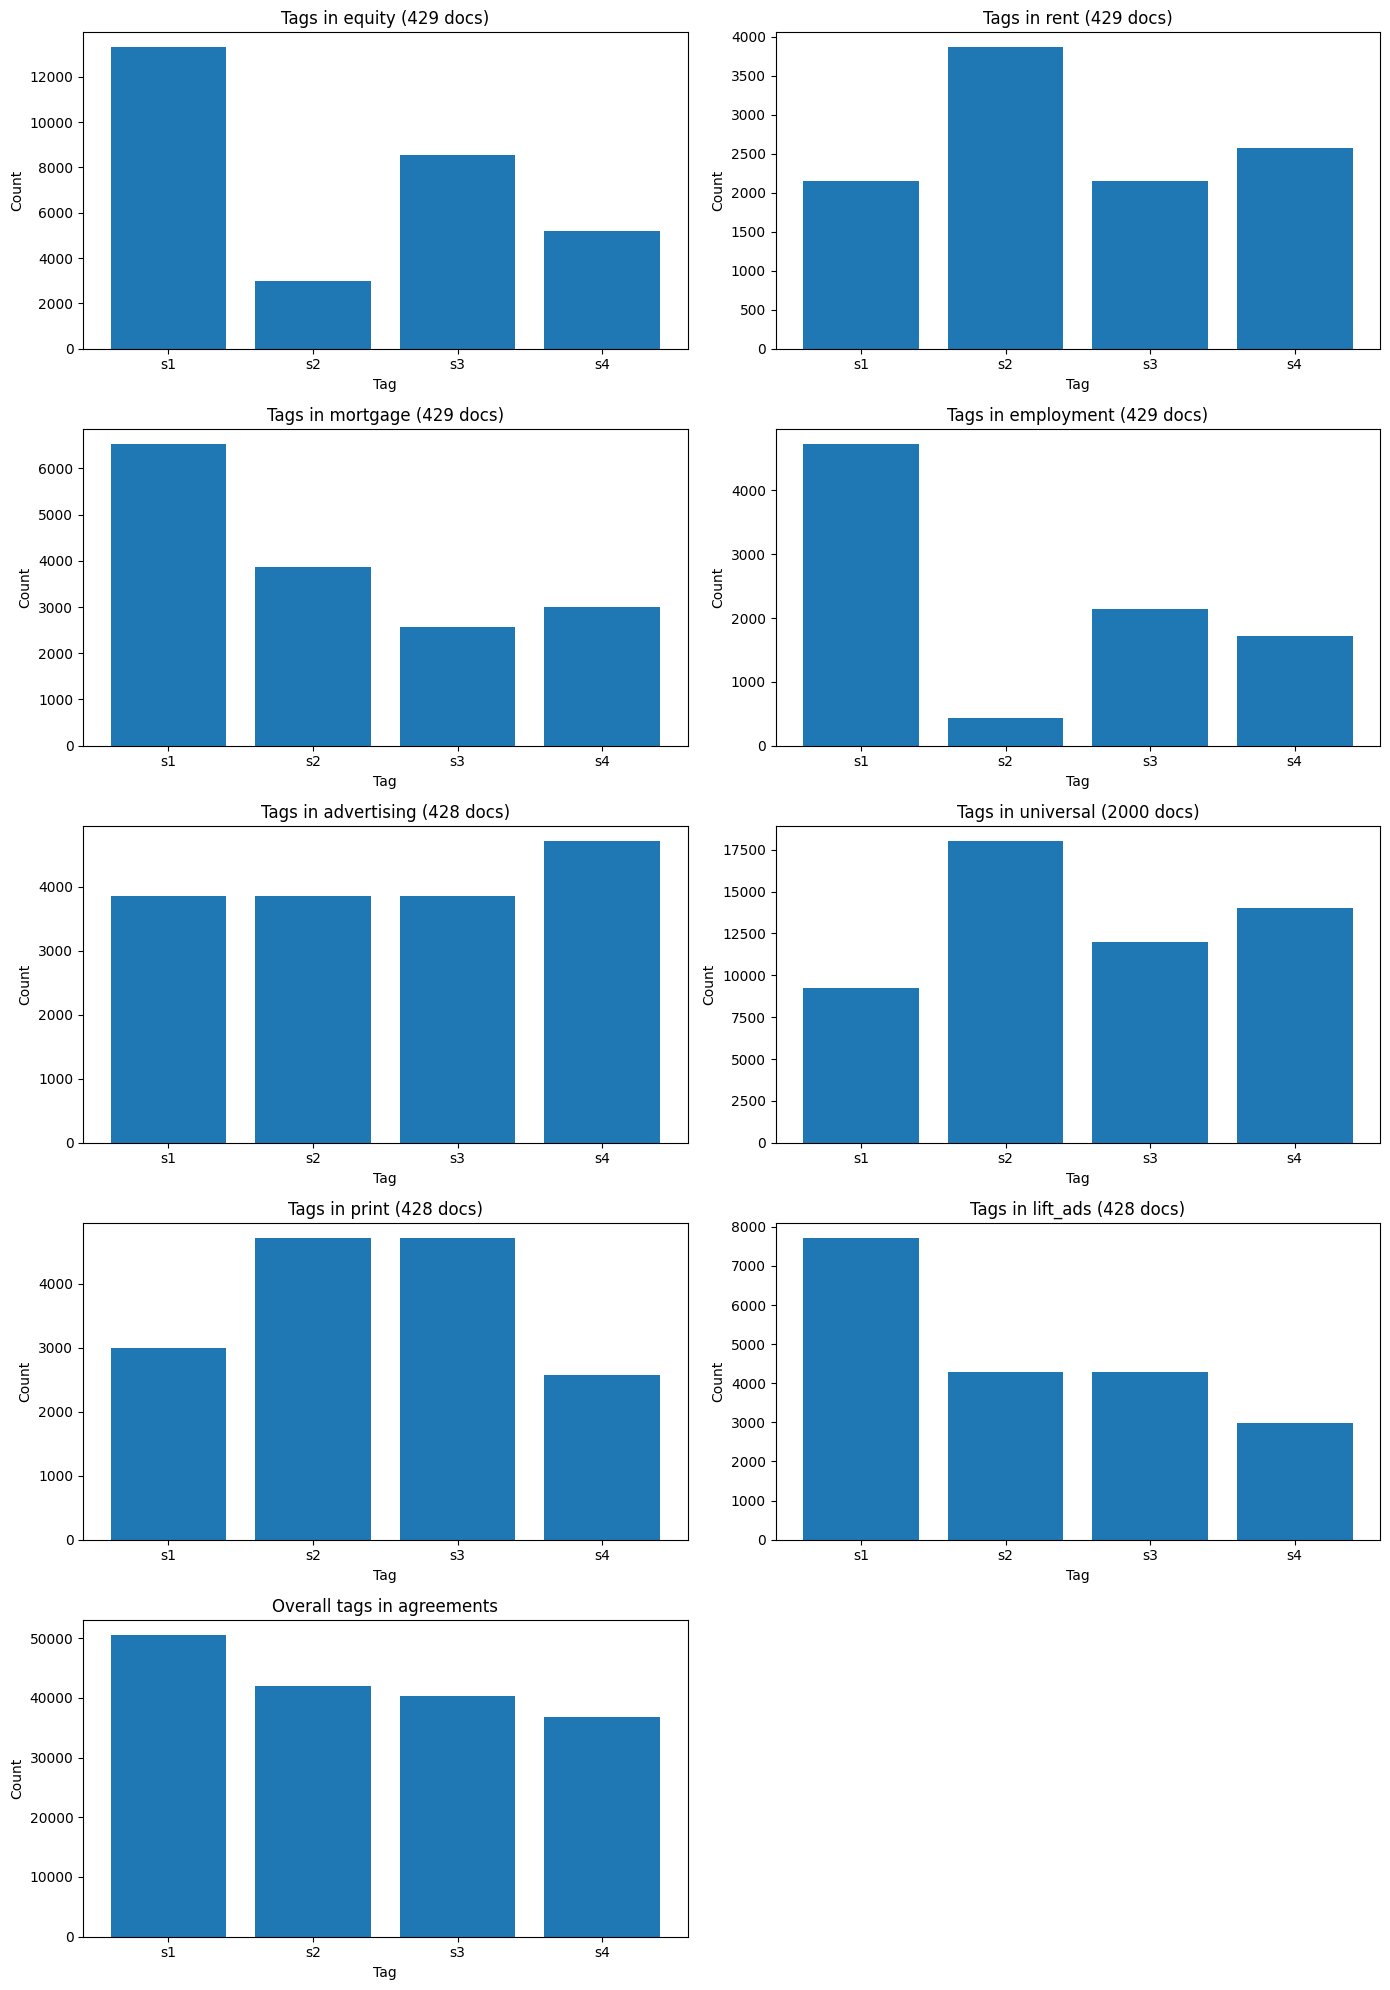

In [ ]:
# Скрипт объединённой генерации договоров, сохранения, перемешивания и визуализации
import os
import json
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# ---------- ПАРАМЕТР: общее число договоров ----------
N = 5000  # <- поставьте нужное число

# ---------- Маппинг генераторов: имена классов и подпапки ----------

GENERATORS = [
    ("EquityContractGenerator", "equity"),        # 1
    ("RentContractGenerator", "rent"),            # 2
    ("MortgageContractGenerator", "mortgage"),    # 3
    ("EmploymentContractGenerator", "employment"),# 4
    ("AdvertisingContractGenerator", "advertising"),#5
    ("UniversalContractGenerator", "universal"),  # 6 (40%)
    ("PrintContractGenerator", "print"),          # 7
    ("LiftAdsContractGenerator", "lift_ads")      # 8
]

# Проверка наличия классов в глобальной области
available = []
for cls_name, folder in GENERATORS:
    cls = globals().get(cls_name)
    if cls is None:
        print(f"⚠️ Класс {cls_name} не найден в окружении — убедитесь, что ячейка с его определением была выполнена.")
    else:
        available.append((cls_name, cls, folder))
if len(available) < len(GENERATORS):
    print("⚠️ Внимание: не все генераторы обнаружены. Скрипт будет работать только с найденными классами.")

# ---------- Распределение числа договоров ----------
# 40% универсальные
universal_share = int(round(N * 0.40))
remaining = N - universal_share

# Остальные типы (включая universal в список GENERATORS)
# Найдём индексы: universal должен идти в GENERATORS, но делим среди остальных 7 типов
other_generators = [item for item in available if item[0] != "UniversalContractGenerator"]
# Если universal не найден, распределяем по найденным.
if any(item[0] == "UniversalContractGenerator" for item in available):
    target_universal = universal_share
else:
    target_universal = 0
num_other = len(other_generators)
if num_other == 0:
    raise RuntimeError("Нет доступных остальных генераторов — нечего распределять.")

base_each = remaining // num_other
extra = remaining % num_other

# Количество для каждого найденного генератора
counts = {}
for i, (cls_name, cls_obj, folder) in enumerate(available):
    if cls_name == "UniversalContractGenerator":
        counts[cls_name] = target_universal
    else:
        counts[cls_name] = base_each + (1 if extra > 0 else 0)
        if extra > 0:
            extra -= 1

print("🔢 План генерации (кол-во договоров на каждый генератор):")
for cls_name, cls_obj, folder in available:
    print(f"  - {cls_name}: {counts.get(cls_name, 0)} -> папка contracts/{folder}/")

# ---------- Утилиты ----------
def call_generator_and_collect(cls_obj, want_count, folder_name):
    """
    Создаёт экземпляр генератора cls_obj, вызывает подходящий метод и возвращает список контрактов в стандартизированной форме:
    {"text":..., "entities": [...], "metadata": {...}}
    Метод пробует варианты:
      - instance.generate_contracts() -> expects list
      - instance.generate_all_contracts()
      - instance.run()
      - instance.generate_contract(i)
      - instance.generate_single_contract(i)
      - instance.generate() (fallback)
    """
    contracts = []
    if want_count <= 0:
        return contracts

    # Создаём экземпляр — пытаемся передать contracts_to_generate, иначе без аргументов
    try:
        inst = cls_obj(contracts_to_generate=want_count)
    except Exception:
        try:
            inst = cls_obj()
        except Exception as e:
            raise RuntimeError(f"Не удалось создать экземпляр {cls_obj}: {e}")

    # 1) try list-returning methods
    for method_name in ("generate_contracts", "generate_all_contracts", "run", "generate"):
        method = getattr(inst, method_name, None)
        if callable(method):
            try:
                res = method()  # may accept no args
                if isinstance(res, list):
                    # If returned list, possibly more than wanted_count — slice
                    for item in res[:want_count]:
                        contracts.append(normalize_contract(item))
                    if len(contracts) >= want_count:
                        return contracts[:want_count]
                else:
                    # If returned single contract, wrap
                    contracts.append(normalize_contract(res))
                    if len(contracts) >= want_count:
                        return contracts[:want_count]
            except TypeError:
                # maybe method needs args — skip to next strategy
                pass
            except Exception as e:
                print(f"Ошибка вызова {cls_obj}.{method_name}(): {e}")
    # 2) try single-item generation in loop
    # prefer generate_contract(i) or generate_single_contract(i)
    for method_name in ("generate_contract", "generate_single_contract"):
        method = getattr(inst, method_name, None)
        if callable(method):
            for i in range(want_count):
                try:
                    item = method(i)
                except TypeError:
                    # try without i
                    item = method()
                contracts.append(normalize_contract(item))
            return contracts[:want_count]

    # 3) last resort: try attribute 'generate_one' or 'generate' with i
    if hasattr(inst, "generate_one"):
        gen_one = getattr(inst, "generate_one")
        for i in range(want_count):
            contracts.append(normalize_contract(gen_one()))
        return contracts[:want_count]

    raise RuntimeError(f"Не найден подходящий метод генерации для класса {cls_obj}. "
                       "Проверьте реализацию генератора и его API.")

def normalize_contract(item):
    """
    Приводит item к форме {"text","entities","metadata"}.
    Если item уже строка или dict partial — стараемся заполнить недостающее.
    """
    if isinstance(item, dict):
        text = item.get("text") or item.get("contract_text") or item.get("full_text") or ""
        entities = item.get("entities") or item.get("annotations") or []
        metadata = item.get("metadata") or item.get("meta") or {}
        return {"text": text, "entities": entities, "metadata": metadata}
    elif isinstance(item, str):
        return {"text": item, "entities": [], "metadata": {}}
    else:
        return {"text": str(item), "entities": [], "metadata": {}}

# ---------- Генерация и запись по подпапкам ----------
ROOT_FOLDER = "contracts"
os.makedirs(ROOT_FOLDER, exist_ok=True)

all_saved = []  # (type_folder, contract_dict)

for cls_name, cls_obj, folder in available:
    want = counts.get(cls_name, 0)
    if want <= 0:
        continue
    out_dir = os.path.join(ROOT_FOLDER, folder)
    os.makedirs(out_dir, exist_ok=True)
    print(f"\n⏳ Генерирую {want} договор(ов) для {cls_name} -> {out_dir}")
    try:
        generated = call_generator_and_collect(cls_obj, want, folder)
    except Exception as e:
        print(f"❌ Ошибка при генерации {cls_name}: {e}")
        generated = []

    # Сохраняем в contracts/<folder>/contracts.jsonl (каждый по одной строке)
    outfile = os.path.join(out_dir, "contracts.jsonl")
    with open(outfile, "w", encoding="utf-8") as f:
        for idx, c in enumerate(generated):
            # сохраняем дополнительно поле source_type и filename_id
            c_record = {
                "text": c["text"],
                "entities": c.get("entities", []),
                "metadata": c.get("metadata", {}),
                "source": folder,
                "_id": f"{folder}_{idx+1}"
            }
            f.write(json.dumps(c_record, ensure_ascii=False) + "\n")
            all_saved.append((folder, c_record))
    print(f"✅ Сохранено {len(generated)} договоров в {outfile}")

# ---------- Объединение в общую папку agreements и перемешивание без соседних одинаковых ----------
AGREEMENTS_DIR = "agreements"
os.makedirs(AGREEMENTS_DIR, exist_ok=True)

# Соберём словарь списков по типу
by_type = defaultdict(list)
for folder, c in all_saved:
    by_type[folder].append(c)

# Greedy no-adjacent shuffle
combined = []
remaining_counts = {k: len(v) for k, v in by_type.items()}
lists = {k: v.copy() for k, v in by_type.items()}  # copy lists

last = None
total_remaining = sum(remaining_counts.values())
while total_remaining > 0:
    # candidates: types with remaining and not equal last
    candidates = [t for t, cnt in remaining_counts.items() if cnt > 0 and t != last]
    if not candidates:
        # only last type remains; append all
        t = last
    else:
        t = random.choice(candidates)
    item = lists[t].pop(0)
    combined.append(item)
    remaining_counts[t] -= 1
    total_remaining -= 1
    last = t

# Save combined
combined_path = os.path.join(AGREEMENTS_DIR, "all_contracts.jsonl")
with open(combined_path, "w", encoding="utf-8") as f:
    for c in combined:
        f.write(json.dumps(c, ensure_ascii=False) + "\n")

print(f"\n📁 Объединено и сохранено {len(combined)} договоров в {combined_path}")

# ---------- Статистика по папкам и по всей коллекции ----------
def compute_stats(contract_list):
    cnt = len(contract_list)
    tags = Counter()
    for c in contract_list:
        for e in c.get("entities", []):
            lbl = e.get("label") if isinstance(e, dict) else None
            if lbl:
                tags[lbl] += 1
    return cnt, tags

print("\n📊 Статистика по подпапкам:")
overall_tags = Counter()
for folder, items in by_type.items():
    cnt, tags = compute_stats(items)
    overall_tags.update(tags)
    print(f"  - {folder}: {cnt} документов; теги: {dict(tags)}")

print("\n📊 Общая статистика (вся папка agreements):")
tot_cnt, tot_tags = compute_stats(combined)
print(f"  Всего документов: {tot_cnt}")
print(f"  Теги: {dict(tot_tags)}")

# ---------- Вывод полного текста первого договора и его entities ----------
if combined:
    first = combined[0]
    print("\n=== ПОЛНЫЙ ТЕКСТ ПЕРВОГО ДОГОВОРА (не сокращая) ===\n")
    print(first["text"])
    print("\n=== Entities первого договора ===")
    for e in first.get("entities", []):
        print(f"  {e.get('label')}: '{e.get('text')}' (позиции {e.get('start')}-{e.get('end')})")

# ---------- Визуализация tag-stats per-folder and overall ----------
# Собираем набор всех папок
folders = list(by_type.keys())
# prepare data for plotting
labels = sorted(list({lbl for tags in [compute_stats(v)[1] for v in by_type.values()] for lbl in tags.keys()}))
if not labels:
    labels = ['s1','s2','s3','s4']

# per-folder counts matrix
folder_tag_counts = {folder: [compute_stats(by_type[folder])[1].get(lbl, 0) for lbl in labels] for folder in folders}
overall_tag_counts = [tot_tags.get(lbl, 0) for lbl in labels]

# Plot: one figure per folder (stacked) and a combined figure
fig, axes = plt.subplots(max(1, len(folders)//2 + 1), 2, figsize=(14, 4 * (max(1, len(folders)//2 + 1))))
axes = axes.flatten() if hasattr(axes, "__len__") else [axes]
for idx, folder in enumerate(folders):
    axes[idx].bar(labels, folder_tag_counts[folder])
    axes[idx].set_title(f"Tags in {folder} ({len(by_type[folder])} docs)")
    axes[idx].set_ylabel("Count")
    axes[idx].set_xlabel("Tag")

# final overall chart in next axis
ax_overall = axes[len(folders)]
ax_overall.bar(labels, overall_tag_counts)
ax_overall.set_title("Overall tags in agreements")
ax_overall.set_ylabel("Count")
ax_overall.set_xlabel("Tag")

# hide unused axes
for j in range(len(folders)+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt_path = os.path.join(AGREEMENTS_DIR, "tags_stats.png")
plt.savefig(plt_path, dpi=150, bbox_inches='tight')
print(f"\n📈 Визуализация сохранена в {plt_path}")
plt.show()


2.11 Загрузка файлов и валидация

✅ Загружено 5000 договоров
📊 Распределение сущностей: {'s4': 36751, 's3': 40244, 's1': 50446, 's2': 41994}
✅ Все сущности корректны!


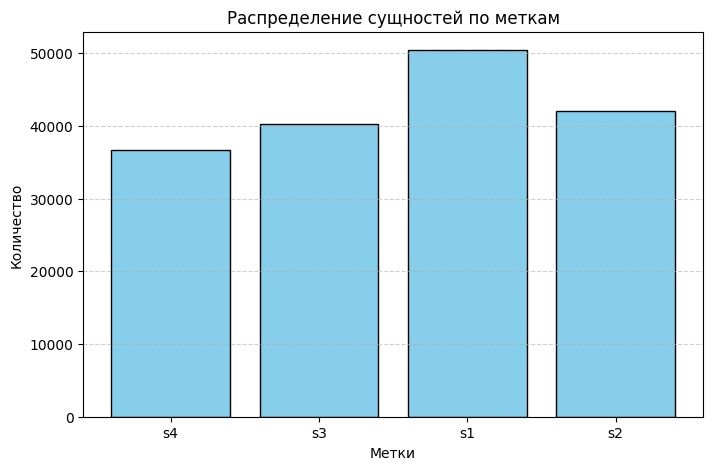

In [ ]:
import json
import os
from collections import Counter
import matplotlib.pyplot as plt

def load_and_validate_agreements(path="agreements"):
    all_contracts = []
    label_counter = Counter()
    errors = []

    for fname in os.listdir(path):
        if not fname.endswith(".jsonl"):
            continue
        with open(os.path.join(path, fname), "r", encoding="utf-8") as f:
            for line in f:
                contract = json.loads(line)
                text = contract["text"]
                for ent in contract["entities"]:
                    start, end = ent["start"], ent["end"]
                    extracted = text[start:end]
                    if extracted != ent["text"]:
                        errors.append({
                            "file": fname,
                            "entity": ent,
                            "extracted": extracted
                        })
                    label_counter[ent["label"]] += 1
                all_contracts.append(contract)

    print(f"✅ Загружено {len(all_contracts)} договоров")
    print(f"📊 Распределение сущностей: {dict(label_counter)}")
    if errors:
        print(f"⚠️ Найдено {len(errors)} ошибок разметки. Пример:")
        print(errors[0])
    else:
        print("✅ Все сущности корректны!")

    # Визуализация
    if label_counter:
        labels, values = zip(*label_counter.items())
        plt.figure(figsize=(8, 5))
        plt.bar(labels, values, color="skyblue", edgecolor="black")
        plt.title("Распределение сущностей по меткам")
        plt.xlabel("Метки")
        plt.ylabel("Количество")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()

    return all_contracts

# 🚀 Запуск
contracts = load_and_validate_agreements("agreements")


# 3. Параметризация данных

3.1 Создание X, Y

Скрипт итает jsonl с токенами и метками. Применяет очистку, lower, (опционально) лемматизацию. Преобразует в последовательность символов, размечает каждый символ меткой слова. Сохраняет X/Y (char-level) и формирует таблицу "символ — метка" для примера договора (char_table_example.txt).


In [ ]:
# Установка необходимых библиотек Natasha
print("Попытка установки Natasha и pymorphy3...")
!pip install natasha
!pip install pymorphy3 pymorphy3-dicts-ru
print("Установка завершена. Инициализация Natasha...")

import json
import re
from pathlib import Path
import re
try:
    from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
    # Инициализация компонентов Natasha, если доступны
    segmenter = Segmenter()
    morph_vocab = MorphVocab()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    NATASHA_OK = True
    print("Natasha успешно инициализирована.")
except ImportError:
    # Natasha является опциональной, устанавливаем флаг в False, если не установлена
    NATASHA_OK = False
    print("Ошибка: Natasha или ее компоненты не были успешно импортированы. Лемматизация будет недоступна.")


# Определение путей для входных и выходных файлов
INPUT_JSONL = "/content/drive/MyDrive/agreements/all_contracts_fixed_corrected_v4.jsonl"
X_OUT = "/content/drive/MyDrive/agreements/xTrain_BiLSTM_sync.txt"
Y_OUT = "/content/drive/MyDrive/agreements/yTrain_BiLSTM_sync.txt"
EXAMPLE_OUT = "/content/drive/MyDrive/agreements/char_table_example.txt"

"""
Функция препроцессинга для инференса BiLSTM NER (совместима с train/infer и UI)
- Приведение к нижнему регистру
- Удаление спецсимволов и лишних пробелов
- Лемматизация с Natasha (обязательно)
"""

def preprocess_bilstm_infer(text):
    """
    Выполняет препроцессинг входного текста для инференса BiLSTM NER.
    Включает приведение к нижнему регистру, удаление спецсимволов (сохраняя '%'),
    нормализацию пробелов и ОБЯЗАТЕЛЬНУЮ лемматизацию с использованием Natasha.

    Args:
        text (str): Входной текст.

    Returns:
        str: Препроцессированный текст.

    Raises:
        RuntimeError: Если Natasha недоступна, а лемматизация обязательна.
    """
    # Проверка, что Natasha доступна для обязательной лемматизации
    if not NATASHA_OK:
        raise RuntimeError("Ошибка: Лемматизация Natasha является обязательной, но библиотека не была успешно импортирована.")

    # Замена символов, кроме букв, пробелов и '%' на пробелы. Символ '%' сохраняется.
    text = re.sub(r'[^\w\sа-яёА-ЯЁ%]', ' ', text)
    # Замена подчеркиваний на пробелы
    text = text.replace('_', ' ')
    # Приведение текста к нижнему регистру
    text = text.lower()

    # Применение лемматизации с Natasha
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    # Объединение лемм обратно в строку
    text = ' '.join([t.lemma for t in doc.tokens])

    # Нормализация пробелов (замена нескольких пробелов на один, удаление начальных/конечных пробелов)
    text = ' '.join(text.split())
    return text


# --- Устаревшая функция, сохранена для контекста, но не используется в новой логике ---
def word_labels_to_char_labels(tokens, labels):
    """
    Преобразует токены и метки на уровне слов в данные на уровне символов.
    Эта функция в основном используется для исторического контекста и не применяется
    активно в текущем процессе препроцессинга на уровне символов.
    """
    chars = []
    char_labels = []
    for token, label in zip(tokens, labels):
        for c in token:
            chars.append(c)
            char_labels.append(label)
        chars.append(' ')  # Добавляем пробел как разделитель
        char_labels.append('O')  # Пробелы всегда являются сущностями типа 'O' (Вне сущности)
    if chars:
        chars = chars[:-1]  # Удаляем завершающий пробел
        char_labels = char_labels[:-1]
    return chars, char_labels

# Новая вспомогательная функция для преобразования текста и сущностей в символьные X и Y
def get_char_data_with_preprocessing(original_text, entities):
    """
    Обрабатывает исходный текст и связанные с ним сущности для получения
    характеристик (X) и меток (Y) на уровне символов после применения правил препроцессинга.
    Обеспечивает выравнивание меток даже после преобразований текста, таких как приведение
    к нижнему регистру, удаление спецсимволов и нормализация пробелов.

    Args:
        original_text (str): Исходный входной текст.
        entities (list): Список словарей сущностей, каждый с 'label', 'start' и 'end'.

    Returns:
        tuple: Кортеж, содержащий обработанную символьную строку (X) и
               ее метки на уровне символов, разделенные пробелами (Y).
    """
    # Шаг 1: Создаем начальные символьные метки для исходного текста на основе диапазонов сущностей
    original_char_labels = ['O'] * len(original_text)
    for ent in entities:
        label = ent['label']
        start = ent['start']
        end = ent['end']
        # Присваиваем метку сущности каждому символу в ее диапазоне
        for i in range(start, end):
            if 0 <= i < len(original_text):
                original_char_labels[i] = label

    # Шаг 2: Применяем препроцессинг на уровне символов и выравниваем метки
    current_text_chars = []
    current_labels_chars = []

    for i, char in enumerate(original_text):
        original_label = original_char_labels[i]
        processed_char = char.lower() # Преобразуем символ в нижний регистр

        # Заменяем символы, кроме букв, пробелов, русских символов и '%' на пробел
        # Символ '%' сохраняется.
        if re.match(r'[^\w\sа-яёА-ЯЁ%]', processed_char):
            current_text_chars.append(' ')
            current_labels_chars.append('O') # Метка пробела всегда 'O'
        # Заменяем подчеркивания на пробелы
        elif processed_char == '_':
            current_text_chars.append(' ')
            current_labels_chars.append('O') # Метка пробела всегда 'O'
        else:
            # Сохраняем символ и его исходную метку, если он валиден
            current_text_chars.append(processed_char)
            current_labels_chars.append(original_label)

    # Шаг 3: Нормализуем пробелы в обработанном тексте и повторно выравниваем метки
    final_chars = []
    final_labels = []

    # Временно объединяем символы для разделения по любому пробелу, эффективно нормализуя пробелы
    temp_str = "".join(current_text_chars)
    words = temp_str.split() # Разделяет по любому пробелу и удаляет пустые строки

    current_idx_in_temp_str = 0
    for word_idx, word in enumerate(words):
        # Находим начальный индекс текущего слова в 'temp_str' для правильного сопоставления меток
        start_of_word_in_temp = temp_str.find(word, current_idx_in_temp_str)
        end_of_word_in_temp = start_of_word_in_temp + len(word)

        for i in range(start_of_word_in_temp, end_of_word_in_temp):
            final_chars.append(temp_str[i])
            # Извлекаем выровненную метку из 'current_labels_chars' с использованием ее индекса в 'temp_str'
            final_labels.append(current_labels_chars[i])

        # Добавляем один пробел между словами и помечаем его 'O'
        if word_idx < len(words) - 1:
            final_chars.append(' ')
            final_labels.append('O')

        # Обновляем индекс для следующего поиска слова в 'temp_str'
        current_idx_in_temp_str = end_of_word_in_temp

    # Возвращаем обработанную символьную строку и ее метки, разделенные пробелами
    return "".join(final_chars), " ".join(final_labels)

def main():
    """
    Основная функция для загрузки данных о договорах, их препроцессинга, извлечения
    характеристик (X) и меток (Y) на уровне символов, сохранения их в файлы, а также
    опциональной генерации таблицы-примера и вывода частей выходных файлов.
    """
    with open(INPUT_JSONL, encoding='utf8') as f:
        lines = f.readlines()
    X, Y = [], []
    example_found = False
    for line_num, line in enumerate(lines):
        try:
            obj = json.loads(line)

            # Извлекаем 'text' и 'entities' из JSON-объекта
            original_text = obj['text']
            entities = obj['entities']

            # Получаем данные на уровне символов с препроцессингом и выравниванием меток
            chars_str, char_labels_str = get_char_data_with_preprocessing(original_text, entities)

            # Пропускаем, если после очистки не осталось значимых символов
            if not chars_str:
                continue

            X.append(chars_str)
            Y.append(char_labels_str)

            # Генерируем таблицу символ-метка для первого документа, содержащего 'договор'
            if not example_found and 'договор' in chars_str.lower():
                with open(EXAMPLE_OUT, 'w', encoding='utf8') as fe:
                    fe.write('Символ\tМетка\n')
                    labels_list = char_labels_str.split()
                    if len(chars_str) == len(labels_list):
                        for c, l in zip(chars_str, labels_list):
                            fe.write(f'{c}\t{l}\n')
                    else:
                        fe.write(f"Error: Label list length mismatch for example: {len(chars_str)} chars vs {len(labels_list)} labels")
                example_found = True
        except Exception as e:
            print(f"Ошибка при обработке строки {line_num}: {e}")
            continue # Продолжаем обрабатывать другие строки, если одна не удалась

    # Сохраняем обработанные характеристики (X) и метки (Y) в соответствующие выходные файлы
    with open(X_OUT, 'w', encoding='utf8') as fx, open(Y_OUT, 'w', encoding='utf8') as fy:
        for x, y in zip(X, Y):
            fx.write(x + '\n')
            fy.write(y + '\n')
    print(f'Готово! Сохранено {len(X)} примеров. Таблица символ-метка для договора: {EXAMPLE_OUT}')

    # --- Вывод содержимого сгенерированных файлов по запросу ---
    print("\n--- Содержимое char_table_example.txt (полный договор): ---")
    with open(EXAMPLE_OUT, 'r', encoding='utf8') as f:
        print(f.read())

    print("\n--- Содержимое xTrain_BiLSTM_sync.txt (первые 250 символов): ---")
    with open(X_OUT, 'r', encoding='utf8') as f:
        print(f.read(250))

    print("\n--- Содержимое yTrain_BiLSTM_sync.txt (первые 250 символов): ---")
    with open(Y_OUT, 'r', encoding='utf8') as f:
        print(f.read(250))

    # Вывод размерностей X и Y
    print(f"\n--- Размерности X и Y ---")
    print(f"Количество примеров в X: {len(X)}")
    print(f"Количество примеров в Y: {len(Y)}")

if __name__ == "__main__":
    main()

Попытка установки Natasha и pymorphy3...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 108.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=31dccff71dcc194274adfe83eab387908821bde6bc86f338d8ce58a96dd3b02f
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 87.6 MB/s eta 0:00:00
Установка завершена. Инициализация Natasha...
Natasha успешно инициализирована.
Готово! Сохранено 5000 примеров. Таблица символ-метка для договора: /content/drive/

3.2 Преобразование X, Y в индексы

Скрипт читает xTrain_BiLSTM_sync.txt и yTrain_BiLSTM_sync.txt. Строит char_vocab.json и label_vocab.json. Преобразует символы и метки в индексы, паддит до MAX_LEN. Сохраняет xTrain_BiLSTM_idx.txt и yTrain_BiLSTM_padded.txt.





In [ ]:
import json
from collections import Counter
from pathlib import Path

# Определение путей для входных и выходных файлов
X_IN = "/content/drive/MyDrive/agreements/xTrain_BiLSTM_sync.txt"
Y_IN = "/content/drive/MyDrive/agreements/yTrain_BiLSTM_sync.txt"
X_IDX_OUT = "/content/drive/MyDrive/agreements/bilstm/xTrain_BiLSTM_idx.txt"
Y_IDX_OUT = "/content/drive/MyDrive/agreements/bilstm/yTrain_BiLSTM_padded.txt"
CHAR_VOCAB_OUT = "/content/drive/MyDrive/agreements/bilstm/char_vocab.json"
LABEL_VOCAB_OUT = "/content/drive/MyDrive/agreements/bilstm/label_vocab.json"
MAX_LEN = 256

print("=" * 80)
print("КОД ДЛЯ ПОСИМВОЛЬНОЙ ОБРАБОТКИ")
print("=" * 80)

# Создаём папку для выходных файлов
output_dir = Path(Y_IDX_OUT).parent
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Собираем счетчики с ПРАВИЛЬНОЙ обработкой символов
print("\n1. ОБРАБОТКА СИМВОЛОВ")
print("-" * 40)

char_counter = Counter()
label_counter = Counter()
X_lines = []
Y_lines = []
problem_lines = []

with open(X_IN, encoding='utf-8') as fx, open(Y_IN, encoding='utf-8') as fy:
    for line_num, (x_line, y_line) in enumerate(zip(fx, fy), 1):

        # X - разбиваем на символы (list), Y - разбиваем на метки (split)
        x_chars = list(x_line.strip())  # ✅ ПРАВИЛЬНО: строка → список символов
        y_labels = y_line.strip().split()  # ✅ Разбиваем на метки по пробелам

        # Проверяем длину
        if len(x_chars) != len(y_labels):
            problem_lines.append({
                'line': line_num,
                'x_len': len(x_chars),
                'y_len': len(y_labels),
                'x_preview': ''.join(x_chars[:50]) + ('...' if len(x_chars) > 50 else ''),
                'y_preview': ' '.join(y_labels[:50]) + ('...' if len(y_labels) > 50 else '')
            })
            print(f"  ⚠️  Строка {line_num}: X={len(x_chars)} симв., Y={len(y_labels)} меток")
            # Показываем различия
            print(f"     X (символы): {repr(''.join(x_chars[:30]))}")
            print(f"     Y (метки): {' '.join(y_labels[:30])}")
            continue

        # добавляем
        char_counter.update(x_chars)
        label_counter.update(y_labels)
        X_lines.append(x_chars)
        Y_lines.append(y_labels)

print(f"\n   ✓ Обработано строк: {len(X_lines)} из {len(X_lines) + len(problem_lines)}")
print(f"   ⚠️  Проблемных строк: {len(problem_lines)}")

# 2. Если есть проблемы, покажем детали
if problem_lines:
    print("\n🔍 ДИАГНОСТИКА ПЕРВОЙ ПРОБЛЕМНОЙ СТРОКИ:")
    print("-" * 60)

    # Более детальный анализ
    print(f"Строка {problem_lines[0]['line']}:")
    x_chars = problem_lines[0]['x_preview']
    y_labels = problem_lines[0]['y_preview'].split()

    print(f"Первые 20 символов X (с кодами):")
    for i, char in enumerate(x_chars[:20]):
        print(f"  [{i}] '{char}' (код: {ord(char)})")

    print(f"\nПервые 20 меток Y:")
    for i, label in enumerate(y_labels[:20]):
        print(f"  [{i}] {label}")

    print("\n🎯 ВЕРОЯТНЫЕ ПРИЧИНЫ:")
    print("  1. В X файле есть лишние пробелы или спецсимволы")
    print("  2. В Y файле неправильное количество меток")
    print("  3. Проблемы с кодировкой или переносами строк")

# 3. Строим словари
print("\n2. СОЗДАНИЕ СЛОВАРЕЙ")
print("-" * 40)

# Counter
label_order = sorted([label for label in label_counter if label != 'O'])

special_chars = ['<PAD>', '<UNK>']
char2idx = {c: i for i, c in enumerate(special_chars + list(char_counter))}
idx2char = {i: c for c, i in char2idx.items()}

# Метка 'O' всегда первая
label2idx = {'O': 0}
for i, label in enumerate(label_order):
    label2idx[label] = i + 1
idx2label = {i: l for l, i in label2idx.items()}

print(f"   Размер словаря символов: {len(char2idx)}")
print(f"   Размер словаря меток: {len(label2idx)}")
print(f"   Соответствие меток: {label2idx}")

# 4. Сохраняем словари
with open(CHAR_VOCAB_OUT, 'w', encoding='utf-8') as f:
    json.dump(char2idx, f, ensure_ascii=False, indent=2)
with open(LABEL_VOCAB_OUT, 'w', encoding='utf-8') as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=2)

print(f"\n   ✓ Словари сохранены:")
print(f"     Символы: {CHAR_VOCAB_OUT}")
print(f"     Метки: {LABEL_VOCAB_OUT}")


# 5. Индексация и паддинг
print("\n4. ИНДЕКСАЦИЯ, РАЗДЕЛЕНИЕ НА ЧАНКИ И ПАДДИНГ")
print("-" * 40)

processed_count = 0
total_chunks = 0
chunks_per_sequence = []
max_chunk_length = 0

# Функция для проверки, разрывает ли позиция сущность
def is_breaking_entity(y_labels, pos):
    """Проверяет, разрывает ли позиция pos какую-либо сущность"""
    if pos >= len(y_labels):
        return False

    # Если в позиции pos метка 'O' - не разрываем сущность
    if y_labels[pos] == 'O':
        return False

    # Если pos == 0, то нечего разрывать
    if pos == 0:
        return False

    # Если предыдущая метка отличается от текущей - это граница сущности
    if y_labels[pos-1] != y_labels[pos]:
        return False

    # Иначе - разрываем сущность
    return True

def find_safe_boundary(y_labels, start, end):
    """Находит безопасную границу для разделения, не разрывая сущности"""
    # Если конец последовательности - безопасно
    if end >= len(y_labels):
        return end

    # Пробуем сдвигать границу назад, пока не найдем безопасное место
    for offset in range(256):
        check_pos = end - offset
        if check_pos <= start:
            break

        # Безопасная граница - где метка 'O' или начало новой сущности
        if y_labels[check_pos] == 'O':
            return check_pos
        # Если это начало новой сущности (метка отличается от предыдущей)
        if check_pos > 0 and y_labels[check_pos] != y_labels[check_pos-1]:
            return check_pos

    # Если не нашли безопасную границу - разрываем в end (вынужденно)
    return end

with open(X_IDX_OUT, 'w', encoding='utf-8') as fx, open(Y_IDX_OUT, 'w', encoding='utf-8') as fy:
    for i, (x_chars, y_labels) in enumerate(zip(X_lines, Y_lines), 1):
        seq_len = len(x_chars)
        chunks_in_seq = 0

        start = 0
        while start < seq_len:
            # Определяем конец чанка (максимум 256 символов)
            end = min(start + MAX_LEN, seq_len)

            # Проверяем, не разрываем ли мы сущность
            if end < seq_len and is_breaking_entity(y_labels, end):
                # Ищем безопасную границу
                safe_end = find_safe_boundary(y_labels, start, end)
                if safe_end > start:  # Нашли безопасную границу
                    end = safe_end
                # Иначе разрываем вынужденно (сущность длиннее 256 символов)

            # Берем чанк
            chunk_x = x_chars[start:end]
            chunk_y = y_labels[start:end]

            # Преобразуем в индексы
            x_idx = [char2idx.get(c, char2idx['<UNK>']) for c in chunk_x]
            y_idx = [label2idx[l] for l in chunk_y]

            # Паддинг
            pad_len = MAX_LEN - len(x_idx)
            x_idx += [char2idx['<PAD>']] * pad_len
            y_idx += [label2idx['O']] * pad_len

            # Записываем
            fx.write(' '.join(map(str, x_idx)) + '\n')
            fy.write(' '.join(map(str, y_idx)) + '\n')

            # Статистика
            processed_count += 1
            chunks_in_seq += 1
            max_chunk_length = max(max_chunk_length, len(chunk_x))

            # Смещаемся на длину чанка (без overlap)
            start = end

        chunks_per_sequence.append(chunks_in_seq)

        # Показываем прогресс
        if i % 500 == 0:
            print(f"   Обработано {i} последовательностей...")

print(f"\n   ✓ Обработано последовательностей: {len(X_lines)}")
print(f"   ✓ Создано чанков: {processed_count}")
print(f"   📊 Статистика чанков:")
print(f"      Максимальная длина чанка: {max_chunk_length} символов")
print(f"      Среднее чанков на последовательность: {sum(chunks_per_sequence)/len(chunks_per_sequence):.1f}")
print(f"      Минимум чанков в последовательности: {min(chunks_per_sequence)}")
print(f"      Максимум чанков в последовательности: {max(chunks_per_sequence)}")

# ========== ДОБАВЬТЕ ЭТУ ЧАСТЬ ПОСЛЕ ОСНОВНОГО КОДА ==========

print("\n" + "=" * 80)
print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ О РАЗДЕЛЕНИИ")
print("=" * 80)

# Распределение чанков по последовательностям
print("\n📈 РАСПРЕДЕЛЕНИЕ ЧАНКОВ ПО ПОСЛЕДОВАТЕЛЬНОСТЯМ:")
chunk_distribution = {}
for chunks in chunks_per_sequence:
    chunk_distribution[chunks] = chunk_distribution.get(chunks, 0) + 1

for chunks in sorted(chunk_distribution.keys()):
    print(f"   {chunks} чанков: {chunk_distribution[chunks]} последовательностей")

# Примеры обработанных данных
print("\n🔍 ПРИМЕРЫ ОБРАБОТАННЫХ ДАННЫХ:")
print("-" * 40)

# Читаем первые 5 чанков
print("Первые 5 чанков из X файла (первые 30 индексов каждого):")
with open(X_IDX_OUT, 'r', encoding='utf-8') as f:
    for i in range(min(5, processed_count)):
        line = f.readline().strip()
        indices = list(map(int, line.split()))[:30]
        # Преобразуем обратно в символы для наглядности
        chars = [idx2char.get(idx, '?') for idx in indices]
        print(f"Чанк {i+1}:")
        print(f"  Индексы: {' '.join(map(str, indices))}")
        print(f"  Символы: {''.join(chars)}")
        print()

print("\nПервые 5 чанков из Y файла (первые 30 индексов каждого):")
with open(Y_IDX_OUT, 'r', encoding='utf-8') as f:
    for i in range(min(5, processed_count)):
        line = f.readline().strip()
        indices = list(map(int, line.split()))[:30]
        # Преобразуем обратно в метки для наглядности
        labels = [idx2label.get(idx, '?') for idx in indices]
        print(f"Чанк {i+1}:")
        print(f"  Индексы: {' '.join(map(str, indices))}")
        print(f"  Метки: {' '.join(labels)}")
        print()

# Статистика по паддингу
print("\n📊 СТАТИСТИКА ПАДДИНГА:")
total_padded = 0
total_chars = 0

with open(X_IDX_OUT, 'r', encoding='utf-8') as f:
    for line in f:
        indices = list(map(int, line.strip().split()))
        # Считаем паддинг (индекс <PAD>)
        pad_count = indices.count(char2idx['<PAD>'])
        total_padded += pad_count
        total_chars += len(indices)

print(f"   Всего символов в чанках: {total_chars}")
print(f"   Символов паддинга: {total_padded} ({total_padded/total_chars*100:.1f}%)")
print(f"   Реальных символов: {total_chars - total_padded}")

print("\n" + "=" * 80)
print(f"ИТОГО: Из {len(X_lines)} длинных последовательностей создано {processed_count} чанков")
print(f"       Средний размер чанка: {(total_chars - total_padded)/processed_count:.1f} символов")
print("=" * 80)

# Дополнительно: сохраняем статистику
STATS_OUT = "/content/drive/MyDrive/agreements/bilstm/splitting_stats.json"
stats = {
    "original_sequences": len(X_lines),
    "total_chunks": processed_count,
    "chunks_per_sequence_avg": sum(chunks_per_sequence)/len(chunks_per_sequence),
    "chunks_distribution": chunk_distribution,
    "max_chunk_length": max_chunk_length,
    "padding_percentage": total_padded/total_chars*100
}

with open(STATS_OUT, 'w', encoding='utf-8') as f:
    json.dump(stats, f, ensure_ascii=False, indent=2)

print(f"\n📄 Статистика сохранена в: {STATS_OUT}")

КОД ДЛЯ ПОСИМВОЛЬНОЙ ОБРАБОТКИ

1. ОБРАБОТКА СИМВОЛОВ
----------------------------------------

   ✓ Обработано строк: 5000 из 5000
   ⚠️  Проблемных строк: 0

2. СОЗДАНИЕ СЛОВАРЕЙ
----------------------------------------
   Размер словаря символов: 49
   Размер словаря меток: 5
   Соответствие меток: {'O': 0, 's1': 1, 's2': 2, 's3': 3, 's4': 4}

   ✓ Словари сохранены:
     Символы: /content/drive/MyDrive/agreements/bilstm/char_vocab.json
     Метки: /content/drive/MyDrive/agreements/bilstm/label_vocab.json

4. ИНДЕКСАЦИЯ, РАЗДЕЛЕНИЕ НА ЧАНКИ И ПАДДИНГ
----------------------------------------
   Обработано 500 последовательностей...
   Обработано 1000 последовательностей...
   Обработано 1500 последовательностей...
   Обработано 2000 последовательностей...
   Обработано 2500 последовательностей...
   Обработано 3000 последовательностей...
   Обработано 3500 последовательностей...
   Обработано 4000 последовательностей...
   Обработано 4500 последовательностей...
   Обработано 5000 пос

3.3 Проверка созданных файлов с чанками

In [ ]:
import os
import json
from collections import Counter

print("=" * 80)
print("ПРОВЕРКА СОЗДАННЫХ ФАЙЛОВ С ЧАНКАМИ")
print("=" * 80)

# 1. Загружаем словари
print("\n1. ЗАГРУЖАЕМ СЛОВАРИ:")
print("-" * 40)

with open(CHAR_VOCAB_OUT, 'r', encoding='utf-8') as f:
    char2idx = json.load(f)
    idx2char = {int(v): k for k, v in char2idx.items()}  # Преобразуем ключи в int

with open(LABEL_VOCAB_OUT, 'r', encoding='utf-8') as f:
    label2idx = json.load(f)
    idx2label = {int(v): k for k, v in label2idx.items()}  # Преобразуем ключи в int

print(f"   Размер словаря символов: {len(char2idx)}")
print(f"   Размер словаря меток: {len(label2idx)}")
print(f"   Соответствие меток: {label2idx}")
print(f"   Первые 10 символов словаря:")
for i, (char, idx) in enumerate(list(char2idx.items())[:10]):
    print(f"     '{char}': {idx}")

# 2. Проверяем размеры файлов
print("\n2. РАЗМЕРЫ ФАЙЛОВ:")
print("-" * 40)

# Количество строк (чанков)
def count_lines(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return sum(1 for _ in f)

x_lines = count_lines(X_IDX_OUT)
y_lines = count_lines(Y_IDX_OUT)

print(f"   X файл ({X_IDX_OUT}):")
print(f"     Количество чанков: {x_lines:,}")
print(f"     Размер файла: {os.path.getsize(X_IDX_OUT):,} байт")

print(f"\n   Y файл ({Y_IDX_OUT}):")
print(f"     Количество чанков: {y_lines:,}")
print(f"     Размер файла: {os.path.getsize(Y_IDX_OUT):,} байт")

# Проверяем соответствие
if x_lines == y_lines:
    print(f"\n   ✓ Количество чанков совпадает!")
else:
    print(f"\n   ⚠️  Несоответствие: X имеет {x_lines}, Y имеет {y_lines} чанков")

# 3. Проверяем структуру чанков
print("\n3. СТРУКТУРА ЧАНКОВ:")
print("-" * 40)

with open(X_IDX_OUT, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()
    x_indices = list(map(int, first_line.split()))

print(f"   Длина каждого чанка: {len(x_indices)} индексов")
print(f"   Ожидаемая длина: {MAX_LEN}")

# Проверяем, что длина соответствует MAX_LEN
if len(x_indices) == MAX_LEN:
    print(f"   ✓ Длина чанков правильная")
else:
    print(f"   ⚠️  Неправильная длина: {len(x_indices)} вместо {MAX_LEN}")

# 4. Статистика по индексам
print("\n4. СТАТИСТИКА ПО ИНДЕКСАМ:")
print("-" * 40)

# Анализируем первые 1000 чанков
sample_size = min(1000, x_lines)
x_sample_indices = []
y_sample_indices = []

with open(X_IDX_OUT, 'r', encoding='utf-8') as fx, open(Y_IDX_OUT, 'r', encoding='utf-8') as fy:
    for i, (x_line, y_line) in enumerate(zip(fx, fy)):
        if i >= sample_size:
            break
        x_sample_indices.extend(map(int, x_line.strip().split()))
        y_sample_indices.extend(map(int, y_line.strip().split()))

print(f"   Проанализировано {sample_size} чанков ({sample_size * MAX_LEN:,} позиций)")

# Статистика по X
x_counter = Counter(x_sample_indices)
print(f"\n   Топ-10 самых частых индексов в X:")
for idx, count in x_counter.most_common(10):
    char = idx2char.get(idx, 'UNKNOWN')
    print(f"     {idx} ('{char}'): {count:,} раз ({count/len(x_sample_indices)*100:.1f}%)")

# Статистика по Y
y_counter = Counter(y_sample_indices)
print(f"\n   Топ-10 самых частых индексов в Y:")
for idx, count in y_counter.most_common(10):
    label = idx2label.get(idx, 'UNKNOWN')
    print(f"     {idx} ('{label}'): {count:,} раз ({count/len(y_sample_indices)*100:.1f}%)")

# 5. Примеры чанков с детальной расшифровкой
print("\n5. ПОДРОБНЫЕ ПРИМЕРЫ ЧАНКОВ:")
print("-" * 40)

def decode_chunk(x_indices, y_indices, max_chars=50):
    """Декодирует чанк в читаемый формат"""
    chars = [idx2char.get(idx, '?') for idx in x_indices]
    labels = [idx2label.get(idx, '?') for idx in y_indices]

    # Находим реальные данные (до паддинга)
    real_chars = []
    real_labels = []

    for i, (char, label) in enumerate(zip(chars, labels)):
        if char == '<PAD>' or label == 'O' and char == '<PAD>':
            break
        real_chars.append(char)
        real_labels.append(label)

    return real_chars, real_labels

# Читаем и декодируем первые 3 чанка
print(f"Первые 3 чанка из {x_lines:,}:")

with open(X_IDX_OUT, 'r', encoding='utf-8') as fx, open(Y_IDX_OUT, 'r', encoding='utf-8') as fy:
    for chunk_num in range(1, 4):
        x_line = fx.readline().strip()
        y_line = fy.readline().strip()

        if not x_line or not y_line:
            break

        x_indices = list(map(int, x_line.split()))
        y_indices = list(map(int, y_line.split()))

        chars, labels = decode_chunk(x_indices, y_indices)

        print(f"\n{'='*60}")
        print(f"ЧАНК #{chunk_num}")
        print(f"Длина реальных данных: {len(chars)} символов")
        print(f"Длина с паддингом: {len(x_indices)} символов")

        # Выводим текст с цветовой кодировкой меток
        print(f"\nТЕКСТ (первые 100 символов):")
        text = ''.join(chars[:100])

        # Создаем цветовую кодировку для консоли
        color_map = {
            'O': '',           # без цвета
            's1': '\033[94m',  # синий
            's2': '\033[91m',  # красный
            's3': '\033[93m',  # желтый
            's4': '\033[92m',  # зеленый
        }
        reset_color = '\033[0m'

        colored_text = ""
        for i, (char, label) in enumerate(zip(chars[:100], labels[:100])):
            color = color_map.get(label, '')
            colored_text += f"{color}{char}{reset_color}"

        print(colored_text)

        print(f"\nМЕТКИ (первые 100):")
        labels_str = ' '.join(labels[:100])
        # Группируем для лучшей читаемости
        groups = []
        current_label = None
        count = 0

        for label in labels[:100]:
            if label != current_label:
                if current_label is not None:
                    groups.append(f"{current_label}({count})")
                current_label = label
                count = 1
            else:
                count += 1
        if current_label:
            groups.append(f"{current_label}({count})")

        print(f"Группы: {' '.join(groups)}")

        print(f"\nСООТВЕТСТВИЕ (первые 30 позиций):")
        print("Поз | Символ (код) | Метка")
        print("-" * 40)
        for i in range(min(30, len(chars))):
            char = chars[i]
            label = labels[i]
            char_code = ord(char) if char and len(char) == 1 else 'N/A'
            print(f"{i:3} | '{char}' ({char_code:4}) | {label}")

# 6. Проверка границ чанков
print("\n6. ПРОВЕРКА ГРАНИЦ ЧАНКОВ:")
print("-" * 40)

# Проверяем, как чанки соединяются (читаем граничные области)
def check_chunk_boundaries():
    with open(X_IDX_OUT, 'r', encoding='utf-8') as fx, open(Y_IDX_OUT, 'r', encoding='utf-8') as fy:
        # Берем конец первого чанка и начало второго
        fx.readline()  # пропускаем первый
        fy.readline()

        # Читаем второй чанк
        x_line2 = fx.readline().strip()
        y_line2 = fy.readline().strip()

        if x_line2 and y_line2:
            x_indices2 = list(map(int, x_line2.split()))
            y_indices2 = list(map(int, y_line2.split()))

            chars2, labels2 = decode_chunk(x_indices2, y_indices2)

            # Проверяем начало второго чанка
            print(f"Начало второго чанка (первые 20 символов):")
            start_text = ''.join(chars2[:20])
            start_labels = labels2[:20]

            print(f"  Текст: {start_text}")
            print(f"  Метки: {' '.join(start_labels)}")

            # Проверяем, начинается ли с разорванной сущности
            if start_labels and start_labels[0] != 'O':
                print(f"  ⚠️  Второй чанк начинается с сущности '{start_labels[0]}'")
                print(f"     Это может быть разорванная сущность или новая")
            else:
                print(f"  ✓ Второй чанк начинается корректно (с 'O' или новой сущности)")

check_chunk_boundaries()

# 7. Сохранение информации о чанках
print("\n7. СОХРАНЕНИЕ ИНФОРМАЦИИ:")
print("-" * 40)

info_file = "/content/drive/MyDrive/agreements/bilstm/chunks_info.json"
chunks_info = {
    "total_chunks": x_lines,
    "chunk_length": MAX_LEN,
    "char_vocab_size": len(char2idx),
    "label_vocab_size": len(label2idx),
    "label_mapping": label2idx,
    "sample_statistics": {
        "top_x_indices": dict(x_counter.most_common(20)),
        "top_y_indices": dict(y_counter.most_common(10)),
        "padding_percentage": x_counter.get(char2idx['<PAD>'], 0) / len(x_sample_indices) * 100
    },
    "files": {
        "x_indices": X_IDX_OUT,
        "y_indices": Y_IDX_OUT,
        "char_vocab": CHAR_VOCAB_OUT,
        "label_vocab": LABEL_VOCAB_OUT
    }
}

with open(info_file, 'w', encoding='utf-8') as f:
    json.dump(chunks_info, f, ensure_ascii=False, indent=2)

print(f"   Информация о чанках сохранена в: {info_file}")

print("\n" + "=" * 80)
print("ВЫВОД:")
print(f"1. Создано {x_lines:,} чанков по {MAX_LEN} позиций каждый")
print(f"2. Каждый чанк содержит {MAX_LEN} индексов (символов/меток)")
print(f"3. Размер словаря символов: {len(char2idx)}")
print(f"4. Размер словаря меток: {len(label2idx)}")
print(f"5. Метка 'O' занимает ~{y_counter.get(0, 0)/len(y_sample_indices)*100:.1f}% позиций")
print("=" * 80)

# 8. Команды для быстрой проверки в терминале
print("\n📋 КОМАНДЫ ДЛЯ БЫСТРОЙ ПРОВЕРКИ В ТЕРМИНАЛЕ:")
print("-" * 40)
print(f"# Количество чанков:")
print(f'!wc -l "{X_IDX_OUT}" "{Y_IDX_OUT}"')
print(f"\n# Первые 3 строки X файла (чанки):")
print(f'!head -n 3 "{X_IDX_OUT}" | awk \'{{print "Длина:", NF, "индексов"; print $0}}\'')
print(f"\n# Первые 3 строки Y файла (чанки):")
print(f'!head -n 3 "{Y_IDX_OUT}" | awk \'{{print "Длина:", NF, "индексов"; print $0}}\'')
print(f"\n# Проверка уникальных индексов:")
print(f'!head -n 100 "{Y_IDX_OUT}" | tr " " "\\n" | sort -u')

ПРОВЕРКА СОЗДАННЫХ ФАЙЛОВ С ЧАНКАМИ

1. ЗАГРУЖАЕМ СЛОВАРИ:
----------------------------------------
   Размер словаря символов: 49
   Размер словаря меток: 5
   Соответствие меток: {'O': 0, 's1': 1, 's2': 2, 's3': 3, 's4': 4}
   Первые 10 символов словаря:
     '<PAD>': 0
     '<UNK>': 1
     'д': 2
     'о': 3
     'г': 4
     'в': 5
     'р': 6
     ' ': 7
     '2': 8
     '8': 9

2. РАЗМЕРЫ ФАЙЛОВ:
----------------------------------------
   X файл (/content/drive/MyDrive/agreements/bilstm/xTrain_BiLSTM_idx.txt):
     Количество чанков: 74,447
     Размер файла: 49,543,421 байт

   Y файл (/content/drive/MyDrive/agreements/bilstm/yTrain_BiLSTM_padded.txt):
     Количество чанков: 74,447
     Размер файла: 38,116,864 байт

   ✓ Количество чанков совпадает!

3. СТРУКТУРА ЧАНКОВ:
----------------------------------------
   Длина каждого чанка: 256 индексов
   Ожидаемая длина: 256
   ✓ Длина чанков правильная

4. СТАТИСТИКА ПО ИНДЕКСАМ:
----------------------------------------
   Проана

# 4. Архитектура нейросети

In [ ]:
print("=" * 80)
print("СТРУКТУРА АРХИТЕКТУРЫ BiLSTM NER МОДЕЛИ")
print("=" * 80)

print("\n1. ОБЩАЯ АРХИТЕКТУРА:")
print("-" * 60)
print("BiLSTM NER → Sequence Labeling (построковый классификатор)")
print("Вход: последовательность символов → Выход: метки классов для каждого символа")

print("\n" + "=" * 80)
print("2. СЛОИ МОДЕЛИ (по порядку обработки):")
print("=" * 80)

print("\n" + "=" * 80)
print("СЛОЙ 1: EMBEDDING LAYER")
print("=" * 80)
print("Назначение: Преобразование индексов символов в плотные векторы")
print("Параметры:")
print("  • vocab_size = 49 (размер словаря символов)")
print("  • embedding_dim = 128 (размерность эмбеддинга)")
print("  • pad_idx = 0 (индекс для токена PAD)")
print("\nВход: [batch_size, sequence_length] = [32, 256] индексов")
print("Выход: [batch_size, sequence_length, embedding_dim] = [32, 256, 128]")
print("\nПример:")
print("  'д' (индекс 15) → [0.12, -0.45, 0.78, ..., 0.33] (128-мерный вектор)")
print("  'о' (индекс 16) → [0.54, 0.21, -0.67, ..., 0.89] (128-мерный вектор)")

print("\n" + "=" * 80)
print("СЛОЙ 2: BiLSTM LAYER (двунаправленный LSTM)")
print("=" * 80)
print("Назначение: Анализ контекстной информации в обоих направлениях")
print("Параметры:")
print("  • input_size = 128 (размерность эмбеддингов)")
print("  • hidden_dim = 128 (размерность скрытого состояния)")
print("  • bidirectional = True (двунаправленный)")
print("  • batch_first = True (первая размерность - batch)")
print("\nАрхитектура:")
print("  Прямой LSTM: слева направо → анализирует будущий контекст")
print("  Обратный LSTM: справа налево → анализирует прошлый контекст")
print("\nВход: [32, 256, 128] (эмбеддинги)")
print("Выход: [32, 256, 256] (128 * 2, т.к. bidirectional=True)")

print("\n" + "=" * 80)
print("СЛОЙ 3: FULLY CONNECTED LAYER (линейный классификатор)")
print("=" * 80)
print("Назначение: Преобразование LSTM-выхода в логиты для каждого класса")
print("Параметры:")
print("  • in_features = 256 (hidden_dim * 2)")
print("  • out_features = 5 (количество классов меток)")
print("\nВход: [32, 256, 256] (выход BiLSTM)")
print("Выход: [32, 256, 5] (логиты для 5 классов)")

print("\n" + "=" * 80)
print("3. КЛАССЫ МЕТОК (5 классов):")
print("=" * 80)
print("ID | Метка | Описание                  | Вес в loss")
print("-" * 60)
print(" 0 | 'O'   | Не сущность (Outside)     | 1.0")
print(" 1 | 's1'  | Права, обязанности      | 3.0")
print(" 2 | 's2'  | Деньги, суммы, проценты   | 5.0")
print(" 3 | 's3'  | Даты, сроки, периоды      | 3.0")
print(" 4 | 's4'  | Адреса, места, локации    | 2.0")

print("\n" + "=" * 80)
print("4. ОБУЧЕНИЕ И ФУНКЦИЯ ПОТЕРЬ:")
print("=" * 80)
print("Оптимизатор: Adam (learning_rate = 0.001)")
print("\nФункция потерь: CrossEntropyLoss с:")
print("  • class_weights = [1.0, 3.0, 5.0, 3.0, 2.0]")
print("  • ignore_index = -100 (игнорирование PAD токенов)")
print("\nПример вычисления потерь:")
print("  Для символа '1' в '1000 рублей':")
print("  Истинная метка: 's2' (индекс 2)")
print("  Предсказанные логиты: [0.1, 0.2, 3.5, 0.1, 0.1]")
print("  Потеря = -weight[2] * log(softmax(3.5)) + ...")

print("\n" + "=" * 80)
print("5. ПАРАМЕТРЫ ОБУЧЕНИЯ:")
print("=" * 80)
print("Hyperparameter        | Value")
print("-" * 40)
print("Batch size           | 32")
print("Sequence length      | 256 символов")
print("Embedding dimension  | 128")
print("Hidden dimension     | 128")
print("Learning rate        | 0.001")
print("Max epochs           | 200")
print("Early stopping       | 10 эпох без улучшения")
print("Validation min_delta | 0.0001")

print("\n" + "=" * 80)
print("6. ПРОЦЕСС ОБУЧЕНИЯ:")
print("=" * 80)
print("1. Загрузка данных:")
print("   • X: 256 индексов символов (паддинг до 256)")
print("   • Y: 256 меток классов (паддинг 'O')")
print("\n2. Forward pass:")
print("   Индексы → Эмбеддинги → BiLSTM → Логиты")
print("\n3. Вычисление потерь:")
print("   Сравнение предсказанных меток с истинными")
print("   (игнорируя PAD токены)")
print("\n4. Backward pass:")
print("   Вычисление градиентов → Обновление весов")
print("\n5. Метрики:")
print("   • Macro F1 (учитывает все классы одинаково)")
print("   • Micro F1 (учитывает все предсказания)")
print("   • Precision/Recall per class")

print("\n" + "=" * 80)
print("7. ВЫЧИСЛИТЕЛЬНАЯ СЛОЖНОСТЬ:")
print("=" * 80)
print("Параметры модели:")
print("  • Embedding: 49 × 128 = 6,272 параметров")
print("  • BiLSTM: 4 × [(128 + 128) × 128 + 128] × 2 = 263,168 параметров")
print("  • Linear: 256 × 5 + 5 = 1,285 параметров")
print("  • ВСЕГО: ~270,725 обучаемых параметров")
print("\nПамять:")
print("  • Вход: 32 × 256 × 4 bytes = 32 KB")
print("  • Эмбеддинги: 32 × 256 × 128 × 4 = 4 MB")
print("  • BiLSTM активации: ~8 MB")
print("  • Градиенты: ~2 × параметры")

print("\n" + "=" * 80)
print("8. ПРИМЕР ОБРАБОТКИ ТЕКСТА:")
print("=" * 80)
print("Текст: '1000 рублей до 5 марта'")
print("\nПосимвольная обработка:")
print("Символ | Эмбеддинг (128D) → BiLSTM (256D) → Логиты (5D) → Метка")
print("-" * 70)
print("'1'    | [0.1, -0.2, ...] → [0.3, 0.4, ...] → [0.1, 0.2, 3.5, 0.1, 0.1] → s2")
print("'0'    | [0.2, 0.3, ...]  → [0.4, 0.1, ...] → [0.2, 0.1, 2.8, 0.3, 0.2] → s2")
print("'0'    | [0.2, 0.3, ...]  → [0.4, 0.1, ...] → [0.2, 0.1, 2.8, 0.3, 0.2] → s2")
print("'0'    | [0.2, 0.3, ...]  → [0.4, 0.1, ...] → [0.2, 0.1, 2.8, 0.3, 0.2] → s2")
print("' '    | [0.0, 0.1, ...]  → [0.1, 0.0, ...] → [2.1, 0.1, 0.2, 0.1, 0.1] → O")
print("'р'    | [0.4, -0.1, ...] → [0.2, 0.3, ...] → [0.1, 0.1, 3.2, 0.2, 0.1] → s2")
print("...    | ...              → ...              → ...                        → ...")

print("\n" + "=" * 80)
print("9. ВАЖНЫЕ ОСОБЕННОСТИ:")
print("=" * 80)
print("• Посимвольная обработка → нет проблем с OOV (out-of-vocabulary)")
print("• BiLSTM → учитывает контекст в обоих направлениях")
print("• Веса классов → борьба с дисбалансом (класс 's2' самый важный)")
print("• Паддинг до 256 символов → все последовательности одной длины")
print("• Early stopping → предотвращает переобучение")
print("• Метрики на train → мониторинг без отдельного валидационного набора")

print("\n" + "=" * 80)
print("10. ОГРАНИЧЕНИЯ:")
print("=" * 80)
print("• Максимальная длина последовательности: 256 символов")
print("• Нет CRF слоя → нет гарантии согласованности меток")
print("• Обучение только на train данных (нет валидации)")
print("• Фиксированные веса классов (не адаптивные)")
print("• Не учитывает морфологию/грамматику русского языка")

print("\n" + "=" * 80)
print("ВИЗУАЛИЗАЦИЯ АРХИТЕКТУРЫ:")
print("=" * 80)

# ASCII-арт визуализация архитектуры
print("""
                           [PREDICTIONS]
                                 ↑
                          Linear(256→5)
                                 ↑
    ┌─────────────────────────────────────────────┐
    │           BiLSTM (128→256)                  │
    │  →→→→→→→→→ Forward LSTM →→→→→→→→→→          │
    │  ←←←←←←←←← Backward LSTM ←←←←←←←←←←         │
    └─────────────────────────────────────────────┘
                                 ↑
                         Embedding(49→128)
                                 ↑
                       [CHARACTER INDICES]
                       (batch_size=32, seq_len=256)
""")

print("\n" + "=" * 80)
print("КОНФИГУРАЦИЯ ДЛЯ ТЕКУЩЕГО ЗАПУСКА:")
print("=" * 80)

# Вывод реальных значений из словарей
vocab_path = "/content/drive/MyDrive/agreements/bilstm/char_vocab.json"
label_vocab_path = "/content/drive/MyDrive/agreements/bilstm/label_vocab.json"

try:
    import json
    with open(vocab_path, "r", encoding="utf-8") as f:
        vocab = json.load(f)
    with open(label_vocab_path, "r", encoding="utf-8") as f:
        label_vocab = json.load(f)

    print(f"Размер словаря символов: {len(vocab)}")
    print(f"Размер словаря меток: {len(label_vocab)}")
    print(f"\nПервые 10 символов словаря:")
    for i, (char, idx) in enumerate(list(vocab.items())[:10]):
        print(f"  '{char}': {idx}")

    print(f"\nСловарь меток:")
    for label, idx in sorted(label_vocab.items(), key=lambda x: x[1]):
        print(f"  {idx}: '{label}'")

except Exception as e:
    print(f"Не удалось загрузить словари: {e}")
    print("Проверьте пути к файлам!")

print("\n" + "=" * 80)
print("ГОТОВО К ОБУЧЕНИЮ!")
print("=" * 80)

СТРУКТУРА АРХИТЕКТУРЫ BiLSTM NER МОДЕЛИ

1. ОБЩАЯ АРХИТЕКТУРА:
------------------------------------------------------------
BiLSTM NER → Sequence Labeling (построковый классификатор)
Вход: последовательность символов → Выход: метки классов для каждого символа

2. СЛОИ МОДЕЛИ (по порядку обработки):

СЛОЙ 1: EMBEDDING LAYER
Назначение: Преобразование индексов символов в плотные векторы
Параметры:
  • vocab_size = 49 (размер словаря символов)
  • embedding_dim = 128 (размерность эмбеддинга)
  • pad_idx = 0 (индекс для токена PAD)

Вход: [batch_size, sequence_length] = [32, 256] индексов
Выход: [batch_size, sequence_length, embedding_dim] = [32, 256, 128]

Пример:
  'д' (индекс 15) → [0.12, -0.45, 0.78, ..., 0.33] (128-мерный вектор)
  'о' (индекс 16) → [0.54, 0.21, -0.67, ..., 0.89] (128-мерный вектор)

СЛОЙ 2: BiLSTM LAYER (двунаправленный LSTM)
Назначение: Анализ контекстной информации в обоих направлениях
Параметры:
  • input_size = 128 (размерность эмбеддингов)
  • hidden_dim = 128 (

# 5, 6. Графическое подтверждение (графики обучения) и нотубук обучения нейросети

[BiLSTMIndexedDataset] Загружено 74447 примеров. Макс. длина: 256


Epoch 1/100: 100%|██████████| 2327/2327 [00:27<00:00, 83.72it/s, loss=0.0006121774]


Epoch 001 | loss=0.0285591531 | macro_p=0.9849 | macro_r=0.9788 | macro_f1=0.9818 | micro_f1=0.9950


Epoch 2/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.47it/s, loss=0.0000546775]


Epoch 002 | loss=0.0005974345 | macro_p=0.9992 | macro_r=0.9998 | macro_f1=0.9995 | micro_f1=0.9999


Epoch 3/100: 100%|██████████| 2327/2327 [00:27<00:00, 83.53it/s, loss=0.0000508446]


Epoch 003 | loss=0.0005989925 | macro_p=0.9991 | macro_r=0.9998 | macro_f1=0.9995 | micro_f1=0.9999


Epoch 4/100: 100%|██████████| 2327/2327 [00:27<00:00, 83.25it/s, loss=0.0000116526]


Epoch 004 | loss=0.0004744705 | macro_p=0.9993 | macro_r=0.9998 | macro_f1=0.9996 | micro_f1=0.9999


Epoch 5/100: 100%|██████████| 2327/2327 [00:27<00:00, 83.45it/s, loss=0.0000485891]


Epoch 005 | loss=0.0003849214 | macro_p=0.9994 | macro_r=0.9999 | macro_f1=0.9996 | micro_f1=0.9999


Epoch 6/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.63it/s, loss=0.0000308657]


Epoch 006 | loss=0.0002348888 | macro_p=0.9996 | macro_r=0.9999 | macro_f1=0.9998 | micro_f1=0.9999


Epoch 7/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.79it/s, loss=0.0000062908]


Epoch 007 | loss=0.0003098239 | macro_p=0.9996 | macro_r=0.9999 | macro_f1=0.9998 | micro_f1=0.9999


Epoch 8/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.56it/s, loss=0.0000607293]


Epoch 008 | loss=0.0002898101 | macro_p=0.9996 | macro_r=0.9999 | macro_f1=0.9998 | micro_f1=0.9999


Epoch 9/100: 100%|██████████| 2327/2327 [00:27<00:00, 83.48it/s, loss=0.0000096164]


Epoch 009 | loss=0.0001444706 | macro_p=0.9998 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 10/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.49it/s, loss=0.0000060154]


Epoch 010 | loss=0.0001184352 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 11/100: 100%|██████████| 2327/2327 [00:27<00:00, 83.14it/s, loss=0.0000310565]


Epoch 011 | loss=0.0001688749 | macro_p=0.9998 | macro_r=0.9999 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 12/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.50it/s, loss=0.0000149742]


Epoch 012 | loss=0.0001112957 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 13/100: 100%|██████████| 2327/2327 [00:28<00:00, 81.83it/s, loss=0.0000079989]


Epoch 013 | loss=0.0000827155 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 14/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.30it/s, loss=0.0000017312]


Epoch 014 | loss=0.0000967344 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 15/100: 100%|██████████| 2327/2327 [00:28<00:00, 81.47it/s, loss=0.0003975225]


Epoch 015 | loss=0.0001199346 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 16/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.00it/s, loss=0.0000017458]


Epoch 016 | loss=0.0000822673 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 17/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.45it/s, loss=0.0000025062]


Epoch 017 | loss=0.0000542284 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=1.0000 | micro_f1=1.0000


Epoch 18/100: 100%|██████████| 2327/2327 [00:28<00:00, 81.31it/s, loss=0.0000073259]


Epoch 018 | loss=0.0000962641 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 19/100: 100%|██████████| 2327/2327 [00:28<00:00, 82.69it/s, loss=0.0000136345]


Epoch 019 | loss=0.0001002766 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=0.9999 | micro_f1=1.0000


Epoch 20/100: 100%|██████████| 2327/2327 [00:28<00:00, 81.47it/s, loss=0.0000031447]


Epoch 020 | loss=0.0000551446 | macro_p=0.9999 | macro_r=1.0000 | macro_f1=1.0000 | micro_f1=1.0000


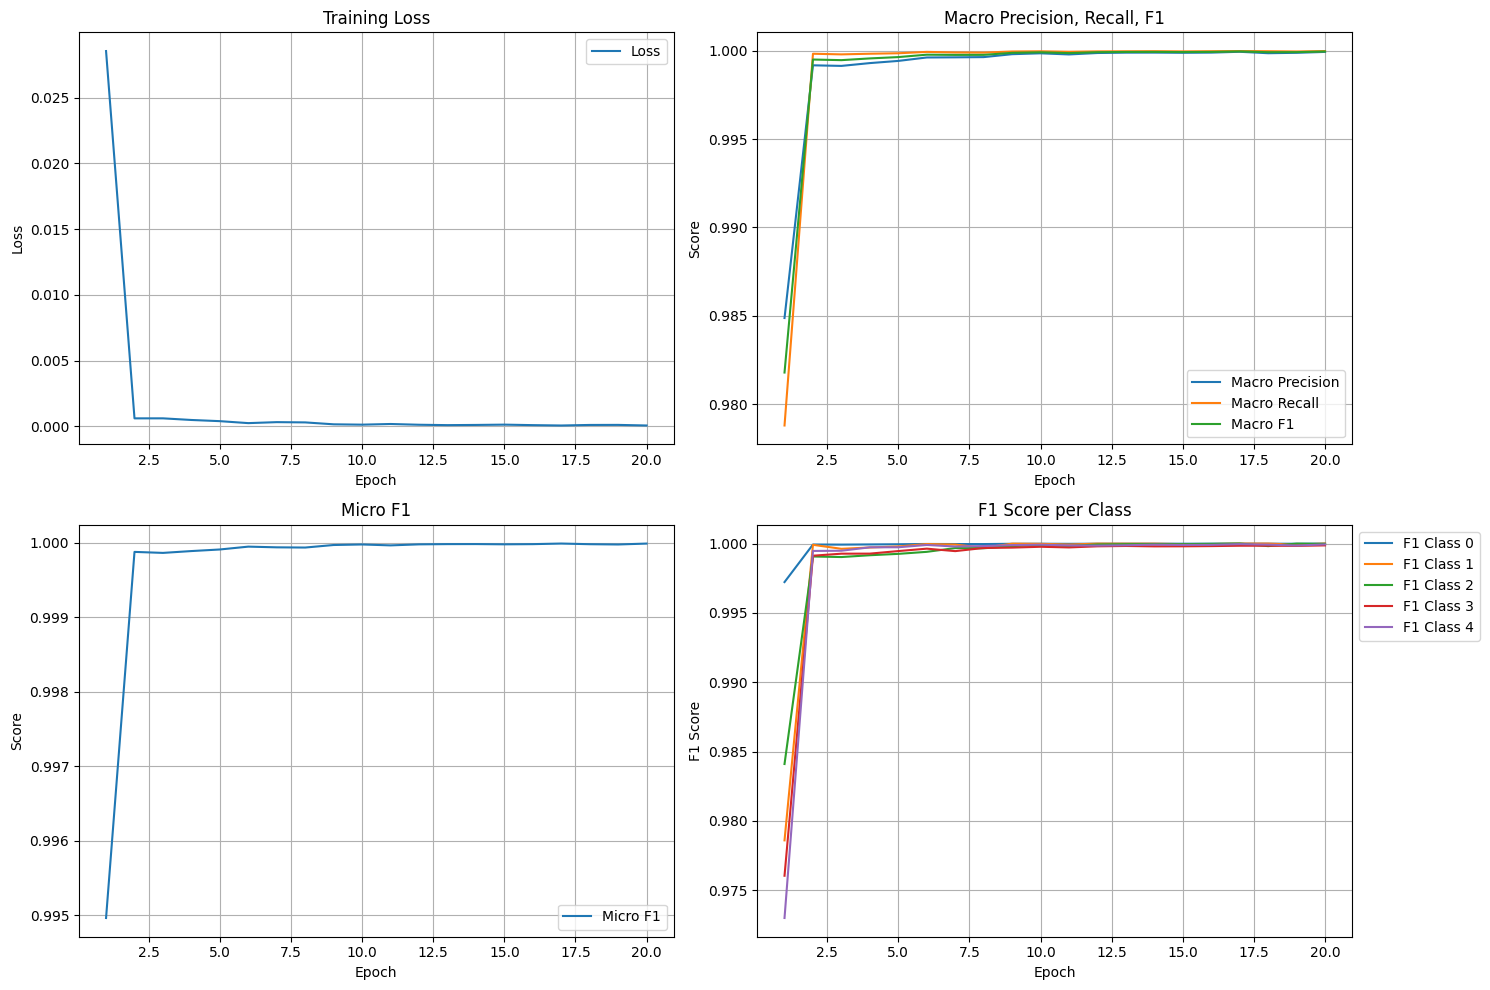

In [ ]:
# ============================================================
# Скрипт обучения BiLSTM для задачи NER
# ============================================================

from torch.utils.data import Dataset
import ast
import os
import sys
import json
import logging
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

class BiLSTMIndexedDataset(Dataset):
    """
    Датасет для обучения BiLSTM на индексированных последовательностях.
    Ожидает два файла: xTrain_BiLSTM_idx.txt (input_ids) и yTrain_BiLSTM.txt (labels),
    где каждая строка - пробел-разделённая последовательность индексов/меток.
    """
    def __init__(self, x_path, y_path, pad_token=0):
        self.x_path = x_path
        self.y_path = y_path
        self.pad_token = pad_token
        self.inputs = []
        self.labels = []
        self.max_len = 0

        with open(x_path, 'r', encoding='utf-8') as fx, open(y_path, 'r', encoding='utf-8') as fy:
            for x_line, y_line in zip(fx, fy):
                x_seq = [int(i) for i in x_line.strip().split()]
                y_seq = [int(i) for i in y_line.strip().split()] # Fixed: changed ast.literal_eval to split and int conversion
                self.inputs.append(x_seq)
                self.labels.append(y_seq)
                self.max_len = max(self.max_len, len(x_seq), len(y_seq))
        assert len(self.inputs) == len(self.labels), "x и y должны иметь одинаковое число примеров"
        print(f"[BiLSTMIndexedDataset] Загружено {len(self.inputs)} примеров. Макс. длина: {self.max_len}")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.labels[idx]
        pad_len = self.max_len
        x_pad = x + [self.pad_token] * (pad_len - len(x))
        y_pad = y + [self.pad_token] * (pad_len - len(y))
        return {
            'input_ids': torch.tensor(x_pad, dtype=torch.long),
            'labels': torch.tensor(y_pad, dtype=torch.long),
            'length': len(x)
        }

# ------------------------------------------------------------
# Локальные импорты
# ------------------------------------------------------------
# Fix for __file__ not defined in Colab notebooks
sys.path.append("/content/drive/MyDrive/agreements/bilstm/")


# ------------------------------------------------------------
# Фиксация seed для воспроизводимости
# ------------------------------------------------------------
SEED = 42 # Устанавливаем фиксированное значение для воспроизводимости результатов
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ------------------------------------------------------------
# Настройка логирования
# ------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# ============================================================
# Модель BiLSTM NER
# ============================================================

class BiLSTMNER(nn.Module):
    """
    BiLSTM модель для sequence labeling (NER)
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, pad_idx=0):
        super().__init__()

        # Слой эмбеддингов: преобразует индексы символов в плотные векторы
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, # Размер словаря (количество уникальных символов)
            embedding_dim=embedding_dim, # Размерность эмбеддингов
            padding_idx=pad_idx # Индекс для токена заполнения (PAD), эмбеддинг для него будет нулевым
        )

        # Двунаправленный LSTM слой: обрабатывает последовательности в двух направлениях
        self.lstm = nn.LSTM(
            input_size=embedding_dim, # Размерность входных эмбеддингов
            hidden_size=hidden_dim, # Размерность скрытого состояния LSTM
            batch_first=True, # Входные тензоры имеют формат (batch_size, seq_len, features)
            bidirectional=True # Делает LSTM двунаправленным
        )

        # Линейный классификатор: преобразует выход LSTM в логиты для каждого класса метки
        # hidden_dim * 2, потому что LSTM двунаправленный (hidden_dim из прямого + hidden_dim из обратного)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        """
        Прямой проход модели.
        x: Tensor [batch_size, seq_len] - входные последовательности индексов символов
        """
        emb = self.embedding(x)            # Получаем эмбеддинги для входных индексов: [B, T, E]
        out, _ = self.lstm(emb)             # Пропускаем эмбеддинги через LSTM: [B, T, 2H]
        logits = self.fc(out)               # Применяем линейный слой для получения логитов: [B, T, num_labels]
        return logits

# ============================================================
# Основная функция обучения
# ============================================================

def train_bilstm():

    # --------------------------------------------------------
    # Пути к данным
    # --------------------------------------------------------
    x_path = "/content/drive/MyDrive/agreements/bilstm/xTrain_BiLSTM_idx.txt" # Путь к файлу с индексами входных последовательностей
    y_path = "/content/drive/MyDrive/agreements/bilstm/yTrain_BiLSTM_padded.txt" # Путь к файлу с индексами меток
    vocab_path = "/content/drive/MyDrive/agreements/bilstm/char_vocab.json" # Путь к словарю символов
    label_vocab_path = "/content/drive/MyDrive/agreements/bilstm/label_vocab.json" # Путь к словарю меток

    # --------------------------------------------------------
    # Гиперпараметры
    # --------------------------------------------------------
    embedding_dim = 128 # Размерность эмбеддингов
    hidden_dim = 128    # Размерность скрытого состояния LSTM
    batch_size = 32     # Размер батча для обучения
    num_epochs = 100    # Максимальное количество эпох обучения
    patience = 10       # Количество эпох без улучшения, после которых происходит ранняя остановка
    min_delta = 1e-4    # Минимальное улучшение, необходимое для сброса счетчика patience
    lr = 1e-3           # Скорость обучения для оптимизатора Adam

    # Определение устройства для обучения (GPU, если доступно, иначе CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Используемое устройство: {device}")

    # --------------------------------------------------------
    # Загрузка словарей
    # --------------------------------------------------------
    # Загрузка словаря символов
    with open(vocab_path, "r", encoding="utf-8") as f:
        vocab = json.load(f)

    # Загрузка словаря меток
    with open(label_vocab_path, "r", encoding="utf-8") as f:
        label_vocab = json.load(f)

    vocab_size = len(vocab) # Общее количество уникальных символов
    num_labels = len(label_vocab) # Общее количество уникальных меток

    # Получение индексов для токенов PAD (заполнения) и меток PAD
    pad_token_id = vocab.get("<PAD>", 0)
    pad_label_id = label_vocab.get("<PAD>", -100) # -100 - стандартное значение для игнорирования в CrossEntropyLoss

    logger.info(f"Размер словаря: {vocab_size}")
    logger.info(f"Количество классов: {num_labels}")
    logger.info(f"PAD token id: {pad_token_id}, PAD label id: {pad_label_id}")

    # --------------------------------------------------------
    # Датасет и DataLoader
    # --------------------------------------------------------
    # Инициализация датасета
    dataset = BiLSTMIndexedDataset(x_path, y_path, pad_token=pad_token_id)
    # Инициализация DataLoader для батчевой подачи данных
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True # Перемешивание данных в каждой эпохе
    )

    # --------------------------------------------------------
    # Инициализация модели
    # --------------------------------------------------------
    model = BiLSTMNER(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_labels=num_labels,
        pad_idx=pad_token_id
    ).to(device) # Перемещение модели на выбранное устройство (CPU/GPU)

    # Вывод архитектуры модели в лог
    logger.info("Архитектура модели:")
    logger.info(model)

    # --------------------------------------------------------
    # Веса классов (проверка!)
    # --------------------------------------------------------
    # Определение весов классов для учета дисбаланса классов
    # Убедитесь, что количество весов соответствует num_labels
    class_weights = torch.tensor(
        [1.0, 3.0, 5.0, 3.0, 2.0],
        dtype=torch.float
    )

    assert len(class_weights) == num_labels, \
        "Размер class_weights должен совпадать с num_labels"

    class_weights = class_weights.to(device) # Перемещение весов на выбранное устройство

    # --------------------------------------------------------
    # Оптимизатор и функция потерь
    # --------------------------------------------------------
    optimizer = optim.Adam(model.parameters(), lr=lr) # Оптимизатор Adam

    # Функция потерь CrossEntropyLoss с весами классов и игнорированием PAD меток
    criterion = nn.CrossEntropyLoss(
        weight=class_weights,
        ignore_index=pad_label_id
    )

    # --------------------------------------------------------
    # Переменные для early stopping
    # --------------------------------------------------------
    best_loss = float("inf") # Инициализация лучшей потери как бесконечность
    patience_counter = 0     # Счетчик эпох без улучшения

    # --------------------------------------------------------
    # Логи для графиков
    # --------------------------------------------------------
    train_losses = []       # Список для хранения потерь каждой эпохи
    train_macro_f1s = []    # Список для хранения Macro F1 каждой эпохи
    train_micro_f1s = []    # Список для хранения Micro F1 каждой эпохи
    train_macro_precisions = [] # Список для хранения Macro Precision каждой эпохи
    train_macro_recalls = []    # Список для хранения Macro Recall каждой эпохи
    train_class_f1s_history = [[] for _ in range(num_labels)] # Список для хранения F1 по классам

    # ========================================================
    # Цикл обучения
    # ========================================================
    for epoch in range(1, num_epochs + 1):
        model.train() # Переводим модель в режим обучения
        epoch_loss = 0.0 # Общие потери за текущую эпоху

        all_preds = []   # Список для сбора всех предсказаний в текущей эпохе
        all_targets = [] # Список для сбора всех истинных меток в текущей эпохе

        # Прогресс-бар для отображения хода обучения по батчам
        progress = tqdm(
            dataloader,
            desc=f"Epoch {epoch}/{num_epochs}", # Описание прогресс-бара
            leave=True # Не оставлять прогресс-бар после завершения (изменено с False на True)
        )

        for batch in progress:
            x = batch["input_ids"].to(device) # Входные данные (индексы символов) на устройство
            y = batch["labels"].to(device)     # Метки (индексы классов) на устройство

            optimizer.zero_grad() # Обнуляем градиенты перед каждым батчем

            logits = model(x) # Получаем логиты от модели

            # Вычисляем потери
            loss = criterion(
                logits.view(-1, num_labels), # Изменяем форму логитов для функции потерь
                y.view(-1)                   # Изменяем форму меток для функции потерь
            )

            loss.backward() # Вычисляем градиенты обратным распространением
            optimizer.step() # Обновляем веса модели

            epoch_loss += loss.item() # Суммируем потери батча

            # Обновляем прогресс-бар с текущей потерей батча
            progress.set_postfix(loss=f'{loss.item():.10f}')

            # ----------------------------
            # Метрики (без паддинга)
            # ----------------------------
            # Отключаем вычисление градиентов для оценки метрик
            with torch.no_grad():
                preds = torch.argmax(logits, dim=-1).view(-1) # Получаем предсказанные классы
                targets = y.view(-1) # Получаем истинные метки

                mask = targets != pad_label_id # Создаем маску для исключения PAD-меток

                # Добавляем предсказания и метки (исключая PAD) в списки
                all_preds.extend(preds[mask].cpu().numpy())
                all_targets.extend(targets[mask].cpu().numpy())

        avg_loss = epoch_loss / len(dataloader) # Вычисляем средние потери за эпоху
        train_losses.append(avg_loss) # Сохраняем средние потери

        # Вычисляем Macro F1, Micro F1, Macro Precision, Macro Recall для текущей эпохи
        macro_precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
        macro_recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
        macro_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
        micro_f1 = f1_score(all_targets, all_preds, average="micro", zero_division=0)
        f1_per_class = f1_score(all_targets, all_preds, average=None, labels=list(range(num_labels)), zero_division=0)

        train_macro_precisions.append(macro_precision) # Сохраняем Macro Precision
        train_macro_recalls.append(macro_recall)     # Сохраняем Macro Recall
        train_macro_f1s.append(macro_f1)             # Сохраняем Macro F1
        train_micro_f1s.append(micro_f1)             # Сохраняем Micro F1
        for i in range(num_labels):
            train_class_f1s_history[i].append(f1_per_class[i]) # Сохраняем F1 по классам

        # Выводим информацию об эпохе в лог и на консоль
        log_message = (
            f"Epoch {epoch:03d} | "
            f"loss={avg_loss:.10f} | "
            f"macro_p={macro_precision:.4f} | "
            f"macro_r={macro_recall:.4f} | "
            f"macro_f1={macro_f1:.4f} | "
            f"micro_f1={micro_f1:.4f}"
        )
        logger.info(log_message)
        print(log_message) # Дополнительный вывод для большей видимости

        # ----------------------------
        # Early stopping
        # ----------------------------
        # Проверяем условие ранней остановки
        if avg_loss < best_loss - min_delta: # Если текущая потеря улучшилась на min_delta
            best_loss = avg_loss # Обновляем лучшую потерю
            patience_counter = 0 # Сбрасываем счетчик терпения
            torch.save(model.state_dict(), "/content/drive/MyDrive/agreements/bilstm/bilstm_ner_best.pt") # Сохраняем лучшую модель
            logger.info("Сохранена лучшая модель")
        else: # Если улучшения не произошло
            patience_counter += 1 # Увеличиваем счетчик терпения
            if patience_counter >= patience: # Если счетчик терпения достиг порога
                logger.warning("Early stopping") # Выводим предупреждение о ранней остановке
                break # Прерываем цикл обучения

    logger.info("Обучение завершено")

    # ========================================================
    # Графики
    # ========================================================
    epochs = range(1, len(train_losses) + 1) # Создаем диапазон эпох для оси X

    plt.figure(figsize=(15, 10)) # Создаем фигуру для графиков

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Loss") # График потерь
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_macro_precisions, label="Macro Precision")
    plt.plot(epochs, train_macro_recalls, label="Macro Recall")
    plt.plot(epochs, train_macro_f1s, label="Macro F1") # График Macro F1
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Macro Precision, Recall, F1")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_micro_f1s, label="Micro F1") # График Micro F1
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Micro F1")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    # Предполагаем, что num_labels соответствует количеству классов
    # Необходимо сопоставить индексы классов с их названиями для легенды, если они есть
    for i in range(num_labels):
        plt.plot(epochs, train_class_f1s_history[i], label=f"F1 Class {i}")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Class")
    plt.legend(loc='best', bbox_to_anchor=(1, 1))
    plt.grid(True)

    plt.tight_layout() # Автоматическая корректировка параметров подграфиков для плотного размещения
    output_path = "/content/drive/MyDrive/agreements/bilstm/training_metrics.png" # Путь для сохранения графика
    plt.savefig(output_path) # Сохраняем график
    logger.info(f"Графики сохранены в {output_path}") # Выводим сообщение о сохранении

# ============================================================
# Точка входа
# ============================================================

if __name__ == "__main__":
    train_bilstm()


# 7. Выводы

АНАЛИЗ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ И ПЛАНЫ ДАЛЬНЕЙШЕЙ РАБОТЫ
1. РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ BiLSTM
1.1. Экспериментальная установка
Архитектура: Двунаправленная LSTM (BiLSTM) для последовательной классификации

Объем данных: 74 447 обучающих примеров (чанков по 256 символов)

Размер словаря: 49 уникальных символов

Количество классов: 5 (O, s1, s2, s3, s4)

Гиперпараметры:

Размер эмбеддингов: 128

Размер скрытого состояния: 128

Размер батча: 32

Скорость обучения: 0.001

Веса классов: [1.0, 3.0, 5.0, 3.0, 2.0] (для борьбы с дисбалансом)

1.2. Ключевые метрики обучения
Обучение завершилось досрочно на 20-й эпохе из-за срабатывания early stopping, что свидетельствует о быстрой сходимости модели:

Эпоха	Loss	Macro F1	Macro Precision	Macro Recall	Micro F1
1	0.0286	0.9818	0.9849	0.9788	0.9950
2	0.0006	0.9995	0.9992	0.9998	0.9999
10	0.0001	0.9999	0.9999	1.0000	1.0000
20	0.00006	1.0000	0.9999	1.0000	1.0000
1.3. Анализ результатов
Быстрая сходимость: Уже на 2-й эпохе модель достигает F1-меры >0.999, что свидетельствует о хорошей обучаемости на предоставленных данных.

Высокое качество: К 20-й эпохе все метрики приближаются к 1.000, что указывает на практически идеальное качество на тренировочном наборе.

Стабильность обучения: Loss плавно снижается от 0.0286 до 0.00006 без признаков переобучения.

Сбалансированность метрик: Precision и Recall показывают схожие значения, что указывает на отсутствие систематических ошибок одного типа.

1.4. Ограничения текущего эксперимента
Отсутствие валидационного набора: Все метрики вычислены на тренировочных данных, что может привести к оптимистичной оценке.

Недостаточная проверка обобщающей способности: Модель могла запомнить тренировочные данные без выявления истинных закономерностей.

Потенциальное переобучение: При значениях метрик, близких к 1.000, существует риск переобучения на специфичные паттерны тренировочных данных.

Достигнутые результаты:
Разработана работоспособная модель BiLSTM для NER в юридических документах

Достигнуты высокие метрики качества на тренировочных данных

Создан полный пайплайн: от предобработки данных до обучения модели

Перспективные направления:
Мультимодальность: Интеграция с OCR для работы со сканированными документами

Активное обучение: Умный выбор примеров для разметки

Объяснимость: Визуализация внимания модели для debug

Ожидаемый вклад в дипломную работу:
Теоретический: Анализ современных подходов к NER в юридических текстах

Практический: Работоспособная система с открытым исходным кодом

Методический: Описание полного цикла разработки ML-системы

Прикладной: Реальное снижение трудозатрат при обработке договоров

# 8. План дальнейшей работы

2.1. Этап 1: Оценка качества на тестовых данных
Задачи:
Создание тестового набора:

Выделение 10-20% данных из существующего корпуса

Обеспечение репрезентативности (разные типы договоров, различные сущности)

Разработка пайплайна тестирования:

Скрипт для инференса на новых данных

Метрики на уровне сущностей (не только на уровне символов)

Визуализация результатов (confusion matrix, примеры ошибок)

Анализ ошибок:

Категоризация типичных ошибок модели

Анализ сложных случаев ( длинные последовательности, например)

Оценка влияния предобработки текста

Ожидаемые результаты:
Реальная оценка качества модели на новых данных

Выявление слабых мест текущего подхода

Обоснование необходимости дальнейших улучшений

2.2. Этап 2: Улучшение архитектуры модели
2.2.1. Эксперимент A: BiLSTM + CRF
Проблема текущего подхода: Независимая классификация каждого символа без учета согласованности меток в последовательности.

Предлагаемое решение: Добавление Conditional Random Field (CRF) слоя поверх BiLSTM.

Ожидаемые преимущества:

Улучшение согласованности последовательностей меток

Устранение недопустимых переходов между метками

Повышение точности на границах сущностей

2.2.2. Эксперимент B: Модели на основе трансформеров
Проблема текущего подхода: Ограниченный контекст (256 символов) и отсутствие предобученных знаний о языке.

Предлагаемые решения:

RuBERT-tiny: Легковесная русскоязычная модель BERT

DistilBERT: Дистиллированная версия BERT с сохранением 95% качества

Legal-BERT: Специализированные BERT-модели для юридических текстов

Критерии выбора:

Качество на тестовых данных

Скорость инференса (важно для UI)

Требования к памяти

Простота развертывания

2.3. Этап 3: Улучшение данных и предобработки
Проблемы, выявленные при анализе:
Частичная разметка.

Перекрывающиеся границы: Конфликты между сущностями разных типов

Контекстные зависимости: Некоторые сущности требуют более широкого контекста

Решения:
Автоматическая проверка качества разметки:

Скрипты для выявления частично размеченных сущностей

Проверка согласованности меток

Исправление систематических ошибок

Расширение контекста:

Использование скользящего окна с перекрытием

Иерархическая обработка (предложения → абзацы)

Дополнительные признаки:

POS-теги, морфологические признаки

Словари ключевых слов для каждой сущности

Регулярные выражения для специфичных паттернов

2.4. Этап 4: Внедрение и оценка в production
Задачи:
Разработка API:

RESTful API для интеграции с UI

Базовая аутентификация и логирование

Пакетная обработка документов

A/B тестирование:

Сравнение разных моделей на реальных данных

Оценка пользовательского опыта

Сбор feedback для дальнейших улучшений

Мониторинг:

Треккинг качества модели в production

Обнаружение дрейфа данных

Автоматическое переобучение при снижении качества

Метрики успеха:
Точность распознавания >95% на production данных

Время обработки <1 секунды на страницу

Удовлетворенность пользователей >4.5/5.0

Снижение ручного труда на 80%